In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import regex as re
from itertools import cycle
import yaml


In [689]:
## some styling 

plt.style.use('dark_background')

# colors
red    = '#f54242'
orange = '#f7993b'
yellow = '#ffe359'
green  = '#a2f781'
blue   = '#42daf5'
purple = '#d170fa'

# change boxplot
mpl.rcParams['boxplot.boxprops.color'] = blue
mpl.rcParams['boxplot.boxprops.linewidth'] = 1

mpl.rcParams['boxplot.whiskerprops.color'] = blue
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 1

mpl.rcParams['boxplot.medianprops.color'] = blue
mpl.rcParams['boxplot.medianprops.linewidth'] = 1

mpl.rcParams['boxplot.capprops.color'] = blue
mpl.rcParams['boxplot.capprops.linewidth'] = 1

mpl.rcParams['boxplot.flierprops.markeredgecolor'] = red

In [690]:
# functions for later use

def get_unique_values(description):
    """ Gets all the unique lab substances with the given description """
    
    descs = [item for item in desc if re.search(description, item, re.IGNORECASE)]
    for item in descs:

        bepcodes = df[df['DESC'] == item]['BEPCODE'].unique()
        units = [set(df[df['BEPCODE'] == bep]['EENHEID']).pop() for bep in bepcodes]
        val_counts = df[df['BEPCODE'].isin(bepcodes)]['BEPCODE'].value_counts()

        print(item, *zip(bepcodes, list(val_counts), units))
        

def print_unique_values_overview(description):
    """ Prints all the unique lab substances with the given description """

    print(f'{"SUBSTANCE":<40} {"BEPCODE":<10} {"VAL_COUNT":<10} {"%":<8} {"FLUID":<20} {"UNIT":<12}')
    print('-' * 100)

    descs = [item for item in desc if re.search(description, item, re.IGNORECASE)]
    total_vals = sum(len(df[df['DESC'] == item]) for item in descs)

    for item in descs:

        bepcodes = df[df['DESC'] == item]['BEPCODE'].unique()
        val_counts = df[df['BEPCODE'].isin(bepcodes)]['BEPCODE'].value_counts()
        for val_count, bepcode in zip(val_counts, bepcodes):
            unit = df[df['BEPCODE'] == bepcode]['EENHEID'].unique()[0]
            perc = val_count / total_vals * 100
            fluid = df[df['BEPCODE'] == bepcode]['MATAARD'].unique()[0]

            print(f'{item:<40} {bepcode:<10} {val_count:<10} {f"{perc:.2f}":<8} {fluid:<20} {unit:<18}')
        print('-' * 100)


def create_pie_diagram(df, description):
    """ Creates a pie diagram """
    adm_dict = {0: 'not admitted', 1: 'admitted'}

    val_counts = df['OPNAME'].value_counts(dropna=False)
    
    plt.figure(figsize=(6, 6))

    _, _, autotexts = plt.pie(val_counts, labels=[adm_dict[key] for key in val_counts.keys()], 
                            colors=[red, blue], autopct='%1.0f%%', labeldistance=1.2)
    plt.setp(autotexts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
    plt.title(f'Pie diagram of  {description} admission value counts')

    plt.show()


def show_non_numeric_counts(df):
    """ Prints all the non numeric values and their counts in the given df """

    val_counts = df['UITSLAG'].value_counts(dropna=False)
    non_num = 0
    total = 0

    for value, count in val_counts.items():
        try:
            float(value)
        except ValueError:
            print(f'{value:<20}{count:<6}')
            non_num += count
        finally:
            total += count

    print(f'total of {non_num} non numeric values ({non_num/total*100:.2f} %)')

def calculate_mean(item):
    items = item.split()
    if (len(items) == 3) and (items[1] == '-'):
        item = np.mean([items[0], items[2]])
    return item

def handle_numeric_category_column(df, column):
    """ Handles numeric category column (Range functions, greater than, lesser than ,etc.) """

    df_copy = df.copy()
    df_copy.loc[:,column] = df_copy[column].apply(lambda x: calculate_mean)
    df_copy = clean_numeric_column(df, column)

    return df_copy

def clean_numeric_column(df, column):
    """ Transfers a numeric column where not all values are a number """

    df_copy = df.copy()
    df.loc[:,column] = df[column].apply(lambda item: re.sub(r'^[<>]', '', str(item)))
    df.loc[:,column] = df[column].apply(lambda item: pd.to_numeric(item, errors='coerce'))
    df.loc[:,column] = df[column].apply(lambda item: 0 if item is 'negatief' else item)
    df.loc[:,column] = df[column].dropna()

    return df

def create_distribution_plots(df, description=None):
    """ Creates violoing plots and boxplots of the given data, divided into admitted and dischargerd"""

    df = df[~df['UITSLAG'].isna()]

    all = df['UITSLAG']
    not_admitted = df[df['OPNAME'] == 0]['UITSLAG']
    admitted = df[df['OPNAME'] == 1]['UITSLAG']

    plt.figure(figsize=(14, 10))

    # violin plot
    plt.subplot(1, 2, 1)
    viol = plt.violinplot([all, not_admitted, admitted], showmedians=True)#, labels=['all', 'not admitted', 'admitted'])
    plt.xticks(range(1, 4), ['all', 'not admitted', ' admitted'])
    plt.title(f'Violin plot of {description}', fontsize=14)
    plt.grid(alpha=.2)

    for pc in viol['bodies']:
        pc.set_facecolor(blue)
        pc.set_alpha(.9)

    # boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot([all, not_admitted, admitted], labels=['all', 'not admitted', 'admitted'], showfliers=1)
    plt.title(f'Box plot of {description}', fontsize=14)
    plt.grid(alpha=.2)

    plt.tight_layout()
    plt.show()


def create_histograms(df, description=None):
    """ Creates histogram of the data, divided into discharged and admitted """

    df = df[~df['UITSLAG'].isna()]

    all = df['UITSLAG']
    not_admitted = df[df['OPNAME'] == 0]['UITSLAG']
    admitted = df[df['OPNAME'] == 1]['UITSLAG']
    bins = np.linspace(0, max(all), 50)

    # to set ylim the same in both hists we need to obtain the max frequency:
    y_max = np.max([
        np.histogram(admitted, bins=bins)[0],
        np.histogram(not_admitted, bins=bins)[0]
        ])

    plt.figure(figsize=(14, 6))
    plt.suptitle(f'Histograms of {description} values\nseperated by admission',
                fontsize=18)

    plt.subplot(1, 2, 1)
    plt.title('Not admitted', fontsize=14)
    plt.hist(not_admitted, color=blue, bins=bins)
    plt.xlim(min(all), max(all))
    plt.ylim(0, y_max*1.1)
    plt.grid(alpha=.2)

    plt.subplot(1, 2, 2)
    plt.title('Admitted', fontsize=14)
    plt.hist(admitted, color=red, bins=bins)
    plt.xlim(min(all), max(all))
    plt.ylim(0, y_max*1.1)
    plt.grid(alpha=.2)

    plt.tight_layout()  
    plt.show()

def create_date_histogram(df, n_bins=50):
    """ Creates a date histogram of amount of entries over time """

    colors = [blue, red]

    plt.figure(figsize=(13, 7))
    plt.title('Distribution of the dates')
    plt.xlabel('Year')
    plt.ylabel('Number of lab results')

    bottom = 0
    range = (pd.to_datetime('20150101'), 
             pd.to_datetime('20230901'))

    for i, categorie in enumerate(df['OPNAME'].unique()):
        subset = df[df['OPNAME'] == i]['AANKSDATUM']
        hist_values, bins, _ = plt.hist(subset, bins=n_bins, color=colors[i], range=range, width=40, label=categorie, bottom=bottom)
        bottom = hist_values  # start value, so that it is stacked next time

    combined_subset = df['AANKSDATUM']
    combined_hist_values, combined_bins, _ = plt.hist(combined_subset, bins=n_bins, range=range, color='gray', alpha=0, width=40)

    # Calculate the centers of the bins
    bin_centers = (combined_bins[:-1] + combined_bins[1:]) / 2

    # Fit a linear regression line to the combined histogram values
    z = np.polyfit(bin_centers, combined_hist_values, 1)
    p = np.poly1d(z)

    # Plot the combined trendline
    plt.plot(bin_centers, p(bin_centers), color='white', linestyle='dashed', label='Combined Trendline')

    plt.gcf().autofmt_xdate()
    plt.ylim(0, max(combined_hist_values * 1.2))
    plt.xlim(*range)
    plt.grid(alpha=.2)
    plt.legend(labels=['Trendline', 'Not admitted', 'Admitted'], loc='best')
    plt.show()

### Loading the data

In [691]:
with open('./eda_config.yaml') as file:
    config = yaml.safe_load(file)

In [692]:
df = pd.read_csv(config['lab_data'], sep=';')
df = df[~df['BESTEMMING'].isna()]
df.isna().sum()

SEHID              0
PATIENTNR          0
BEPCODE            0
UITSLAG            0
AANVRAAGNR         0
AANKSDATUM         0
AANKSTIJD          0
AFDATUM            0
AFTIJD             0
DESC               0
EENHEID        50313
MATAARD       153440
DD                 0
BESTEMMING         0
dtype: int64

In [693]:
df['AANKSDATUM'] = pd.to_datetime(df['AANKSDATUM'])
df['AFDATUM'] = pd.to_datetime(df['AFDATUM'])
df = df[df['AANKSDATUM'] < '2022']
df['OPNAME'] = df['BESTEMMING'].apply(lambda x: 1 if x == 'OPN' else 0)

In [ ]:
df['AFDATUM'] = pd.to_datetime(df['AFDATUM'] + pd.to_timedelta(df['AFTIJD'] + ':00'))
df.drop(columns=['AFTIJD'])
df['AANKSDATUM'] = pd.to_datetime(df['AANKSDATUM'] + pd.to_timedelta(df['AANKSTIJD'] + ':00'))
df.drop(columns=['AANKSTIJD'])

Per ED visit we only want lab results obtained after the ED visit.

In [695]:
df['TIMEDELTA'] = df['AFDATUM'] - df['AANKSDATUM']
df['HOURDELTA'] = df['TIMEDELTA'].apply(lambda x: int(round(np.sign(x.days) * (abs(x.days) * 24 + x.seconds / 3600))))
df = df[df['TIMEDELTA'] > '00:00:00']

In [696]:
df_sorted = df.sort_values(by='TIMEDELTA')
df = df_sorted.drop_duplicates(subset=['SEHID', 'BEPCODE'], keep='first')

### EDA

#### General inspection and functions

In [697]:
df['BEPCODE'].nunique()

684

We have way more BEPCODES than the list of lab results. Lets see which lab results we have.  

In [698]:
desc = sorted(df['DESC'].unique())
print(desc)

['ALAT', 'AQT-Troponine T', 'ASAT', 'Alkalische Fosfatase', 'Alkalische Fosfatase (AF)', 'Alkalische Fosfatase Botfractie', 'Ammoniak arterieel', 'Ammoniak veneus', 'Base Excess arterieel', 'Base Excess centraal veneus', 'Base Excess mix veneus', 'Base Excess navelstreng arterieel', 'Base Excess navelstreng veneus', 'Base Excess(POC)', 'Bicarbonaat Arterieel', 'Bicarbonaat centraal veneus', 'Bicarbonaat mix veneus', 'Bicarbonaat navelstreng veneus', 'Bicarbonaat veneus', 'Bilirubine Totaal', 'CRP', 'CRP-POCT', 'Dyspl. kenmerken trombocyten', 'GGT', 'Glucose', 'Glucose (POC)', 'Glucose (av)', 'Glucose (n)', 'Glucose 11:00', 'Glucose 15:00', 'Glucose GLUC', 'Glucose Hemocue (POC)', 'Glucose POC', 'Glucose Pericard', 'Glucose Pleura', 'Glucose Urine kwal (POC)', 'Glucose istat (POC) (00:00)', 'Glucose istat (POC) (00:01)', 'Glucose istat (POC) (00:05)', 'Glucose istat (POC) (00:08)', 'Glucose istat (POC) (00:11)', 'Glucose istat (POC) (00:12)', 'Glucose istat (POC) (00:13)', 'Glucose ista

There are a lot of Glucoses istat (POC) description. One for every time. We got to handle this during data preprocessing.  
Furthermore, we have some duplicate in other lab result types.  
Lets explore each category.

**All of the substance description are generated with ChatGPT. They were not fact checked and are only to gain some knowledge of the substance were working with*

#### UREUM

Urea, often measured as blood urea nitrogen (BUN), is a waste product from protein metabolism. The normal range for urea (BUN) levels is typically between 2.5 to 7.1 millimoles per liter (mmol/L). Elevated urea levels may indicate kidney dysfunction or other medical conditions, necessitating further medical evaluation and appropriate management. Monitoring urea levels is essential for assessing kidney function and overall metabolic health.

In [699]:
print_unique_values_overview('ureum')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Ureum                                    CS000184   90767      89.78    Heparine plasma      mmol/L            
Ureum                                    @0003847   15         0.01     nan                  mmol/l            
Ureum                                    00003315   5          0.00     nan                  mmol/l            
Ureum                                    CS000495   3          0.00     Urine portie         mmol/L            
Ureum                                    CS003376   2          0.00     Urine                mmol/L            
Ureum                                    CS000530   1          0.00     24u Urine            mmol/24 uur       
----------------------------------------------------------------------------------------------------
Ureum (POC)         

##### Ureum (CS000184)

In [700]:
df_ureum = df[df['BEPCODE'] == 'CS000184']
# df_ureum.head()

In [701]:
show_non_numeric_counts(df_ureum)

<0.5                5     
Vervallen monster   3     
rect                2     
--                  1     
???                 1     
-                   1     
total of 13 non numeric values (0.01 %)


In [702]:
df_ureum = clean_numeric_column(df_ureum, 'UITSLAG')
show_non_numeric_counts(df_ureum)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


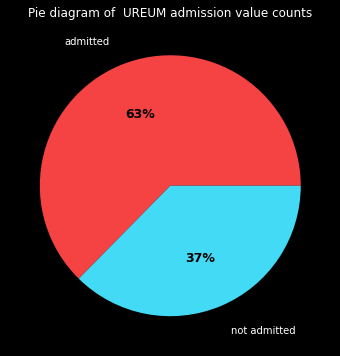

In [703]:
create_pie_diagram(df_ureum, 'UREUM')

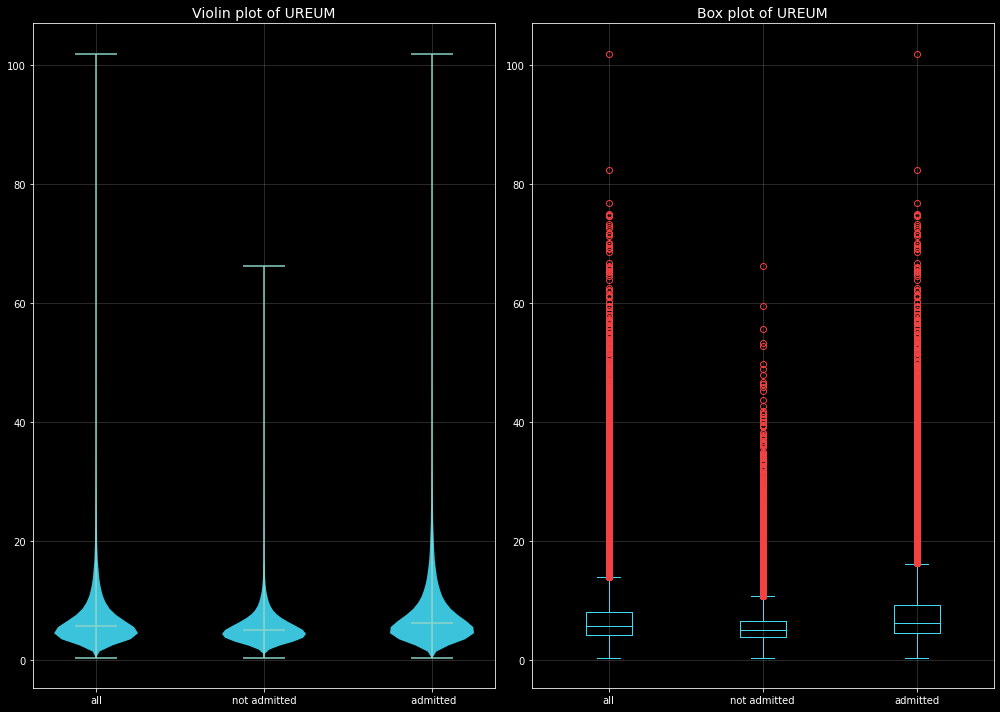

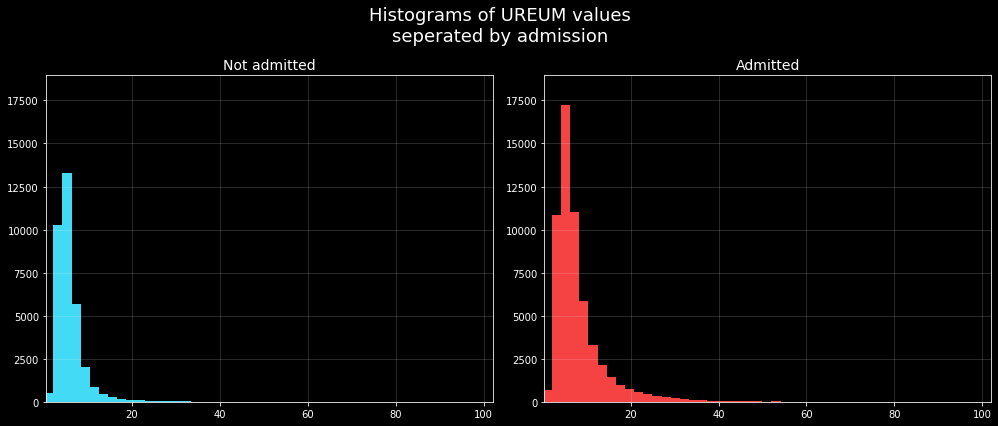

In [704]:
create_distribution_plots(df_ureum, 'UREUM')
create_histograms(df_ureum, 'UREUM')

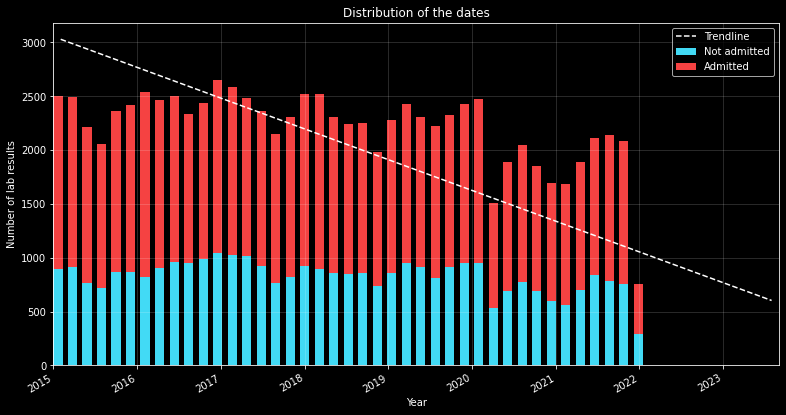

In [705]:
create_date_histogram(df_ureum)

In [706]:
df_ureum[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.198235
OPNAME   0.198235  1.000000

In [707]:
df_all = df_ureum.copy()

##### Ureum (POC) (ZGT01766 & ZGT01761)

In [708]:
df_ureum2 = df[df['BEPCODE'].isin(['ZGT01761', 'ZGT01766'])]
# df_ureum2.head()

In [709]:
df_ureum2['UITSLAG'].isna().sum()

0

In [710]:
show_non_numeric_counts(df_ureum2)

***                 59    
>50.0               39    
<1.0                26    
Vervallen monster   11    
<>                  3     
total of 138 non numeric values (1.34 %)


In [711]:
df_ureum2 = clean_numeric_column(df_ureum2, 'UITSLAG')
show_non_numeric_counts(df_ureum2)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


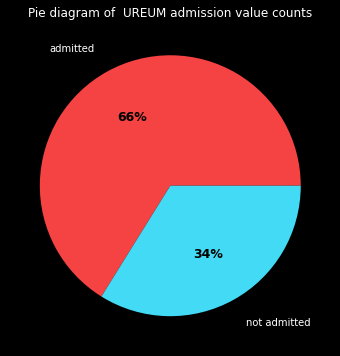

In [712]:
create_pie_diagram(df_ureum2, 'UREUM')

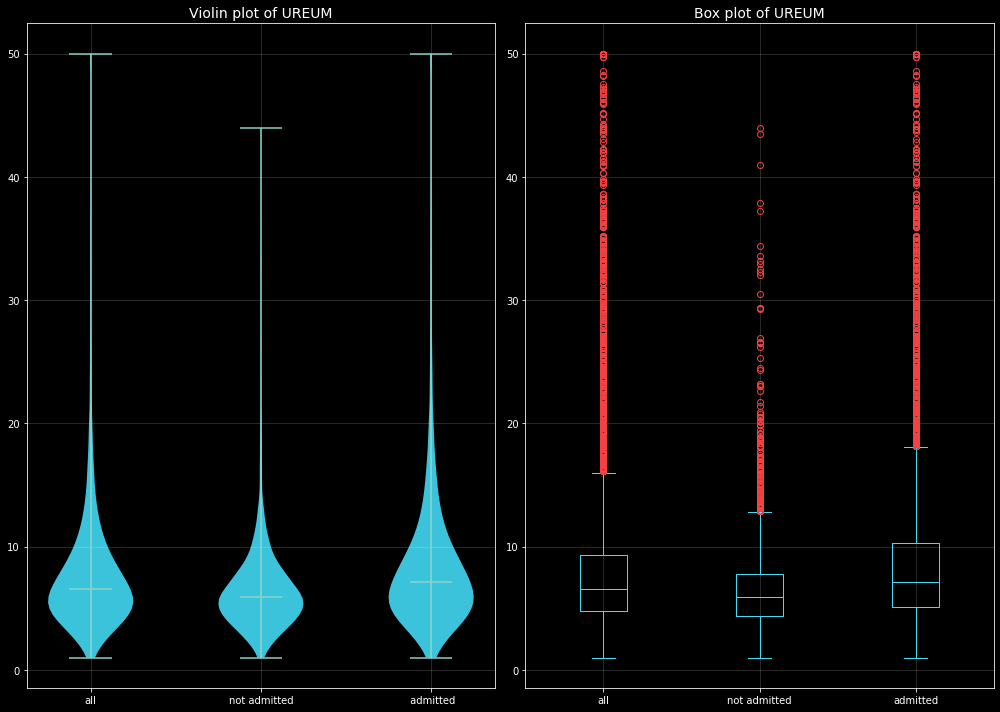

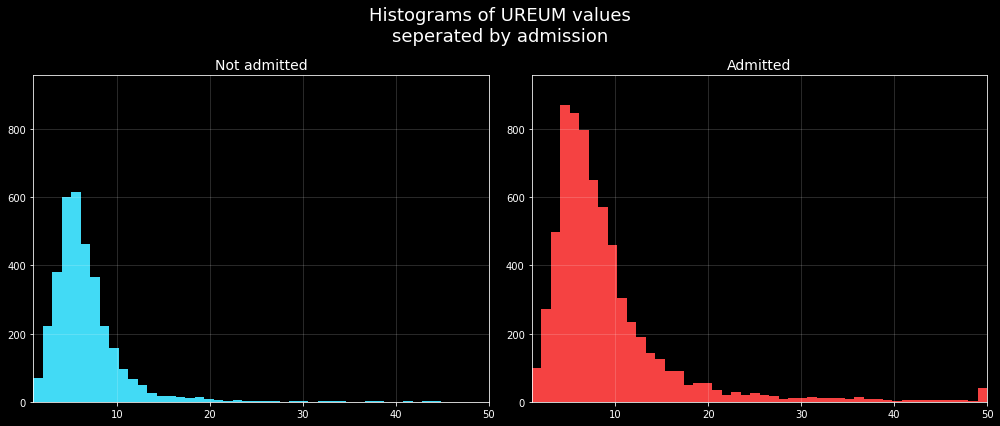

In [713]:
create_distribution_plots(df_ureum2, 'UREUM')
create_histograms(df_ureum2, 'UREUM')

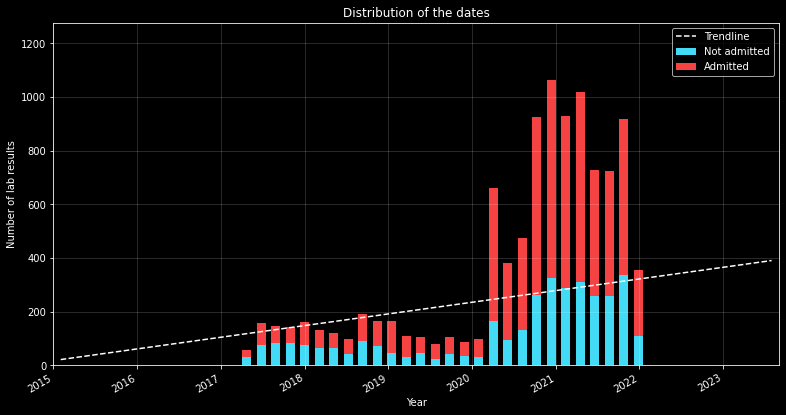

In [714]:
create_date_histogram(df_ureum2)

In [715]:
df_ureum2['DESC'] = 'Ureum (POC)' 
df_all = pd.concat([df_all, df_ureum2])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [716]:
df_ureum2[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.185216
OPNAME   0.185216  1.000000

#### KREATININE

Creatinine is a waste product from muscle metabolism, and its levels in the blood indicate kidney function. The normal range for creatinine levels is generally 53.76 to 107.04  umol/L for adult males and 53.76 to 98.04 umol/L for adult females. Elevated creatinine levels may suggest kidney dysfunction, necessitating further medical evaluation and potential treatment. Monitoring creatinine levels is crucial for assessing kidney health and overall renal function.

In [717]:
print_unique_values_overview('kreatinine')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Kreatinine                               CS000187   103732     83.53    Heparine plasma      µmol/L            
Kreatinine                               CS000497   10081      8.12     Urine portie         mmol/L            
Kreatinine                               @0002703   32         0.03     nan                  µmol/l            
Kreatinine                               00003316   4          0.00     nan                  µmol/l            
Kreatinine                               @0000313   2          0.00     nan                  µmol/l            
Kreatinine                               CS000532   1          0.00     24u Urine            mmol/24 uur       
Kreatinine                               CS000569   1          0.00     Vocht                µmol/L            
---------

##### Kreatinine (CS000187)

In [718]:
df_kreat = df[df['BEPCODE'] == 'CS000187']
# df_kreat.head()

In [719]:
df_kreat['UITSLAG'].isna().sum()

0

In [720]:
show_non_numeric_counts(df_kreat)

Vervallen monster   4     
<5                  2     
-                   2     
rect                2     
???                 2     
--                  1     
total of 13 non numeric values (0.01 %)


In [721]:
df_kreat = clean_numeric_column(df_kreat, 'UITSLAG')
show_non_numeric_counts(df_kreat)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


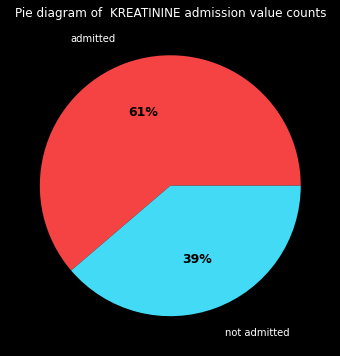

In [722]:
create_pie_diagram(df_kreat, 'KREATININE')

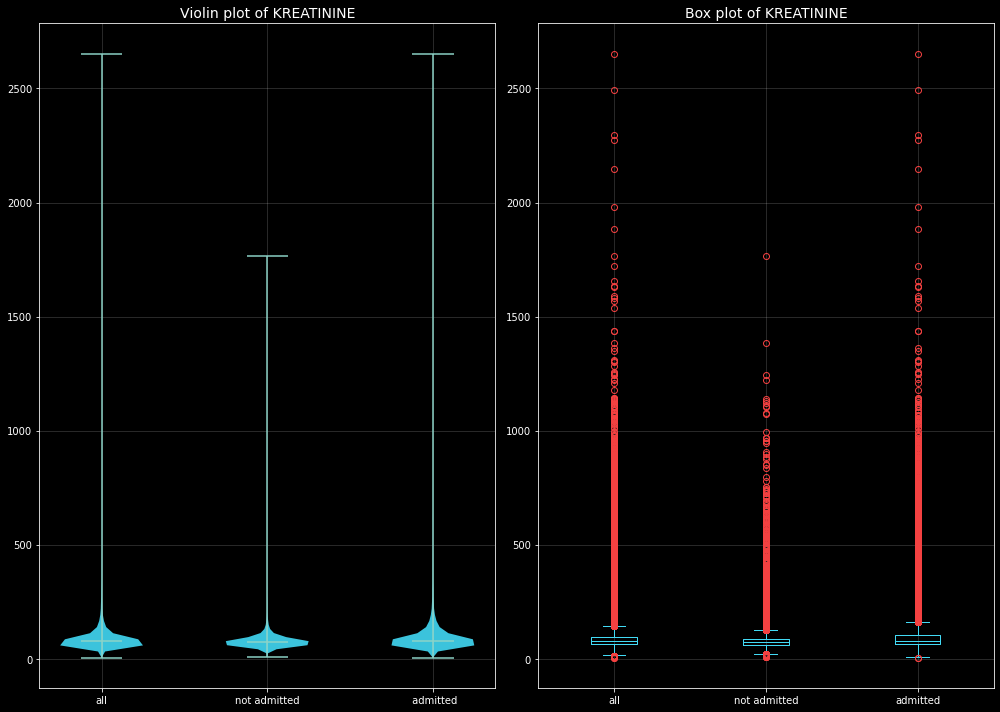

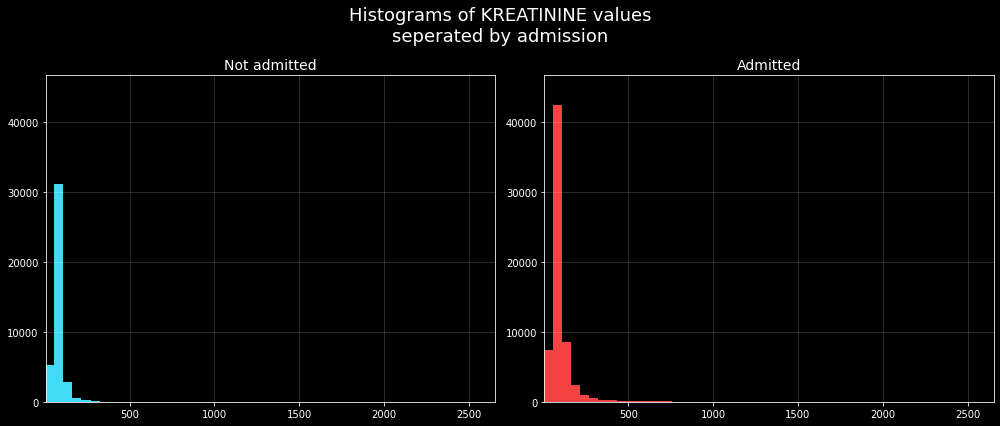

In [723]:
create_distribution_plots(df_kreat, 'KREATININE')
create_histograms(df_kreat, 'KREATININE')

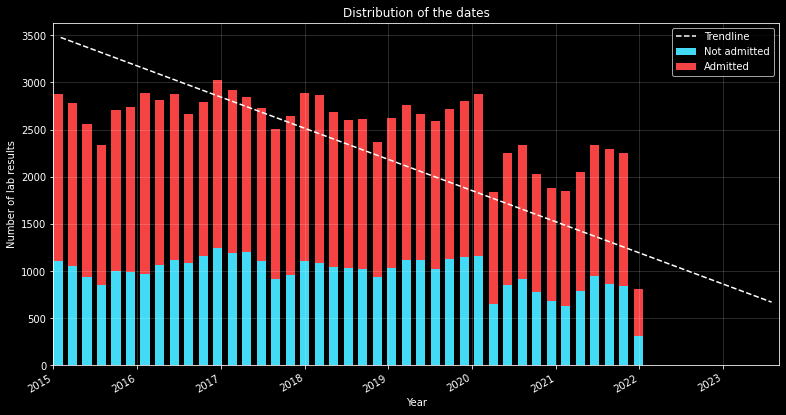

In [724]:
create_date_histogram(df_kreat)

In [725]:
df_kreat[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.120626
OPNAME   0.120626  1.000000

In [726]:
df_all = pd.concat([df_all, df_kreat])

##### Kreatinine (ZGT01318 & ZGT01321)

In [727]:
df_kreat2 = df[df['BEPCODE'].isin(['ZGT01318', 'ZGT01321'])]
# df_kreat2.head()

In [728]:
df_kreat2['UITSLAG'].isna().sum()

0

In [729]:
show_non_numeric_counts(df_kreat2)

***                 47    
Vervallen monster   11    
<18                 7     
>1768               4     
total of 69 non numeric values (0.67 %)


In [730]:
df_kreat2 = clean_numeric_column(df_kreat2, 'UITSLAG')
show_non_numeric_counts(df_kreat2)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


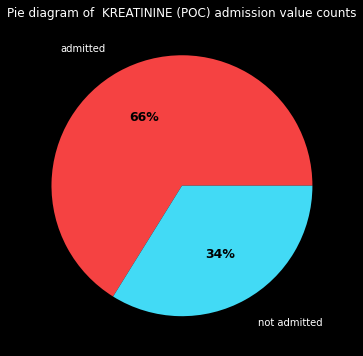

In [731]:
create_pie_diagram(df_kreat2, 'KREATININE (POC)')

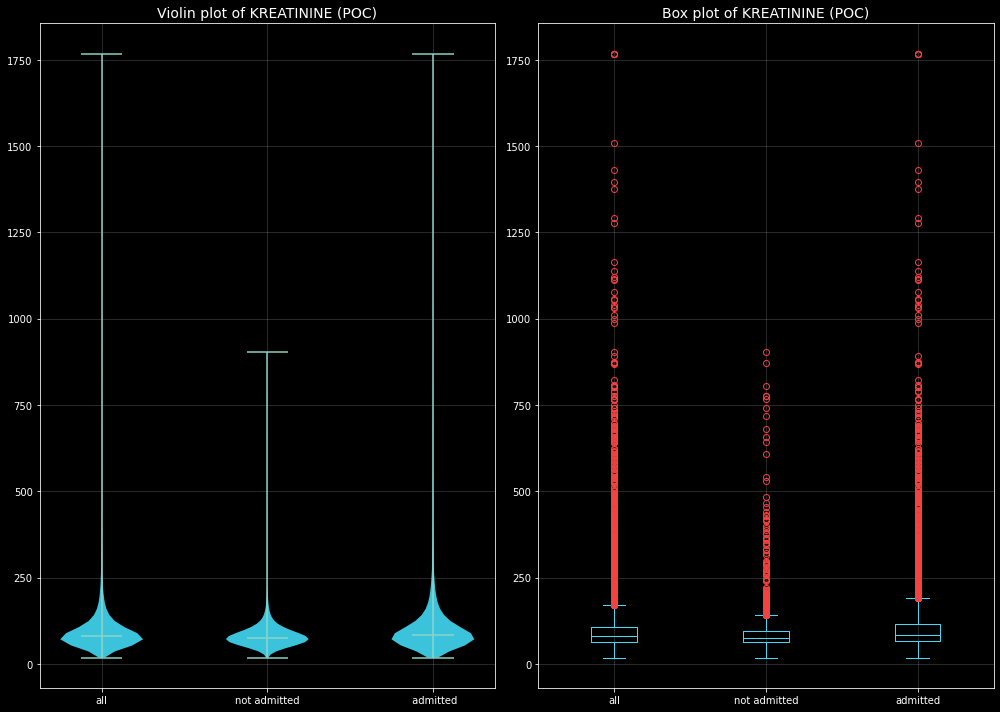

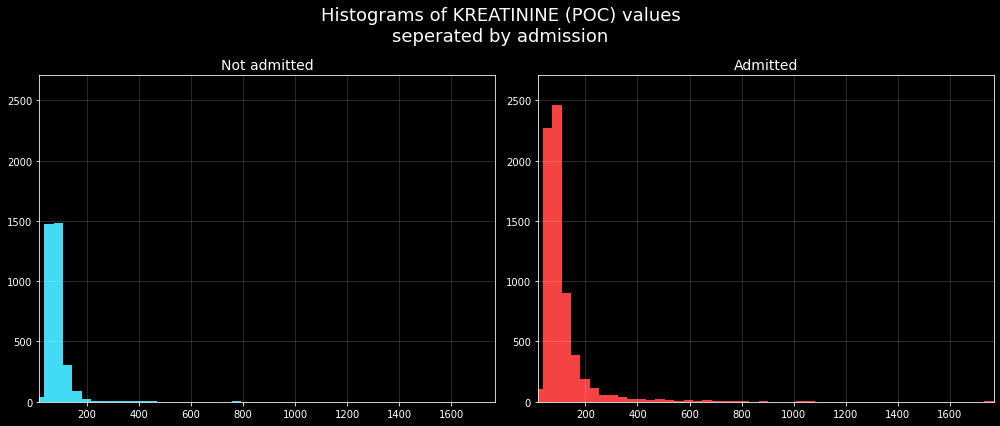

In [732]:
create_distribution_plots(df_kreat2, 'KREATININE (POC)')
create_histograms(df_kreat2, 'KREATININE (POC)')

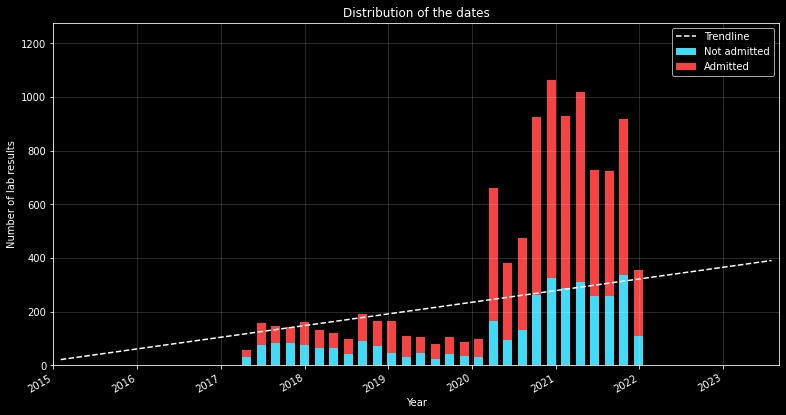

In [733]:
create_date_histogram(df_kreat2)

In [734]:
df_kreat2[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.123183
OPNAME   0.123183  1.000000

In [735]:
df_kreat2['DESC'] = 'Kreatinine (POC)' 
df_all = pd.concat([df_all, df_kreat2])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### NATRIUM

Sodium is a vital electrolyte found in the blood, crucial for maintaining fluid balance, nerve function, and blood pressure regulation. The normal range of sodium concentration in the blood is typically 135 to 145 millimoles per liter (mmol/L). Abnormal levels, either below or above this range, can indicate imbalances that may affect overall health.

In [736]:
print_unique_values_overview('natrium')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Natrium                                  CS000165   102641     89.25    Heparine plasma      mmol/L            
Natrium                                  CS000485   2034       1.77     Urine portie         mmol/L            
Natrium                                  00003319   13         0.01     nan                  mmol/l            
Natrium                                  @0000570   3          0.00     nan                  mmol/l            
Natrium                                  CS003352   1          0.00     24u Urine            mmol/24u          
Natrium                                  CS003351   1          0.00     urine                mmol/L            
----------------------------------------------------------------------------------------------------
Natrium (POC)       

#####   Natrium (CS000165)

In [737]:
df_natr = df[df['BEPCODE'] == 'CS000165']
# df_natr.head()

In [738]:
df_natr['UITSLAG'].isna().sum()

0

In [739]:
show_non_numeric_counts(df_natr)

Vervallen monster   4     
-                   3     
???                 3     
rect                2     
--                  1     
#88                 1     
total of 14 non numeric values (0.01 %)


In [740]:
df_natr = clean_numeric_column(df_natr, 'UITSLAG')
show_non_numeric_counts(df_natr)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


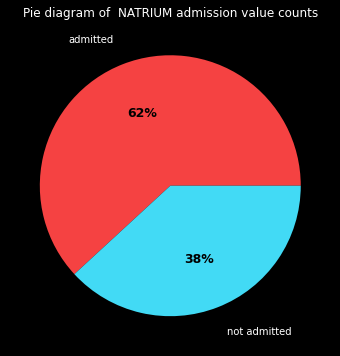

In [741]:
create_pie_diagram(df_natr, 'NATRIUM')

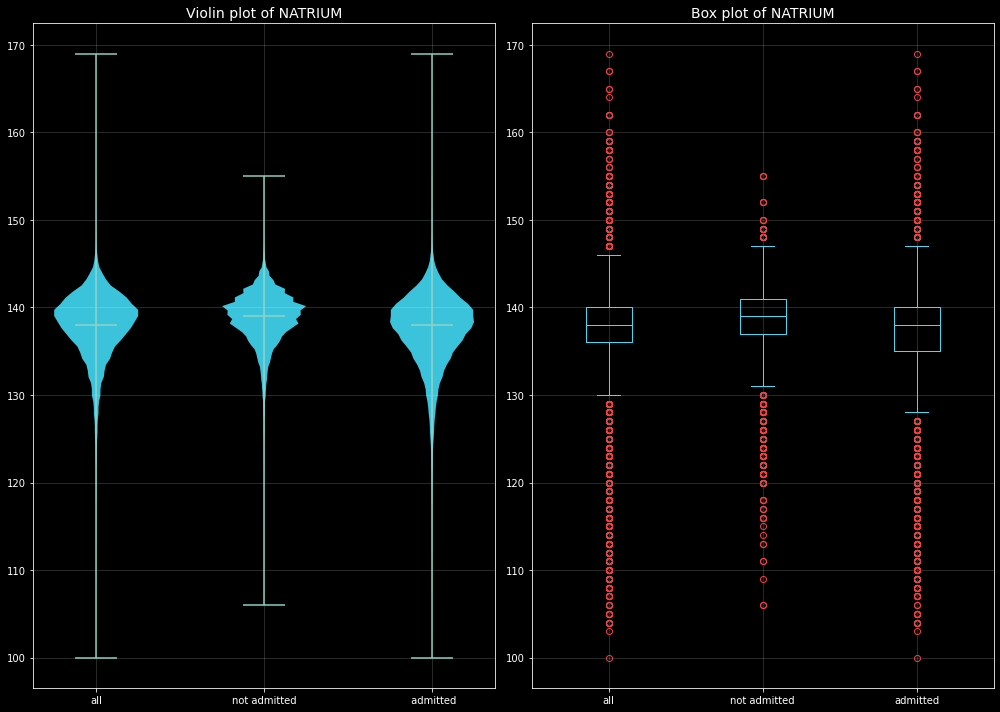

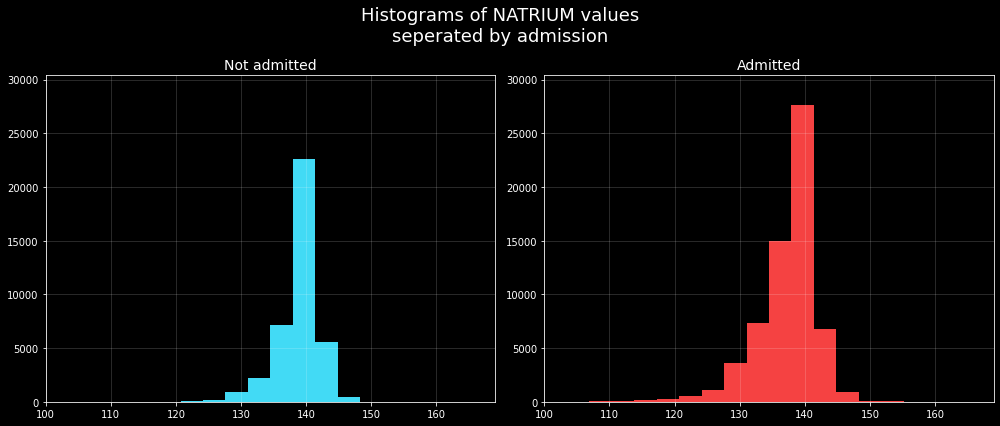

In [742]:
create_distribution_plots(df_natr, 'NATRIUM')
create_histograms(df_natr, 'NATRIUM')

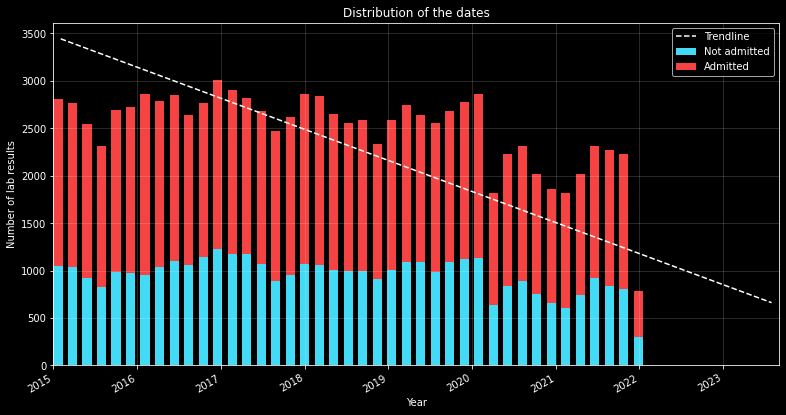

In [743]:
create_date_histogram(df_natr)

In [744]:
df_natr[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.171843
OPNAME  -0.171843  1.000000

In [745]:
df_all = pd.concat([df_all, df_natr])

##### Natrium (ZGT01448 & ZGT01452)

In [746]:
df_natr2 = df[df['BEPCODE'].isin(['ZGT01448', 'ZGT01452'])]
# df_natr2.head()

In [747]:
df_natr2['UITSLAG'].isna().sum()

0

In [748]:
show_non_numeric_counts(df_natr2)

***                 24    
Vervallen monster   11    
<100                2     
total of 37 non numeric values (0.36 %)


In [749]:
df_natr2 = clean_numeric_column(df_natr2, 'UITSLAG')
show_non_numeric_counts(df_natr2)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


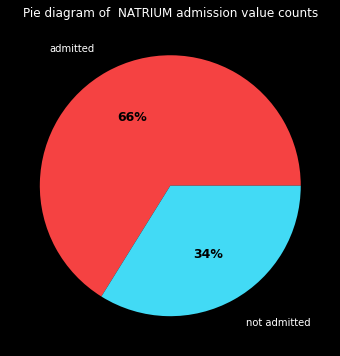

In [750]:
create_pie_diagram(df_natr2, 'NATRIUM')

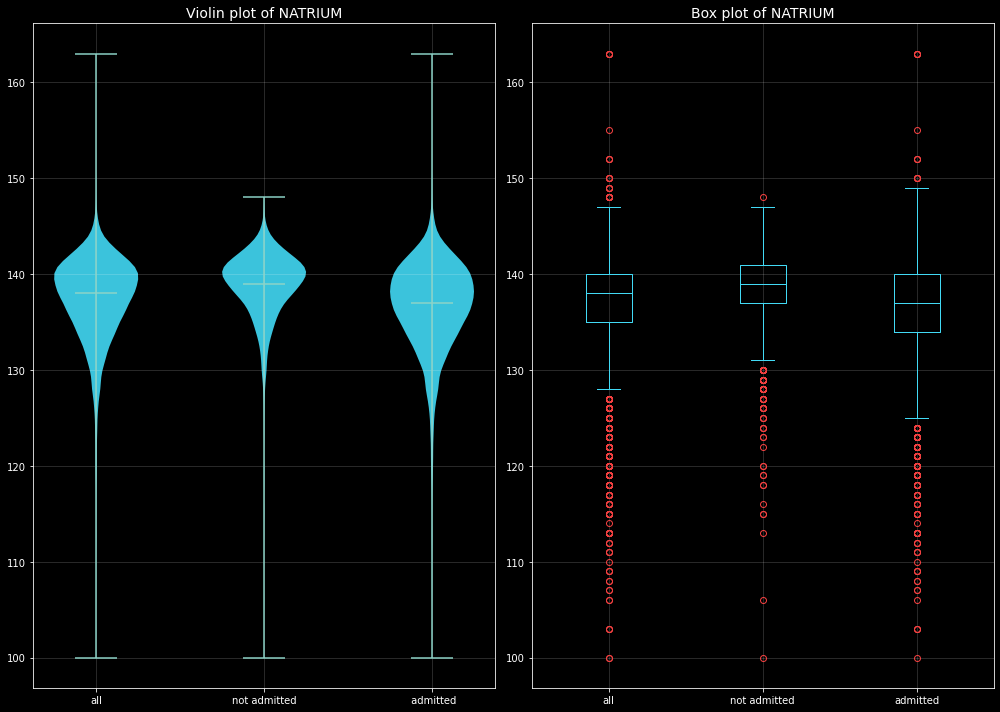

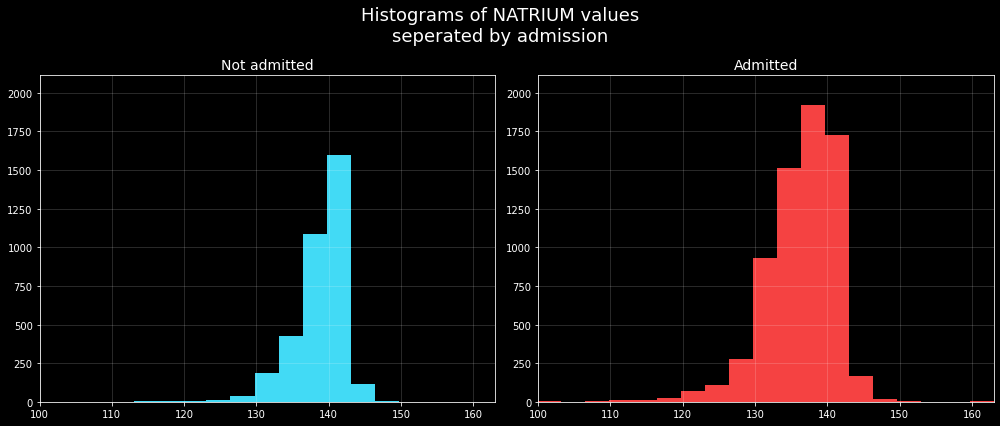

In [751]:
create_distribution_plots(df_natr2, 'NATRIUM')
create_histograms(df_natr2, 'NATRIUM')

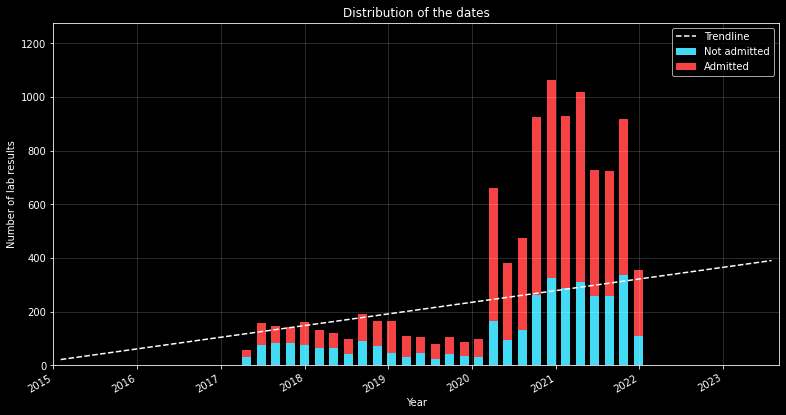

In [752]:
create_date_histogram(df_natr2)

In [753]:
df_natr2[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.229092
OPNAME  -0.229092  1.000000

In [754]:
df_natr2['DESC'] = 'Natrium (POC)'
df_all = pd.concat([df_all, df_natr2])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### KALIUM

Potassium is a critical electrolyte essential for proper muscle and nerve function, including heart function. The normal range of potassium concentration in the blood is typically 3.5 to 5.0 millimoles per liter (mmol/L). Abnormal levels of potassium can have significant effects on heart rhythm, muscle function, and overall bodily health.

In [755]:
print_unique_values_overview('kalium')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Kalium                                   CS000168   102075     90.61    Heparine plasma      mmol/L            
Kalium                                   CS000487   251        0.22     Urine portie         mmol/L            
Kalium                                   @0002671   4          0.00     nan                  mmol/l            
Kalium                                   00003318   2          0.00     nan                  mmol/l            
Kalium                                   @0000554   1          0.00     nan                  mmol/l            
Kalium                                   CS001386   1          0.00     Vocht                mmol/L            
Kalium                                   CS000520   1          0.00     24u Urine            mmol/24 uur       
---------

##### Kalium (CS000168)

In [756]:
df_kalium = df[df['BEPCODE'] == 'CS000168']
# df_kalium.head()

In [757]:
df['UITSLAG'].isna().sum()

0

In [758]:
show_non_numeric_counts(df_kalium)

Vervallen monster   4     
-                   2     
rect                2     
--                  1     
???                 1     
total of 10 non numeric values (0.01 %)


In [759]:
df_kalium = clean_numeric_column(df_kalium, 'UITSLAG')
show_non_numeric_counts(df_kalium)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


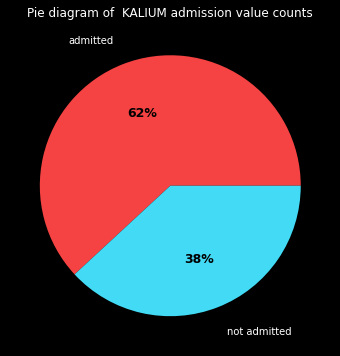

In [760]:
create_pie_diagram(df_kalium, 'KALIUM')

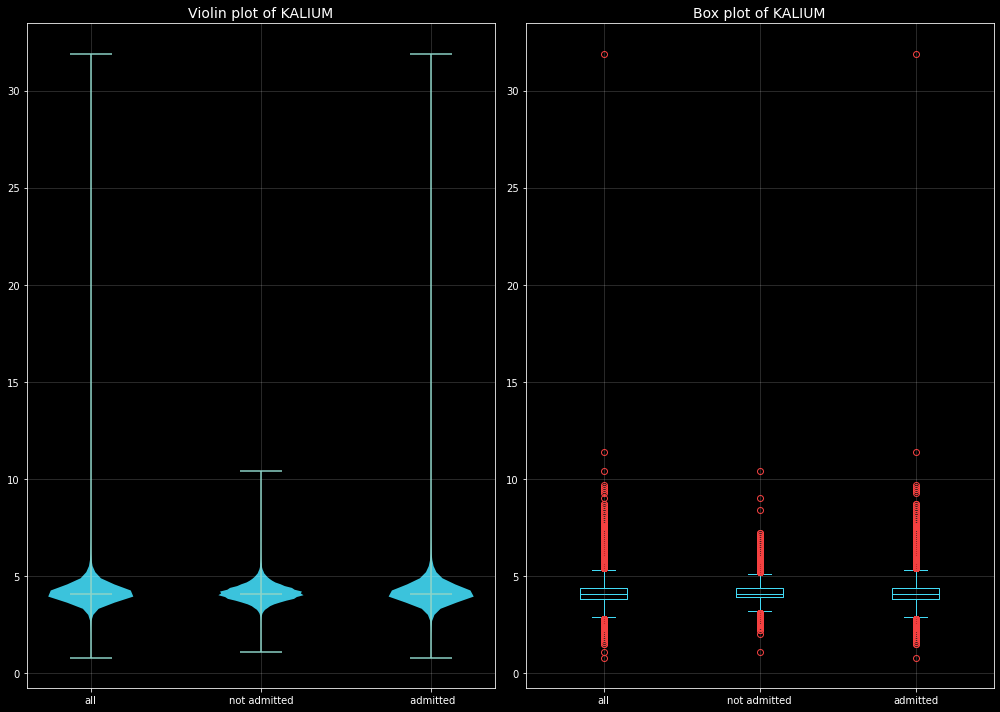

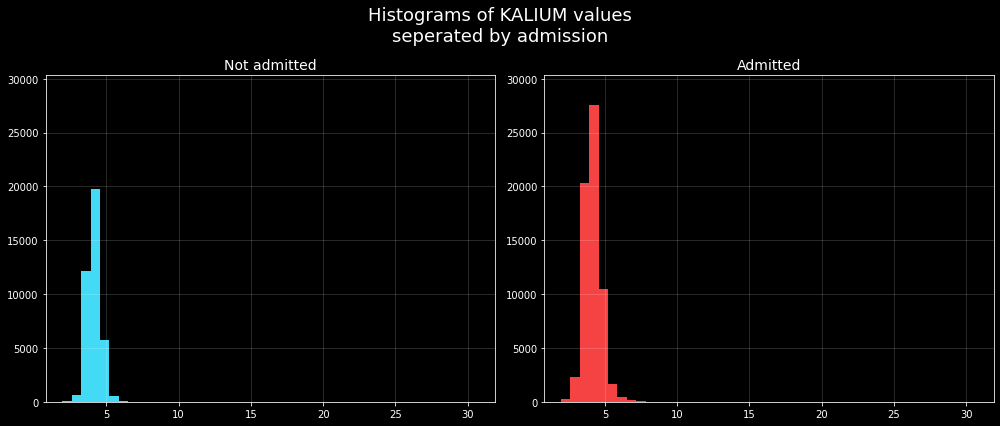

In [761]:
create_distribution_plots(df_kalium, 'KALIUM')
create_histograms(df_kalium, 'KALIUM')

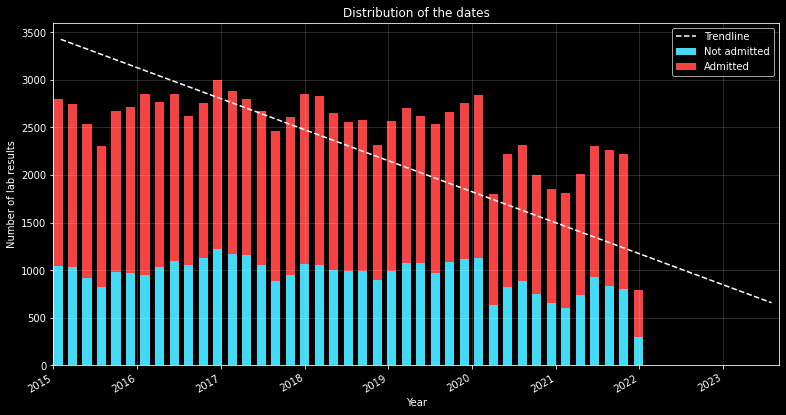

In [762]:
create_date_histogram(df_kalium)

In [763]:
df_kalium[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.006846
OPNAME   0.006846  1.000000

In [764]:
df_all = pd.concat([df_all, df_kalium])

##### Kalium (ZGT01265 & ZGT01264)

In [765]:
df_kalium2 = df[df['BEPCODE'].isin(['ZGT01265', 'ZGT01264'])]
# df_kalium2.head()

In [766]:
df_kalium2['UITSLAG'].isna().sum()

0

In [767]:
show_non_numeric_counts(df_kalium2)

***                 32    
>9.0                18    
Vervallen monster   11    
<2.0                4     
<>                  2     
total of 67 non numeric values (0.65 %)


In [768]:
df_kalium2 = clean_numeric_column(df_kalium2, 'UITSLAG')
show_non_numeric_counts(df_kalium2)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


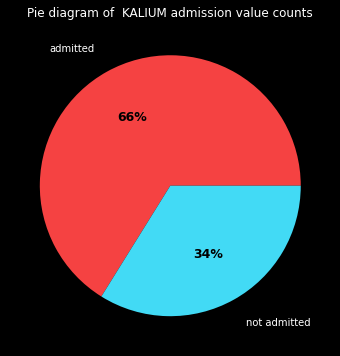

In [769]:
create_pie_diagram(df_kalium2, 'KALIUM')

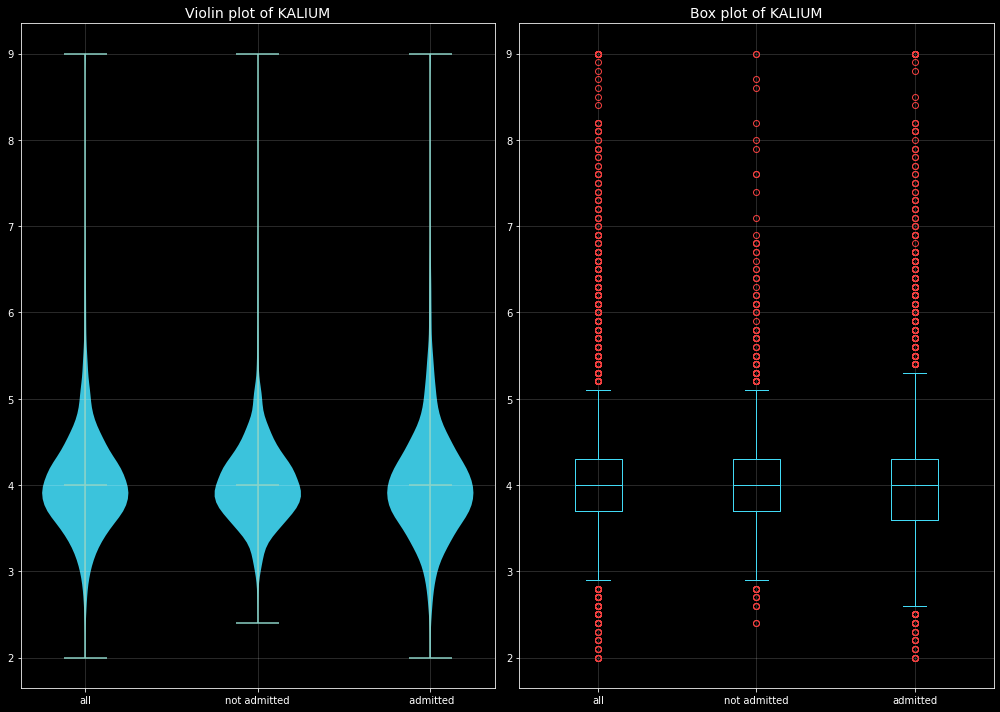

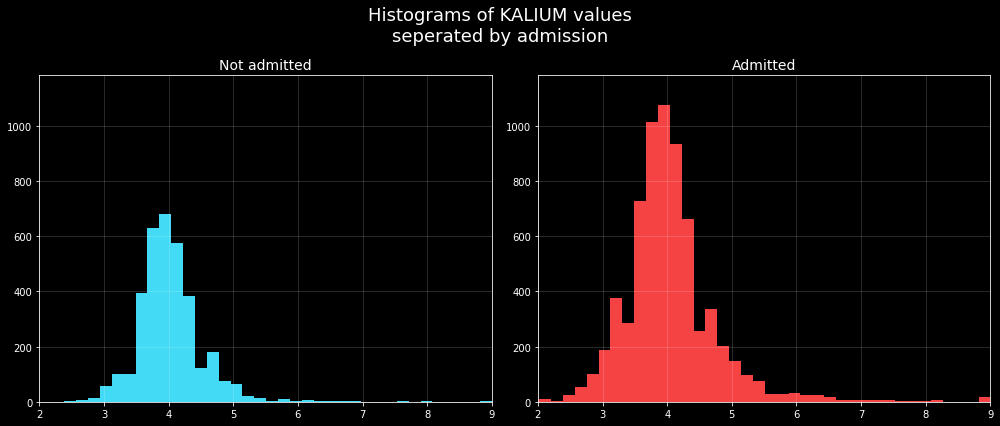

In [770]:
create_distribution_plots(df_kalium2, 'KALIUM')
create_histograms(df_kalium2, 'KALIUM')

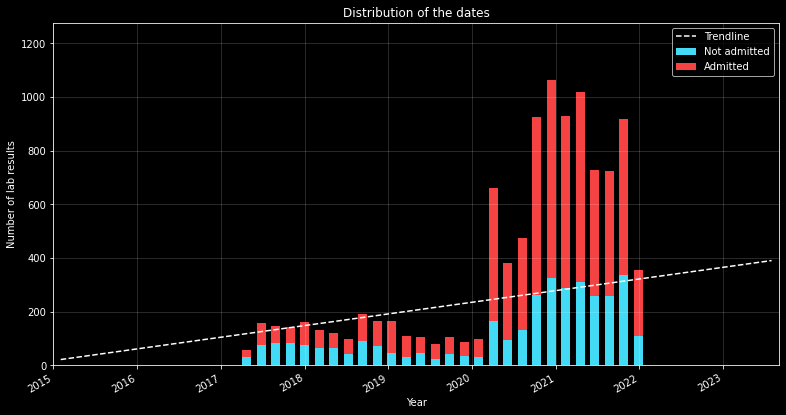

In [771]:
create_date_histogram(df_kalium2)

In [772]:
df_kalium2['DESC'] = 'Kalium (POC)'
df_all = pd.concat([df_all, df_kalium2])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [773]:
df_kalium2[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.008555
OPNAME   0.008555  1.000000

#### ASAT

Aspartate aminotransferase (ASAT), is an enzyme found in various body tissues, particularly the heart and liver. It plays a key role in metabolism. The normal range for ASAT levels in the blood is typically up to 40 units per liter (U/L). Elevated levels of ASAT may indicate liver damage, heart issues, or muscle injury.

In [774]:
print_unique_values_overview('asat')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
ASAT                                     CS000208   88821      100.00   Heparine plasma      U/L               
----------------------------------------------------------------------------------------------------


In [775]:
df_asat = df[df['DESC'] == 'ASAT']
# df_asat.head()

In [776]:
df_asat['UITSLAG'].isna().sum()

0

In [777]:
show_non_numeric_counts(df_asat)

<5                  9     
>7000               7     
???                 2     
rect                2     
-                   1     
*17 U/l             1     
Vervallen monster   1     
total of 23 non numeric values (0.03 %)


In [778]:
df_asat = clean_numeric_column(df_asat, 'UITSLAG')
show_non_numeric_counts(df_asat)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


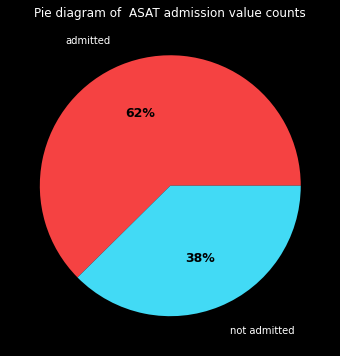

In [779]:
create_pie_diagram(df_asat, 'ASAT')

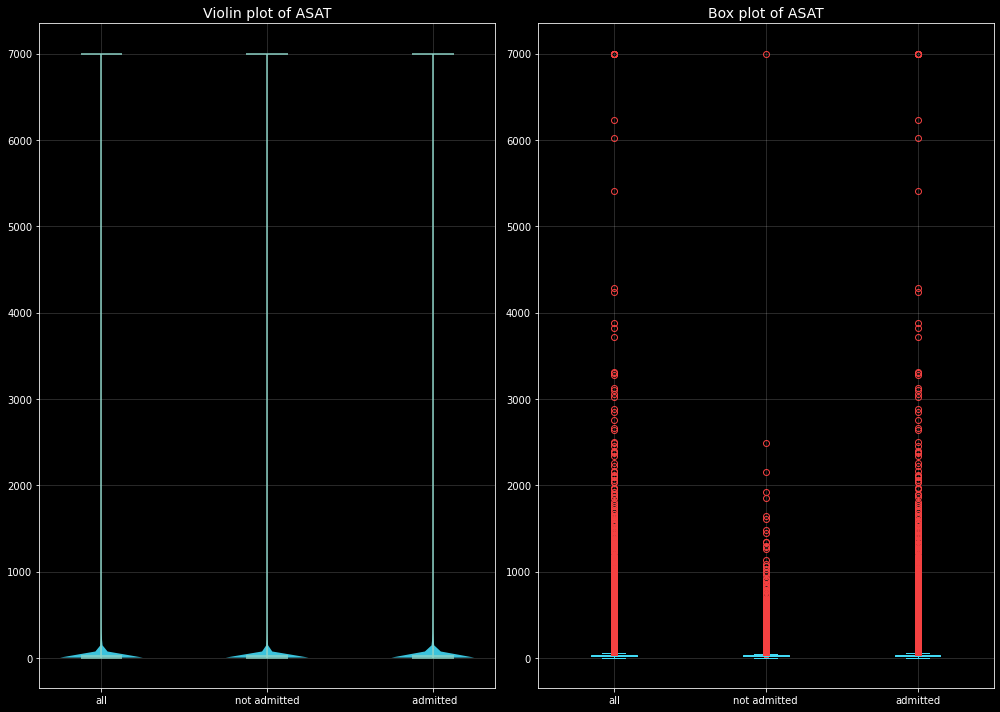

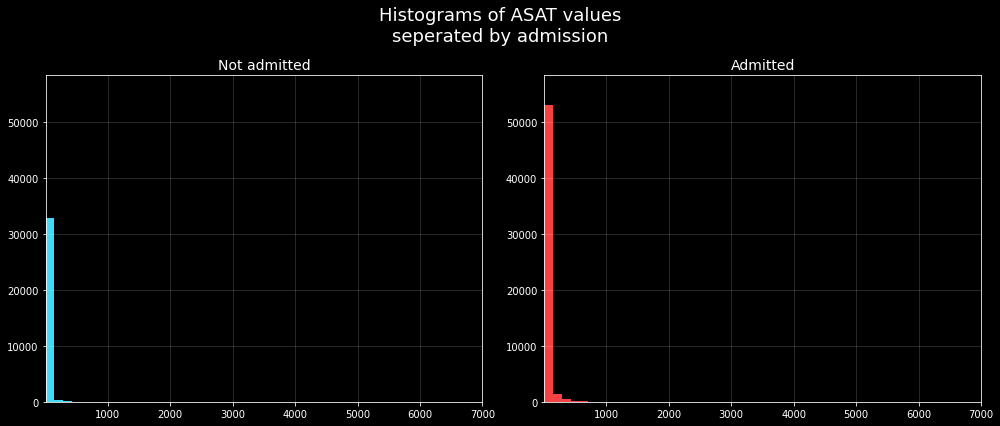

In [780]:
create_distribution_plots(df_asat, 'ASAT')
create_histograms(df_asat, 'ASAT')

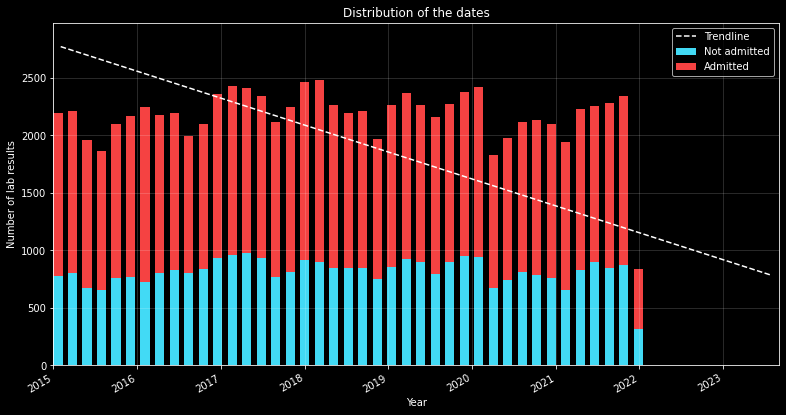

In [781]:
create_date_histogram(df_asat)

In [782]:
df_asat[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.059511
OPNAME   0.059511  1.000000

In [783]:
df_all = pd.concat([df_all, df_asat])

#### ALAT

Alanine aminotransferase (ALAT) is an enzyme present in the liver and other organs. It plays a crucial role in breaking down proteins. The normal range for ALAT levels in the blood is generally up to 56 units per liter (U/L). Elevated ALAT levels can indicate liver damage, potentially due to conditions like hepatitis or other liver disorders.

In [784]:
print_unique_values_overview('alat')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
ALAT                                     CS000211   91707      100.00   Heparine plasma      U/L               
----------------------------------------------------------------------------------------------------


In [785]:
df_alat = df[df['DESC'] == 'ALAT']
# df_alat.head()

In [786]:
df_alat['UITSLAG'].isna().sum()

0

In [787]:
show_non_numeric_counts(df_alat)

<5                  583   
>6600               3     
rect                2     
-                   1     
???                 1     
Vervallen monster   1     
total of 591 non numeric values (0.64 %)


In [788]:
df_alat = clean_numeric_column(df_alat, 'UITSLAG')
show_non_numeric_counts(df_alat)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


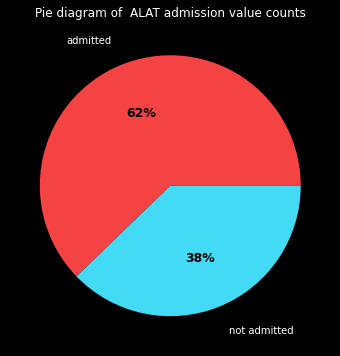

In [789]:
create_pie_diagram(df_alat, 'ALAT')

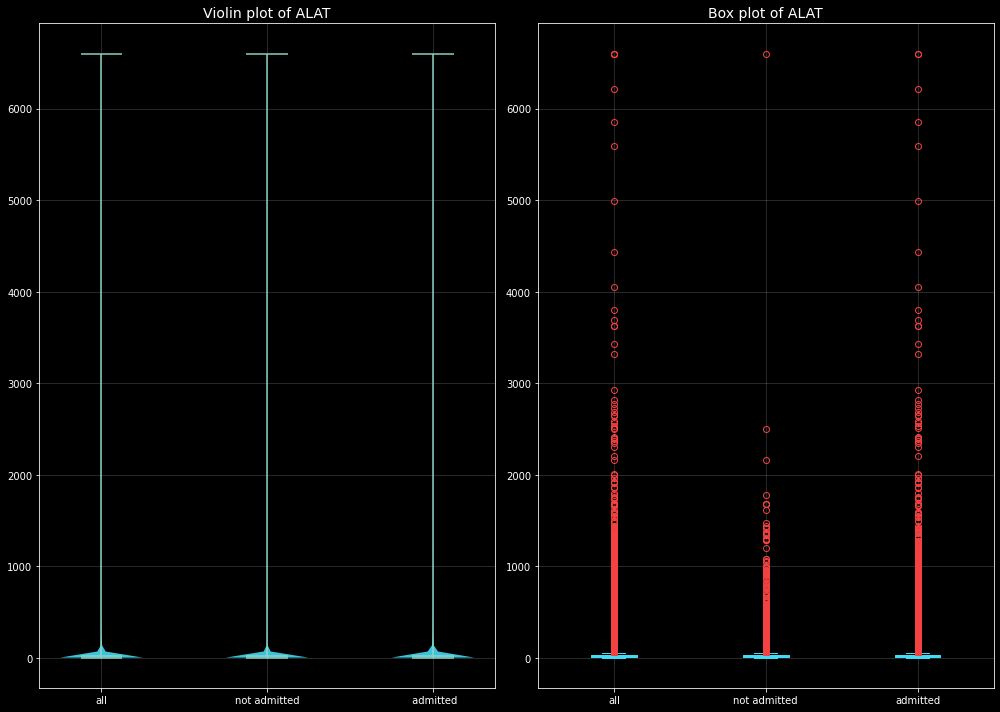

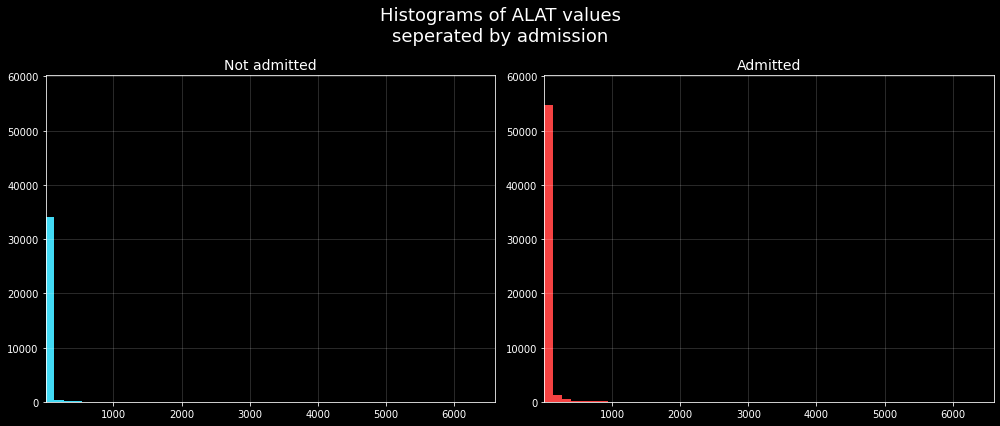

In [790]:
create_distribution_plots(df_alat, 'ALAT')
create_histograms(df_alat, 'ALAT')

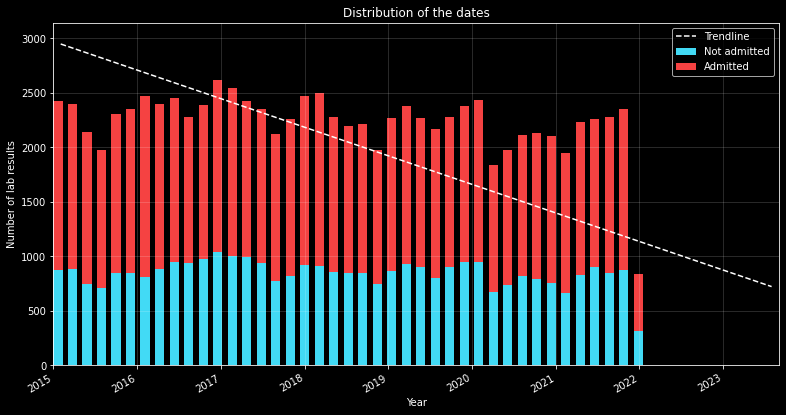

In [791]:
create_date_histogram(df_alat)

In [792]:
df_alat[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.046267
OPNAME   0.046267  1.000000

In [793]:
df_all = pd.concat([df_all, df_alat])

#### ALKALISCHE FOSFATASE

Alkaline phosphatase (ALP or AF) is an enzyme found in various tissues throughout the body, especially in the liver, bones, and digestive system. Its main role is to help break down proteins. The normal range for alkaline phosphatase levels in the blood varies with age and sex but typically falls between 20 to 140 units per liter (U/L) in adults. Elevated ALP levels may suggest liver or bone disorders.

In [794]:
print_unique_values_overview('alkalische fosfatase')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Alkalische Fosfatase                     @0000707   2          0.00     nan                  U/l               
Alkalische Fosfatase                     00003320   1          0.00     nan                  U/l               
----------------------------------------------------------------------------------------------------
Alkalische Fosfatase (AF)                CS000203   93508      99.99    Heparine plasma      U/L               
----------------------------------------------------------------------------------------------------
Alkalische Fosfatase Botfractie          ZGT00049   8          0.01     Serum                U/l               
----------------------------------------------------------------------------------------------------


It seems that 'Alkalische Fosfatase (AF)' hold almost all the data.  
I am only going to use this one AF result.  

In [795]:
df_AF = df[df['DESC'] == 'Alkalische Fosfatase (AF)']
# df_AF.head()

In [796]:
df_AF['UITSLAG'].isna().sum()

0

In [797]:
show_non_numeric_counts(df_AF)

rect                2     
<5                  1     
???                 1     
>4800               1     
Vervallen monster   1     
-                   1     
total of 7 non numeric values (0.01 %)


In [798]:
df_AF = clean_numeric_column(df_AF, 'UITSLAG')
show_non_numeric_counts(df_AF)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


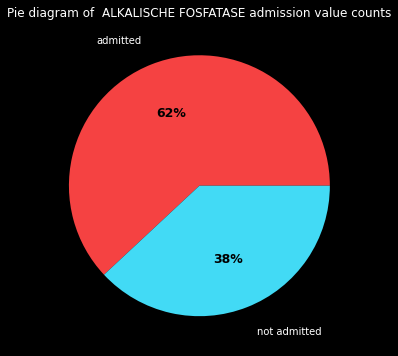

In [799]:
create_pie_diagram(df_AF, 'ALKALISCHE FOSFATASE')

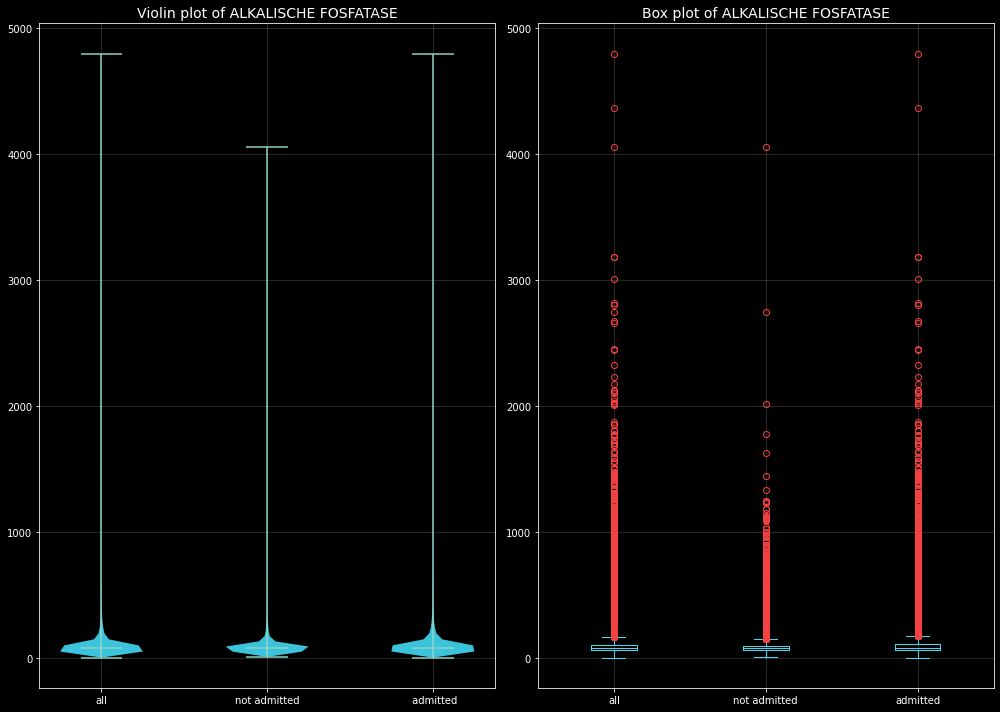

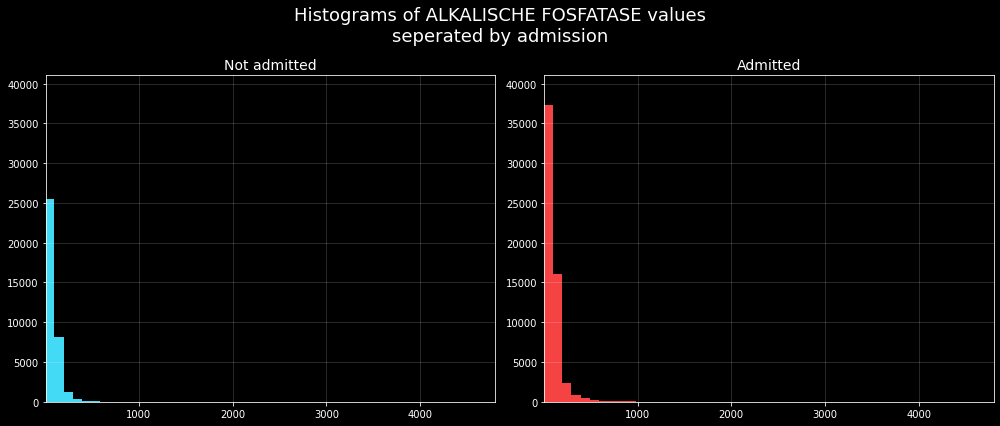

In [800]:
create_distribution_plots(df_AF, 'ALKALISCHE FOSFATASE')
create_histograms(df_AF, 'ALKALISCHE FOSFATASE')

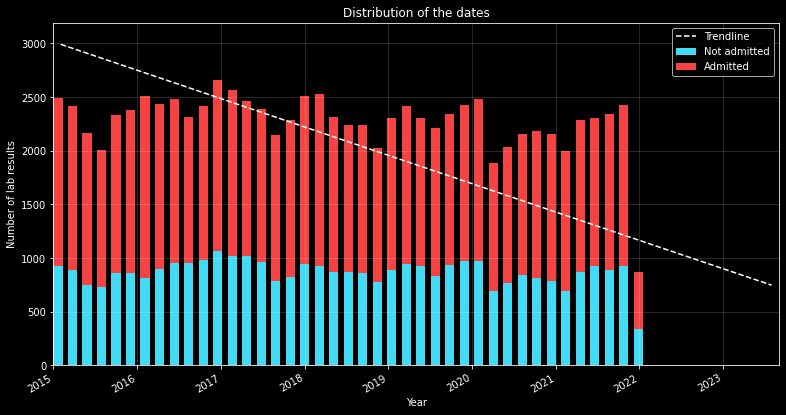

In [801]:
create_date_histogram(df_AF)

In [802]:
df_AF[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.066665
OPNAME   0.066665  1.000000

In [803]:
df_all = pd.concat([df_all, df_AF])

#### GAMMA GT

Gamma-glutamyl transferase (GGT) is an enzyme found in the liver, bile ducts, and other organs. It is important for breaking down chemicals in the body, particularly the liver. The normal range for GGT levels in the blood varies based on factors such as age and sex, but it is typically up to 60 units per liter (U/L) for men and up to 40 U/L for women. Elevated GGT levels may indicate liver or bile duct issues, alcohol abuse, or certain medications.

In [804]:
print_unique_values_overview('GGT')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
GGT                                      CS000205   92184      100.00   Heparine plasma      U/L               
----------------------------------------------------------------------------------------------------


In [805]:
df_ggt = df[df['DESC'] == 'GGT']
# df_ggt.head()

In [806]:
df_ggt['UITSLAG'].isna().sum()

0

In [807]:
show_non_numeric_counts(df_ggt)

<3                  12    
rect                2     
-                   1     
Vervallen monster   1     
???                 1     
total of 17 non numeric values (0.02 %)


In [808]:
df_ggt = clean_numeric_column(df_ggt, 'UITSLAG')
show_non_numeric_counts(df_ggt)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


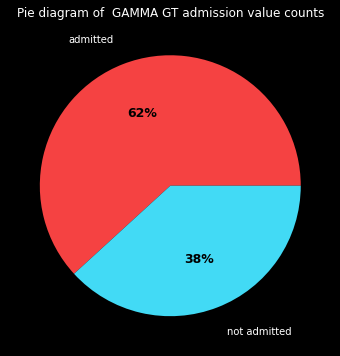

In [809]:
create_pie_diagram(df_ggt, 'GAMMA GT')

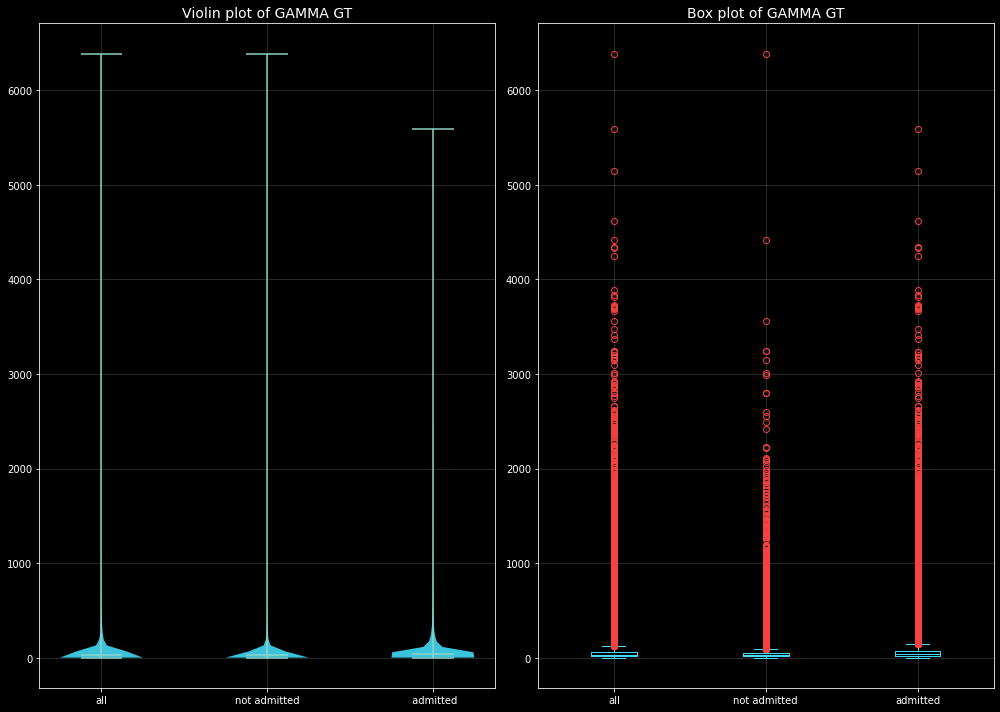

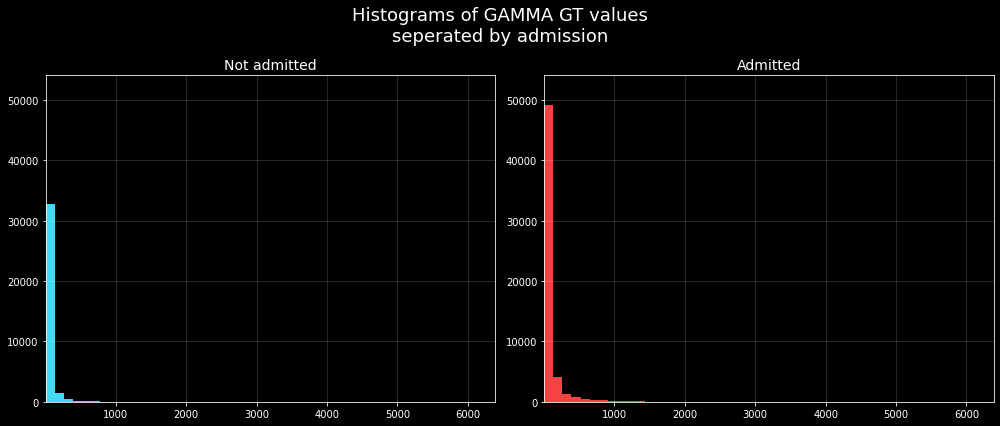

In [810]:
create_distribution_plots(df_ggt, 'GAMMA GT')
create_histograms(df_ggt, 'GAMMA GT')

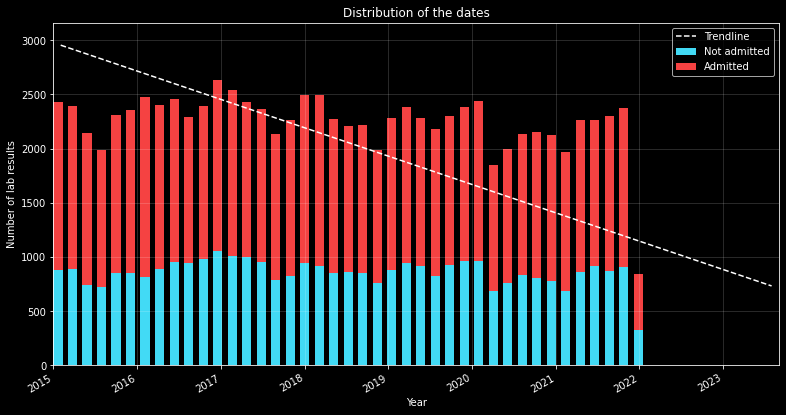

In [811]:
create_date_histogram(df_ggt)

In [812]:
df_ggt[['UITSLAG', 'OPNAME']].corr()

UITSLAG   OPNAME
UITSLAG  1.00000  0.08899
OPNAME   0.08899  1.00000

In [813]:
df_all = pd.concat([df_all, df_ggt])

#### LDH

Lactate dehydrogenase (LDH) is an enzyme found in various tissues in the body, including the heart, liver, muscles, and red blood cells. It plays a role in converting lactate to pyruvate during energy production. The normal range for LDH levels in the blood is typically up to 225 units per liter (U/L), though this can vary slightly based on the specific laboratory's reference values. Elevated LDH levels may be indicative of tissue damage or certain medical conditions such as heart or liver disease, anemia, or muscle injury.

In [814]:
print_unique_values_overview('^ld')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
LD                                       CS000214   68702      100.00   Heparine plasma      U/L               
LD                                       @0002729   2          0.00     nan                  U/l               
LD                                       00003321   1          0.00     nan                  U/l               
----------------------------------------------------------------------------------------------------


In [815]:
df_ldh = df[df['BEPCODE'] == 'CS000214']
# df_ldh.head()

In [816]:
df_ldh['UITSLAG'].isna().sum()

0

In [817]:
show_non_numeric_counts(df_ldh)

>10000              6     
rect                2     
Vervallen monster   1     
total of 9 non numeric values (0.01 %)


In [818]:
df_ldh = clean_numeric_column(df_ldh, 'UITSLAG')
show_non_numeric_counts(df_ldh)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


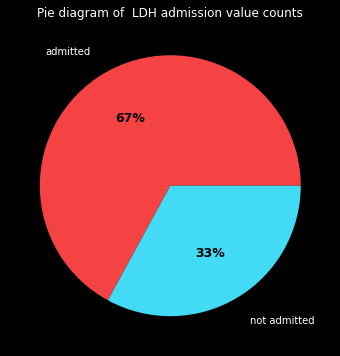

In [819]:
create_pie_diagram(df_ldh, 'LDH')

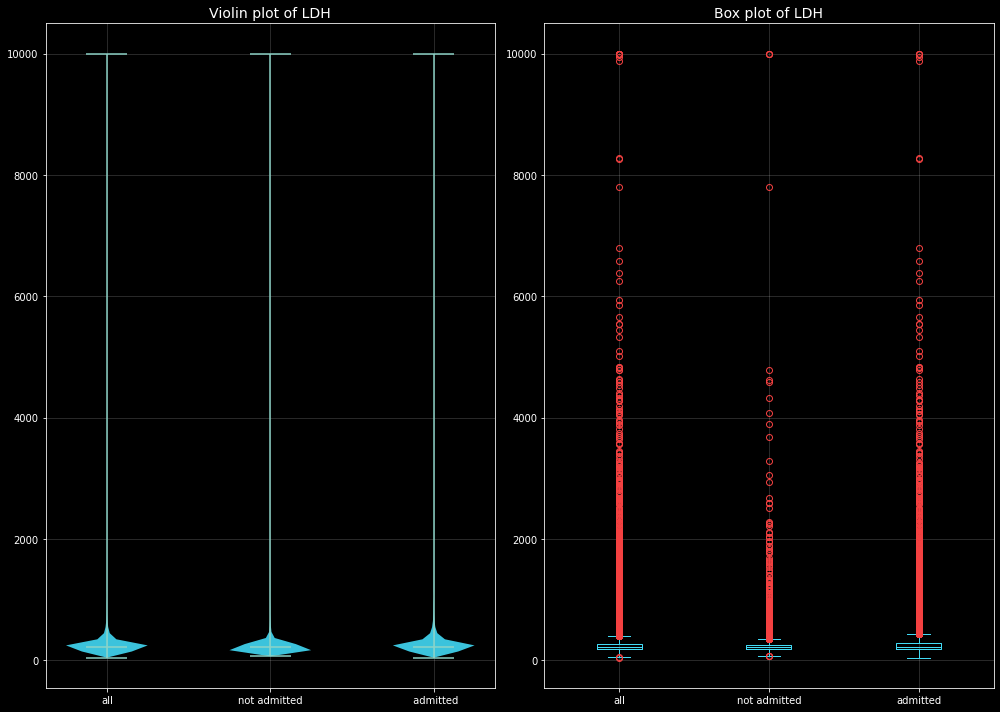

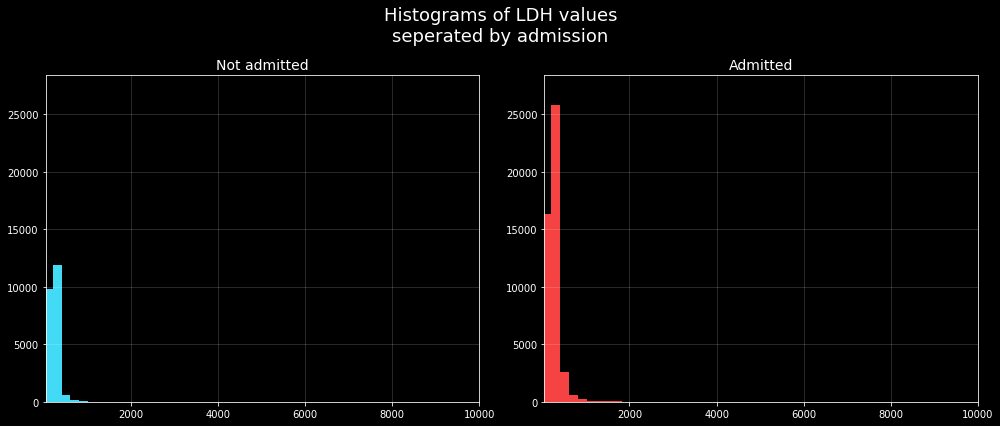

In [820]:
create_distribution_plots(df_ldh, 'LDH')
create_histograms(df_ldh, 'LDH')

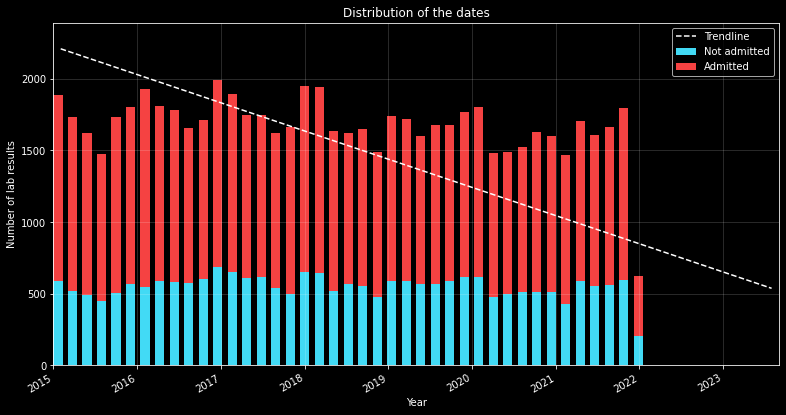

In [821]:
create_date_histogram(df_ldh)

In [822]:
df_ldh[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.070034
OPNAME   0.070034  1.000000

In [823]:
df_all = pd.concat([df_all, df_ldh])

#### GLUCOSE

Glucose is a type of sugar and a primary source of energy for the body's cells. The normal range for fasting blood glucose levels (measured after not eating for about 8 hours) is usually between 3.9 to 5.6 mmol/L. However, specific reference ranges may vary slightly based on the laboratory and the methods used for measurement. Elevated glucose levels may indicate diabetes or impaired glucose tolerance, necessitating further medical evaluation and testing. Low glucose levels can indicate hypoglycemia, which can cause symptoms like dizziness, confusion, and weakness

In [824]:
print_unique_values_overview('glucose(?!.*\d)') 

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Glucose                                  CS003765   42509      24.10    Urine portie         mmol/L            
Glucose                                  CS000251   1779       1.01     Heparine plasma      mmol/L            
Glucose                                  CS000559   611        0.35     Liquor               mmol/L            
Glucose                                  00003322   1          0.00     nan                  mmol/l            
Glucose                                  @0000403   1          0.00     nan                  mmol/l            
Glucose                                  CS000573   1          0.00     Vocht                mmol/L            
----------------------------------------------------------------------------------------------------
Glucose (POC)       

##### Glucose (@0002464 & CS000251)

In [825]:
df_glucose = df[df['BEPCODE'].isin(['@0002464', 'CS000251'])]

In [826]:
df_glucose['UITSLAG'].isna().sum()

0

In [827]:
show_non_numeric_counts(df_glucose)

-                   2     
???                 2     
rect                2     
Vervallen monster   1     
<0.1                1     
total of 8 non numeric values (0.01 %)


In [828]:
df_glucose = clean_numeric_column(df_glucose, 'UITSLAG')
show_non_numeric_counts(df_glucose)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


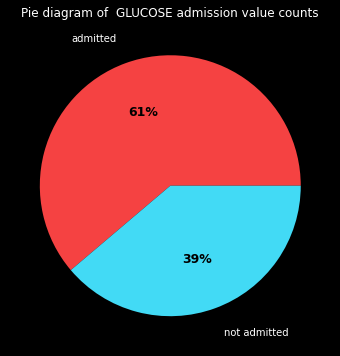

In [829]:
create_pie_diagram(df_glucose, 'GLUCOSE')

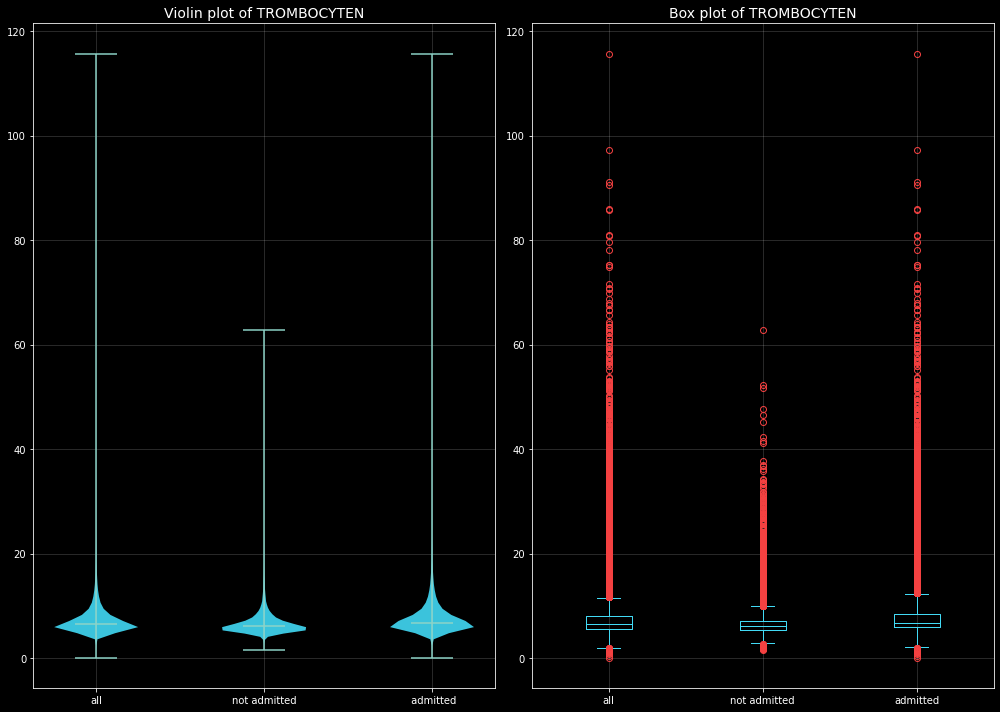

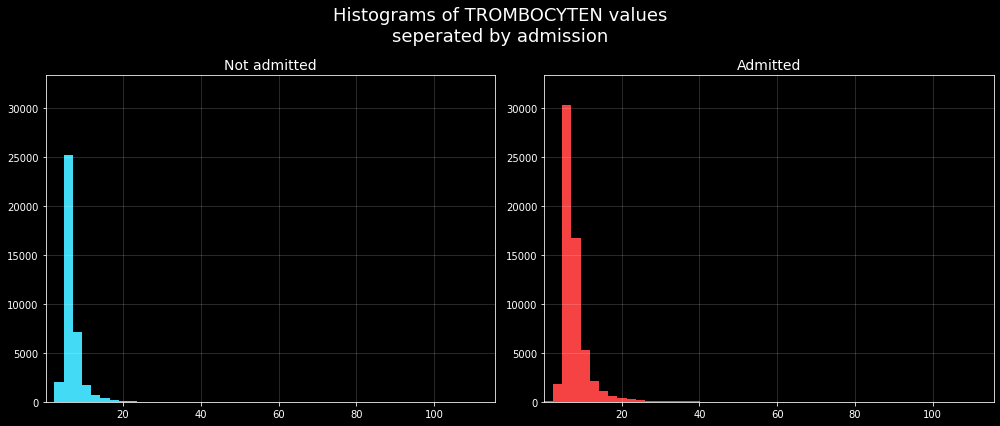

In [830]:
create_distribution_plots(df_glucose, 'TROMBOCYTEN')
create_histograms(df_glucose, 'TROMBOCYTEN')

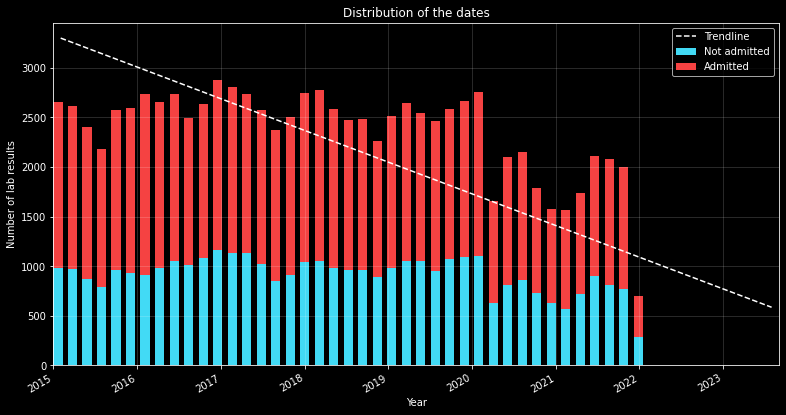

In [831]:
create_date_histogram(df_glucose)

In [832]:
df_glucose[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.148159
OPNAME   0.148159  1.000000

In [833]:
df_all = pd.concat([df_all, df_glucose])

##### Glucose (CS000267 & CS002485)

In [834]:
df_glucose_poc = df[df['BEPCODE'].isin(['CS000267', 'CS002485'])]
# df_glucose_poc.head()

In [835]:
df_glucose_poc['UITSLAG'].isna().sum()

0

In [836]:
show_non_numeric_counts(df_glucose_poc)

>33.0               74    
>30.0               40    
>38.0               30    
***                 28    
<2.0                18    
<1.1                1     
Vervallen monster   1     
<1.0                1     
total of 193 non numeric values (0.93 %)


In [837]:
df_glucose_poc = clean_numeric_column(df_glucose_poc, 'UITSLAG')
show_non_numeric_counts(df_glucose_poc)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


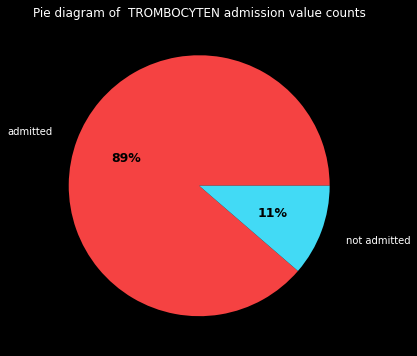

In [838]:
create_pie_diagram(df_glucose_poc, 'TROMBOCYTEN')

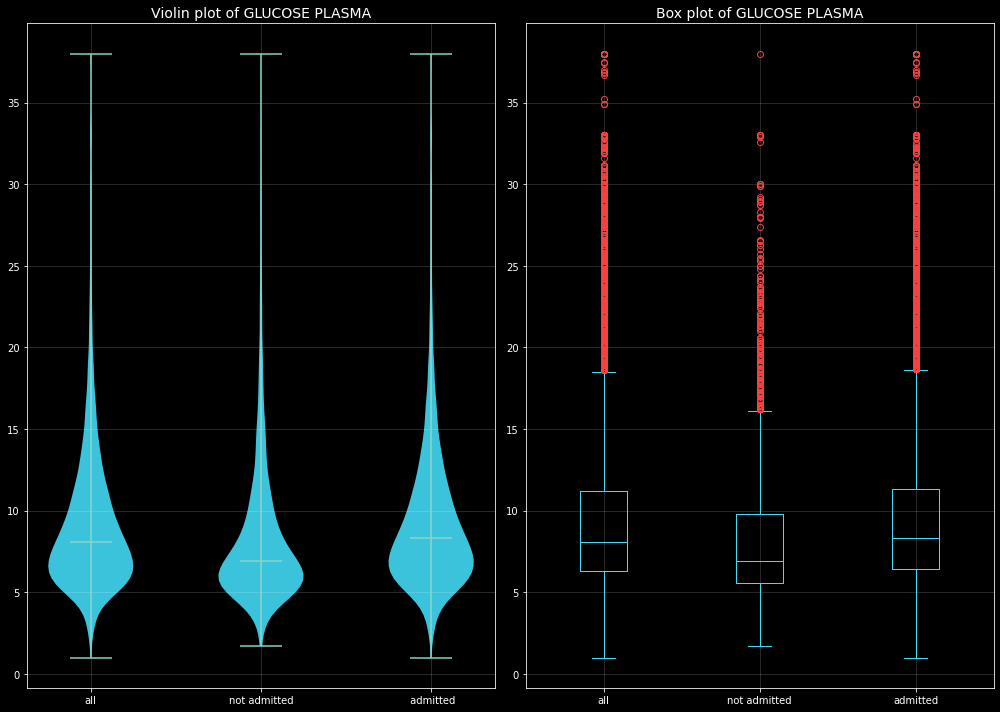

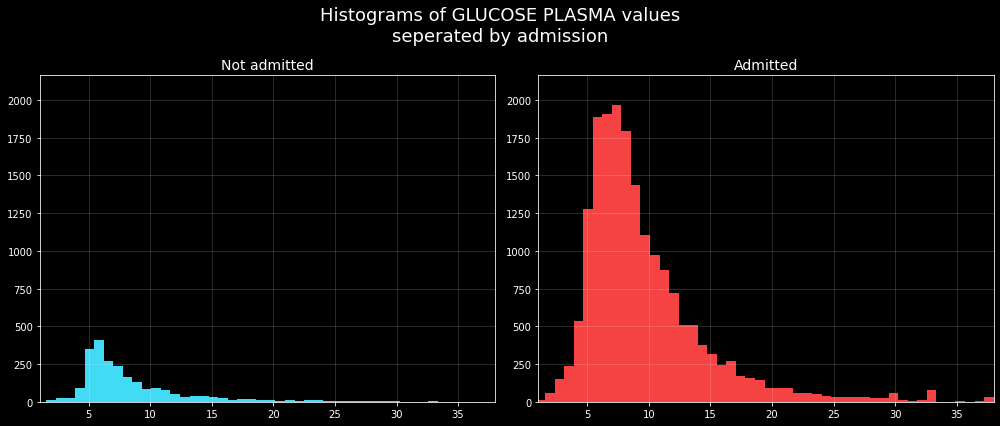

In [839]:
create_distribution_plots(df_glucose_poc, 'GLUCOSE PLASMA')
create_histograms(df_glucose_poc, 'GLUCOSE PLASMA')

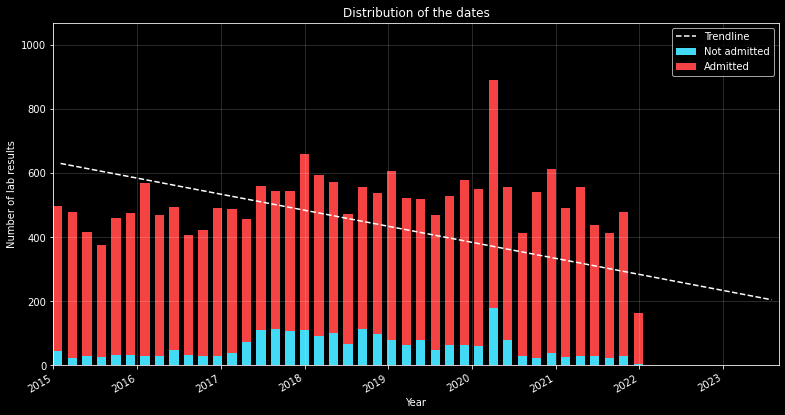

In [840]:
create_date_histogram(df_glucose_poc)

In [841]:
df_glucose_poc[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.068472
OPNAME   0.068472  1.000000

In [842]:
df_glucose_poc['DESC'] = 'Glucose (POC)'
df_all = pd.concat([df_all, df_glucose_poc])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##### Glucose (CS003765)

In [843]:
df_glucose3 = df[df['BEPCODE'] == 'CS003765']
# df_glucose3.head()

In [844]:
df_glucose3['UITSLAG'].isna().sum()

0

In [845]:
show_non_numeric_counts(df_glucose3)

negatief            38337 
>20                 1696  
5-20                1375  
<5                  1075  
Vervallen monster   23    
-                   2     
rect                1     
total of 42509 non numeric values (100.00 %)


In [846]:
df_glucose3 = handle_numeric_category_column(df_glucose3, 'UITSLAG')
show_non_numeric_counts(df_glucose3)

to clean_numeric


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


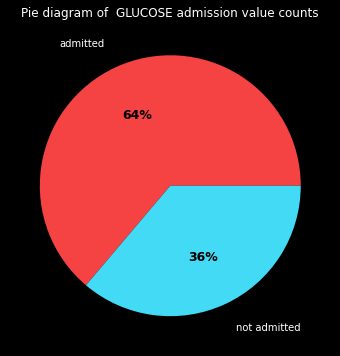

In [847]:
create_pie_diagram(df_glucose3, 'GLUCOSE')

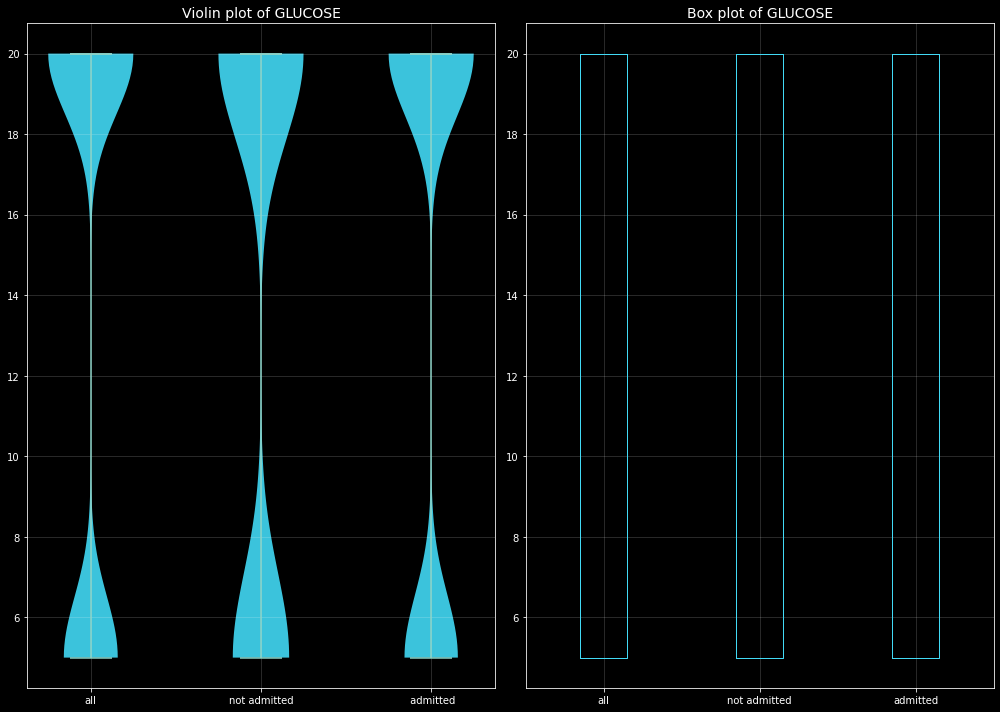

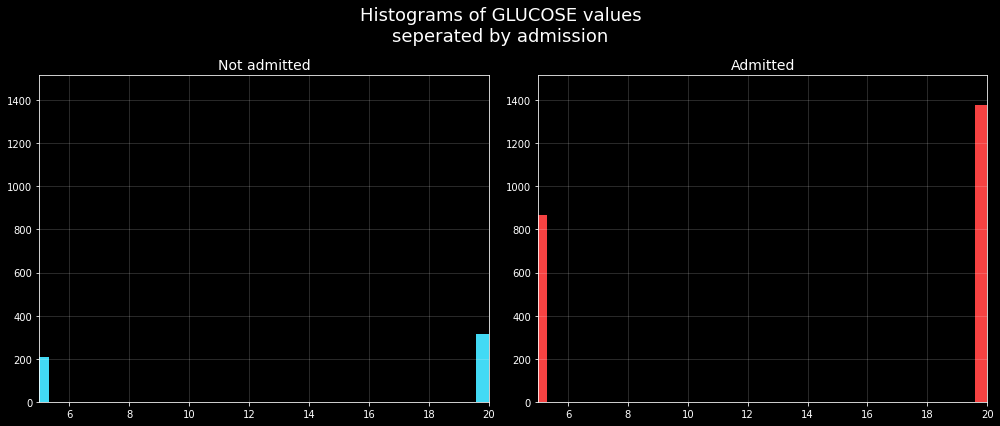

In [848]:
create_distribution_plots(df_glucose3, 'GLUCOSE')
create_histograms(df_glucose3, 'GLUCOSE')

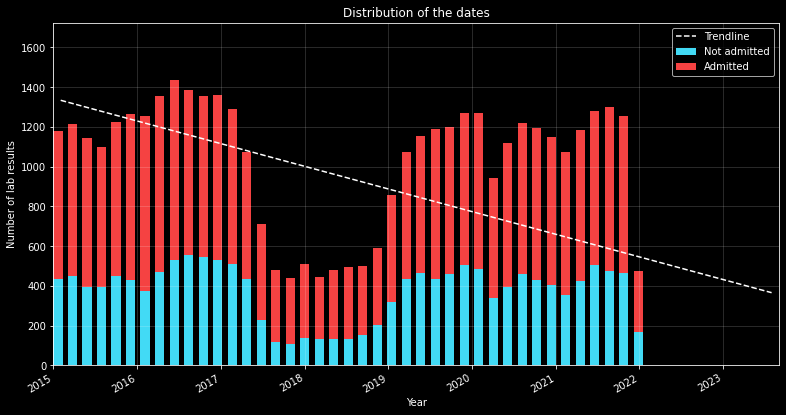

In [849]:
create_date_histogram(df_glucose3)

In [850]:
df_glucose3[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.010478
OPNAME   0.010478  1.000000

In [851]:
df_all = pd.concat([df_all, df_glucose3])

#### TROMBOCYTEN

Thrombocytes are small blood cells crucial for clot formation, preventing excessive bleeding. The normal platelet count in blood ranges from 150,000 to 450,000 platelets per microliter. Abnormal levels, either high (thrombocytosis) or low (thrombocytopenia), may signal potential clotting or bleeding issues, requiring medical evaluation. Monitoring platelet counts is essential for assessing clotting abilities and managing related health conditions.

In [852]:
print_unique_values_overview('tromb')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Dyspl. kenmerken trombocyten             ZGT00232   3          0.00     EDTA bloed           nan               
----------------------------------------------------------------------------------------------------
Trombocyten                              CS000009   96296      99.76    EDTA bloed           x10^9/L           
Trombocyten                              @0003694   3          0.00     nan                  10^9/l            
Trombocyten                              00003312   1          0.00     nan                  10^9/l            
----------------------------------------------------------------------------------------------------
Trombocyten antistof  IgG                ZGT00642   2          0.00     EDTA bloed           nan               
-------------------------------

It seems that most of the data of the trombocytes has BEPCODE CS000009.

In [853]:
df_tromb = df[df['BEPCODE'] == 'CS000009']
# df_tromb.head()

In [854]:
df_tromb['UITSLAG'].isna().sum()

0

In [855]:
show_non_numeric_counts(df_tromb)

<5                  57    
-                   6     
Vervallen monster   5     
rect                1     
total of 69 non numeric values (0.07 %)


In [856]:
df_tromb = clean_numeric_column(df_tromb, 'UITSLAG')
show_non_numeric_counts(df_tromb)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


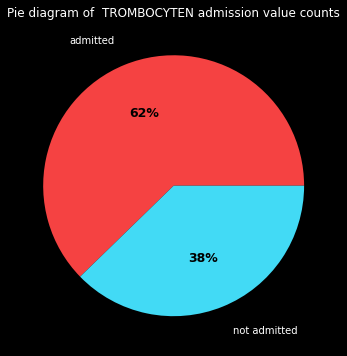

In [857]:
create_pie_diagram(df_tromb, 'TROMBOCYTEN')

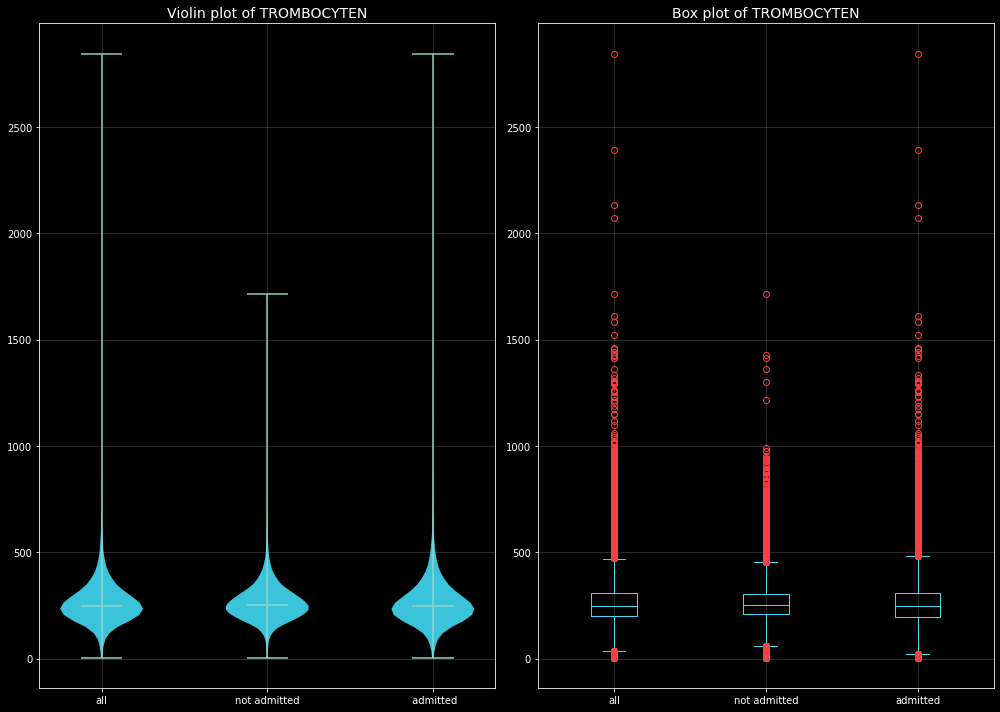

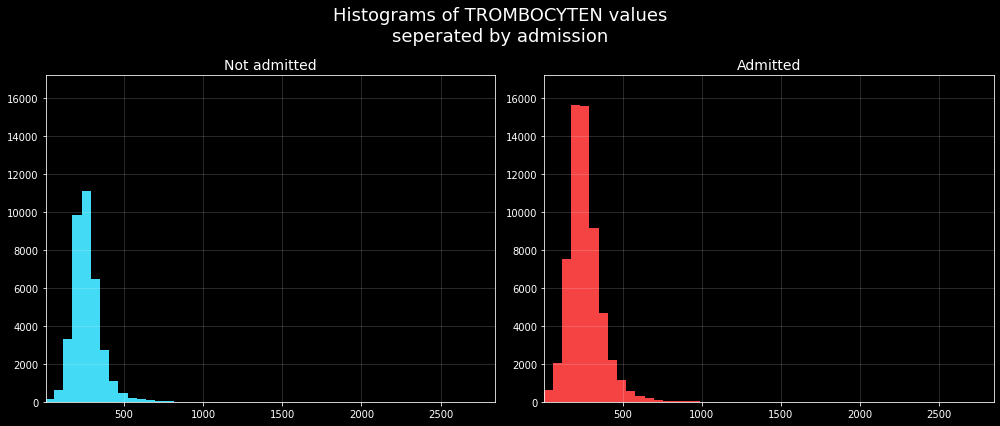

In [858]:
create_distribution_plots(df_tromb, 'TROMBOCYTEN')
create_histograms(df_tromb, 'TROMBOCYTEN')

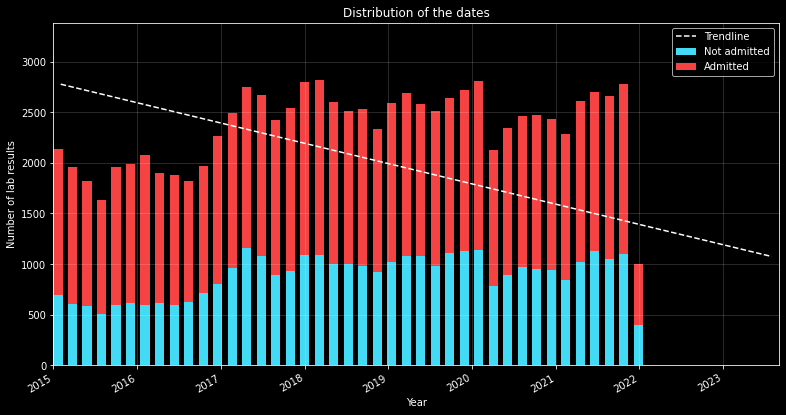

In [859]:
create_date_histogram(df_tromb)

In [860]:
df_tromb[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.014944
OPNAME  -0.014944  1.000000

In [861]:
df_all = pd.concat([df_all, df_tromb])

#### LEUKOCYTEN

Leukocytes, also known as white blood cells, are essential for the immune system and fighting infections. The normal range for white blood cell count is usually between 4,000 to 11,000 cells per microliter of blood. Abnormal levels, either high (leukocytosis) or low (leukopenia), may suggest infections, immune disorders, or other medical conditions, prompting further medical evaluation and necessary treatments. Monitoring white blood cell count is vital for assessing immune health and diagnosing potential illnesses.

In [862]:
print_unique_values_overview('leu[ck]ocyten')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Leucocyten                               CS000013   111964     68.60    EDTA bloed           x10^9/L           
----------------------------------------------------------------------------------------------------
Leucocyten Urine (POC)                   00003108   2          0.00     nan                  AE                
----------------------------------------------------------------------------------------------------
Leukocyten                               CS003762   42531      26.06    Urine portie         /µL               
Leukocyten                               @0002741   3          0.00     nan                  10^9/l            
Leukocyten                               00003313   1          0.00     nan                  10^9/l            
-------------------------------

##### Leucocyten bloed (CS000013)

In [863]:
df_leuco = df[df['BEPCODE'] == 'CS000013']
# df_leuco.head()

In [864]:
df_leuco['UITSLAG'].isna().sum()

0

In [865]:
show_non_numeric_counts(df_leuco)

Vervallen monster   7     
-                   4     
<0.1                4     
rect                1     
total of 16 non numeric values (0.01 %)


In [866]:
df_leuco = clean_numeric_column(df_leuco, 'UITSLAG')
show_non_numeric_counts(df_leuco)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


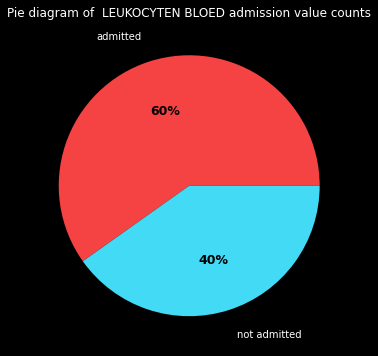

In [867]:
create_pie_diagram(df_leuco, 'LEUKOCYTEN BLOED')

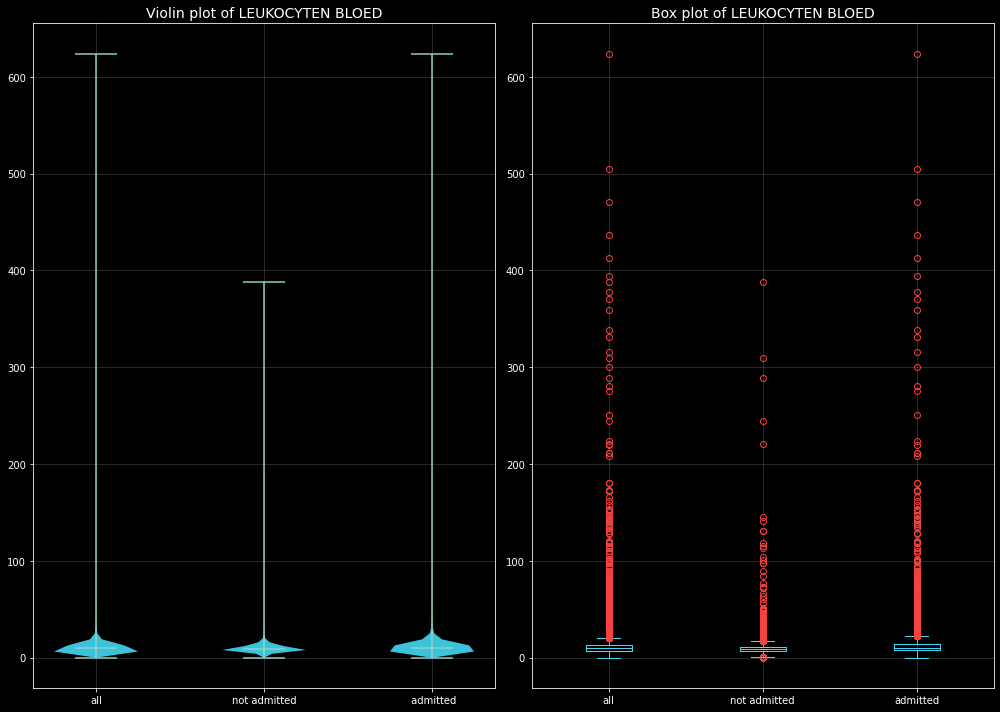

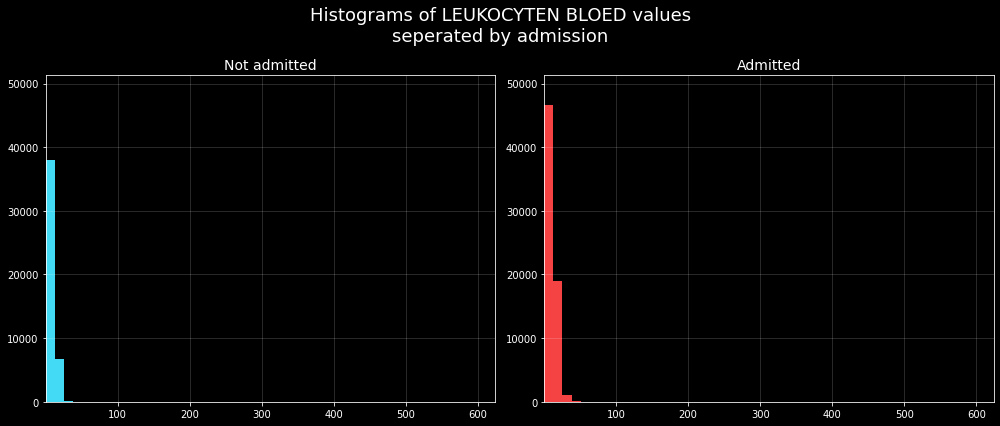

In [868]:
create_distribution_plots(df_leuco, 'LEUKOCYTEN BLOED')
create_histograms(df_leuco, 'LEUKOCYTEN BLOED')

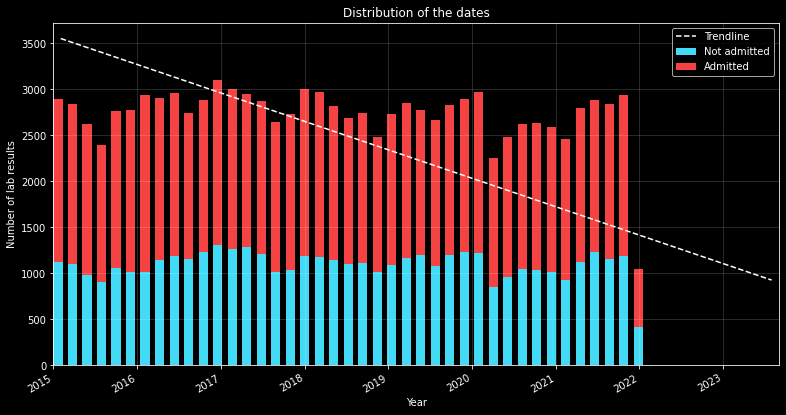

In [869]:
create_date_histogram(df_leuco)

In [870]:
df_leuco[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.120017
OPNAME   0.120017  1.000000

In [871]:
df_leuco['DESC'] = 'Leukocyten (Bloed)' 
df_all = pd.concat([df_all, df_leuco])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##### Leucocyten urine (CS003762)

In [872]:
df_leuco2 = df[df['BEPCODE'] == 'CS003762']
# df_leuco2.head()

In [873]:
df_leuco2['UITSLAG'].isna().sum()

0

In [874]:
show_non_numeric_counts(df_leuco2) #

<10                 14090 
10 - 50             12717 
>150                10493 
50 - 150            5205  
Vervallen monster   23    
-                   2     
rect                1     
total of 42531 non numeric values (100.00 %)


In [875]:
df_leuco2 = handle_numeric_category_column(df_leuco2, 'UITSLAG')
show_non_numeric_counts(df_leuco2)

to clean_numeric


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


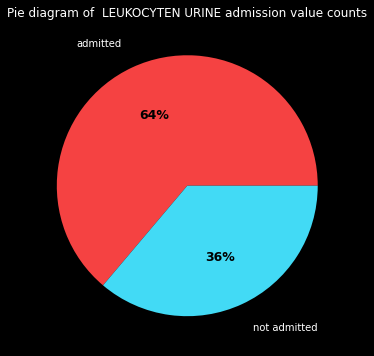

In [876]:
create_pie_diagram(df_leuco2, 'LEUKOCYTEN URINE')

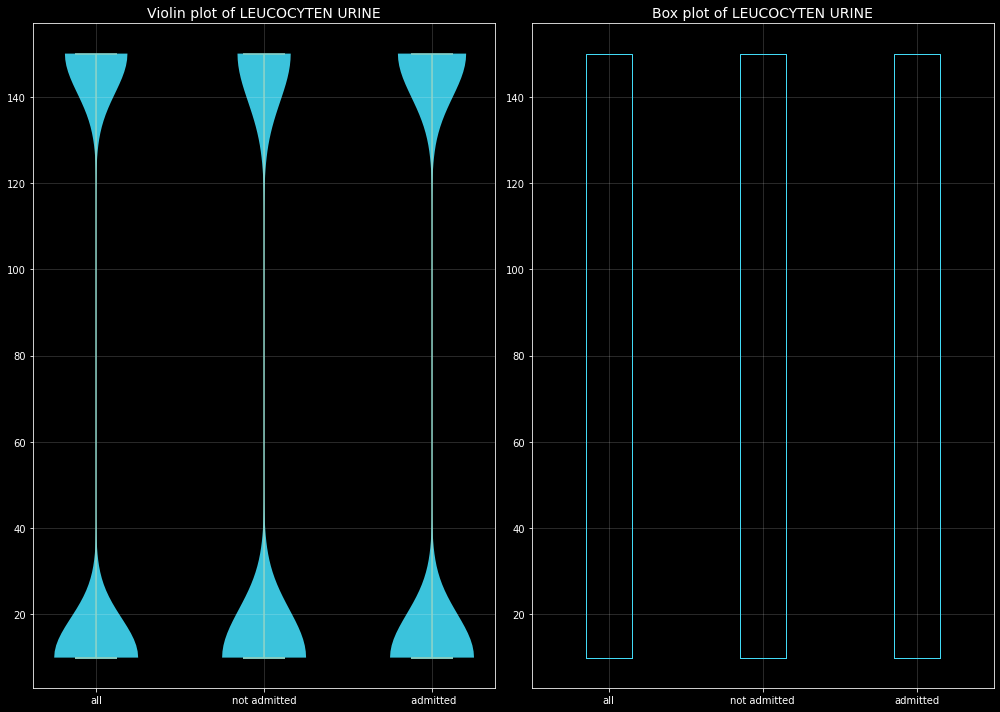

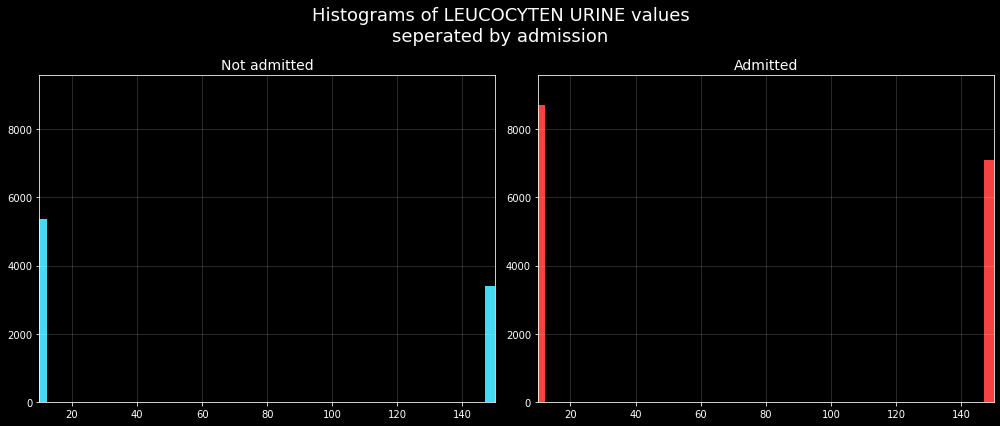

In [877]:
create_distribution_plots(df_leuco2, 'LEUCOCYTEN URINE')
create_histograms(df_leuco2, 'LEUCOCYTEN URINE')

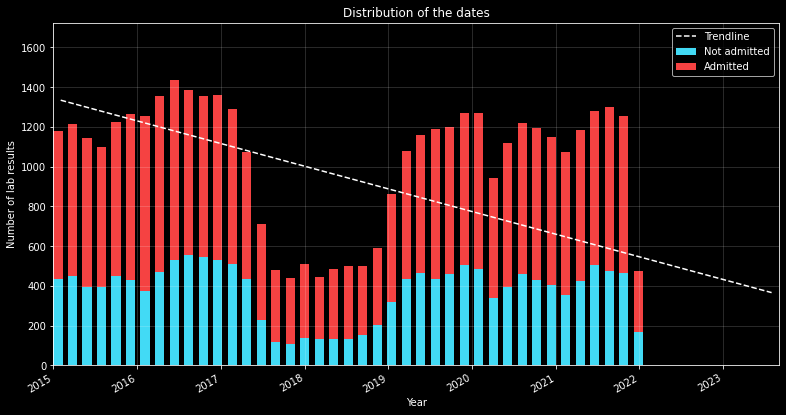

In [878]:
create_date_histogram(df_leuco2)

In [879]:
df_leuco2[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.058625
OPNAME   0.058625  1.000000

In [880]:
df_leuco2['DESC'] = 'Leukocyten (Urine)' 
df_all = pd.concat([df_all, df_leuco2])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### HEMATOCRIET

Hematocrit is a measure of the proportion of blood that is occupied by red blood cells. The normal range for hematocrit in adults is typically 38.3 to 48.6 percent for males and 35.5 to 44.9 percent for females. Abnormal levels can indicate conditions such as anemia or polycythemia, requiring medical assessment for appropriate diagnosis and management. Monitoring hematocrit levels is crucial for assessing red blood cell health and oxygen-carrying capacity.

In [881]:
print_unique_values_overview('hema')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Hematocriet                              CS000002   85837      100.00   EDTA bloed           L/L               
----------------------------------------------------------------------------------------------------


In [882]:
df_hema = df[df['DESC'] == 'Hematocriet']
# df_hema.head()

In [883]:
df_hema['UITSLAG'].isna().sum()

0

In [884]:
show_non_numeric_counts(df_hema)

-                   5     
<0.03               2     
rect                1     
total of 8 non numeric values (0.01 %)


In [885]:
df_hema = clean_numeric_column(df_hema, 'UITSLAG')
show_non_numeric_counts(df_hema)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


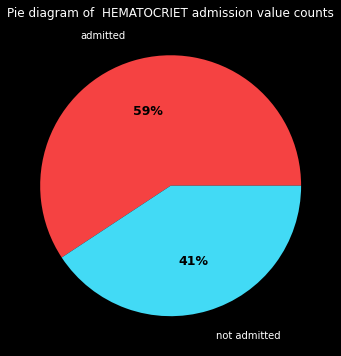

In [886]:
create_pie_diagram(df_hema, 'HEMATOCRIET')

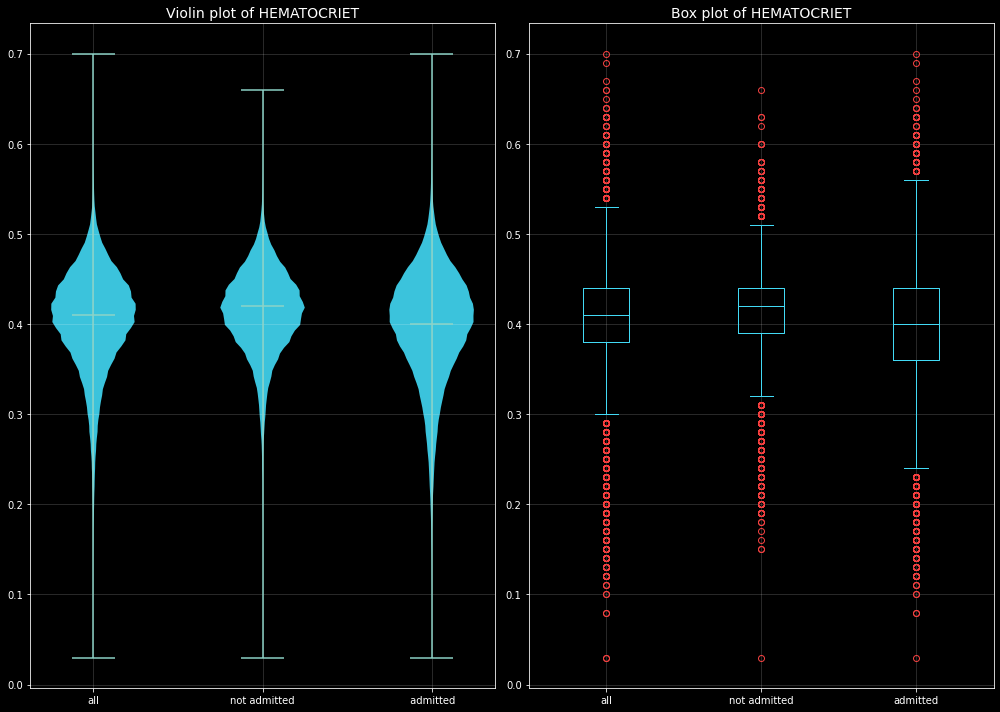

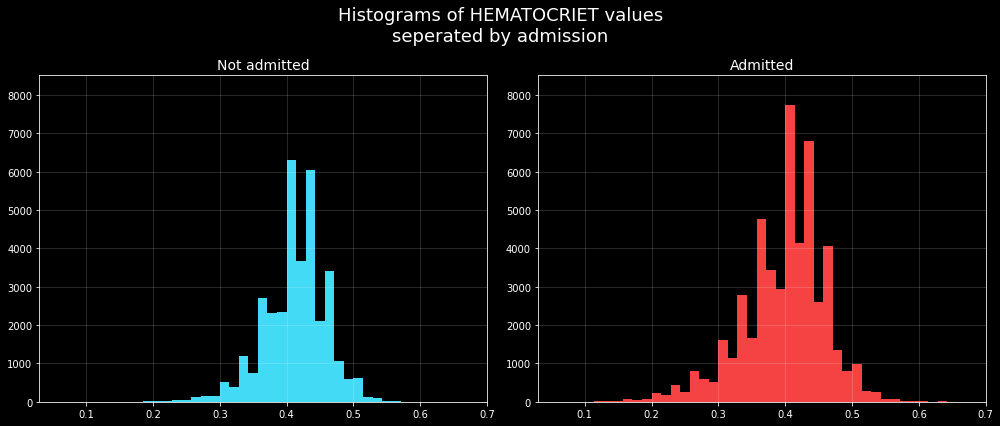

In [887]:
create_distribution_plots(df_hema, 'HEMATOCRIET')
create_histograms(df_hema, 'HEMATOCRIET')

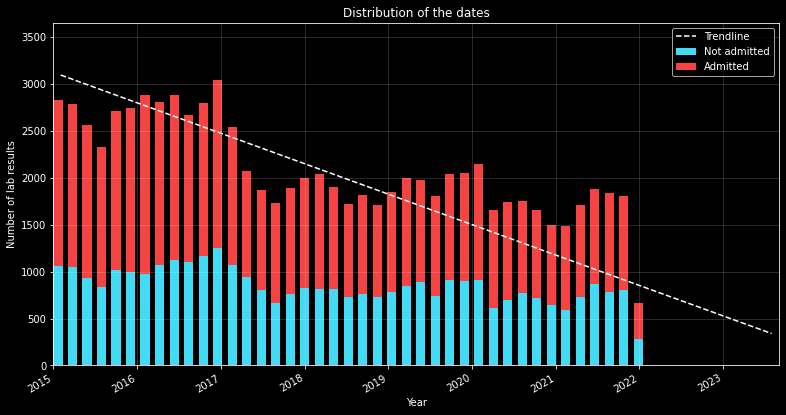

In [888]:
create_date_histogram(df_hema)

In [889]:
df_hema[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.130993
OPNAME  -0.130993  1.000000

In [890]:
df_all = pd.concat([df_all, df_hema])

#### HEMOGLOBINE

Hemoglobin is a protein in red blood cells that carries oxygen from the lungs to the body's tissues and organs, crucial for oxygen transport and tissue health. The normal range of hemoglobin levels varies by gender, with approximately 8.56 to 10.62 millimoles per liter (mmol/L) for adult males and 7.51 to 9.36 mmol/L for adult females. Abnormal hemoglobin levels may indicate anemia or other health conditions, necessitating further medical assessment and appropriate treatment.

In [891]:
print_unique_values_overview('hemoglobine')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Hemoglobine                              CS000001   110594     92.95    EDTA bloed           mmol/L            
----------------------------------------------------------------------------------------------------
Hemoglobine (av)                         CS005209   1          0.00     nan                  mmol/l            
----------------------------------------------------------------------------------------------------
Hemoglobine (pv)                         CS005189   40         0.03     nan                  mmol/l            
----------------------------------------------------------------------------------------------------
Hemoglobine POCT                         CS002118   3203       2.69     Volbloed             mmol/L            
------------------------------------------

##### Hemoglboine (CS000001)

In [892]:
df_hb = df[df['BEPCODE'] == 'CS000001']
# df_hb.head()

In [893]:
df_hb['UITSLAG'].isna().sum()

0

In [894]:
show_non_numeric_counts(df_hb)

-                   3     
Vervallen monster   3     
<0.6                2     
rect                1     
total of 9 non numeric values (0.01 %)


In [895]:
df_hb = clean_numeric_column(df_hb, 'UITSLAG')
show_non_numeric_counts(df_hb)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


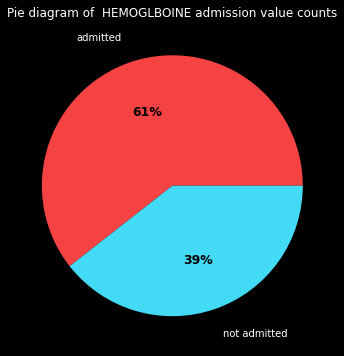

In [896]:
create_pie_diagram(df_hb, 'HEMOGLBOINE')

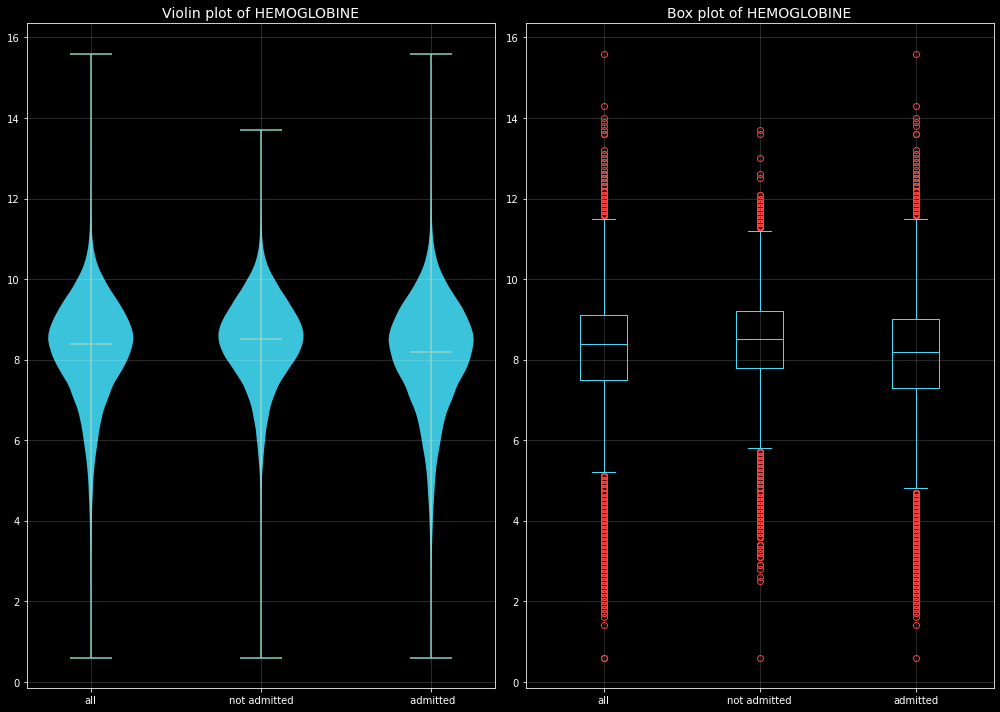

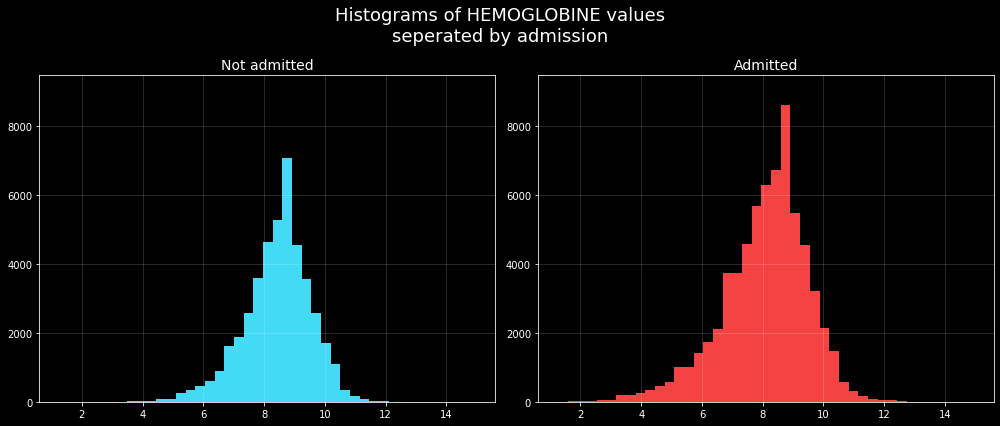

In [897]:
create_distribution_plots(df_hb, 'HEMOGLOBINE')
create_histograms(df_hb, 'HEMOGLOBINE')

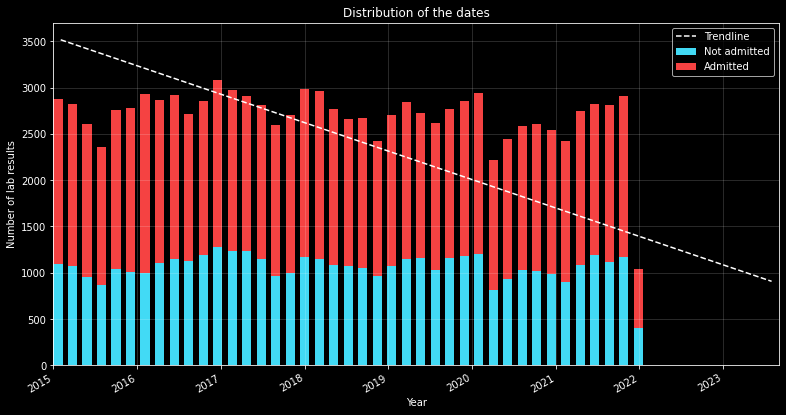

In [898]:
create_date_histogram(df_hb)

In [899]:
df_hb[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.132198
OPNAME  -0.132198  1.000000

In [900]:
df_all = pd.concat([df_all, df_hb])

#### CRP

C-reactive protein (CRP) is a marker of inflammation in the body and is used to assess the presence and intensity of inflammation. The normal range for CRP levels is typically less than 10 milligrams per liter (mg/L). Elevated CRP levels may indicate an inflammatory condition, infection, or other underlying health issues, prompting further medical evaluation and necessary interventions. Monitoring CRP levels aids in assessing the inflammatory response and overall health status.

In [901]:
print_unique_values_overview('crp')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
CRP                                      CS000277   89022      98.80    Heparine plasma      mg/L              
----------------------------------------------------------------------------------------------------
CRP-POCT                                 CS002702   1081       1.20     Volbloed             mg/L              
----------------------------------------------------------------------------------------------------


##### CRP (CS000277)

In [ ]:
df_crp = df[df['DESC'] == 'CRP']

In [903]:
df_crp['UITSLAG'].isna().sum()

0

In [904]:
show_non_numeric_counts(df_crp)

<1                  13134 
>700                4     
-                   2     
rect                2     
Vervallen monster   1     
<5                  1     
???                 1     
total of 13145 non numeric values (14.77 %)


In [905]:
df_crp = clean_numeric_column(df_crp, 'UITSLAG')
show_non_numeric_counts(df_crp)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


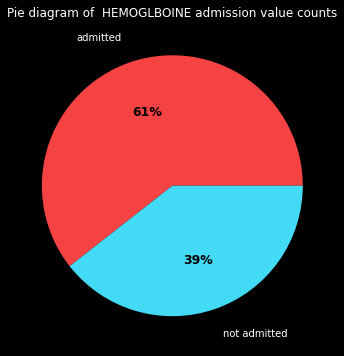

In [906]:
create_pie_diagram(df_hb, 'HEMOGLBOINE')

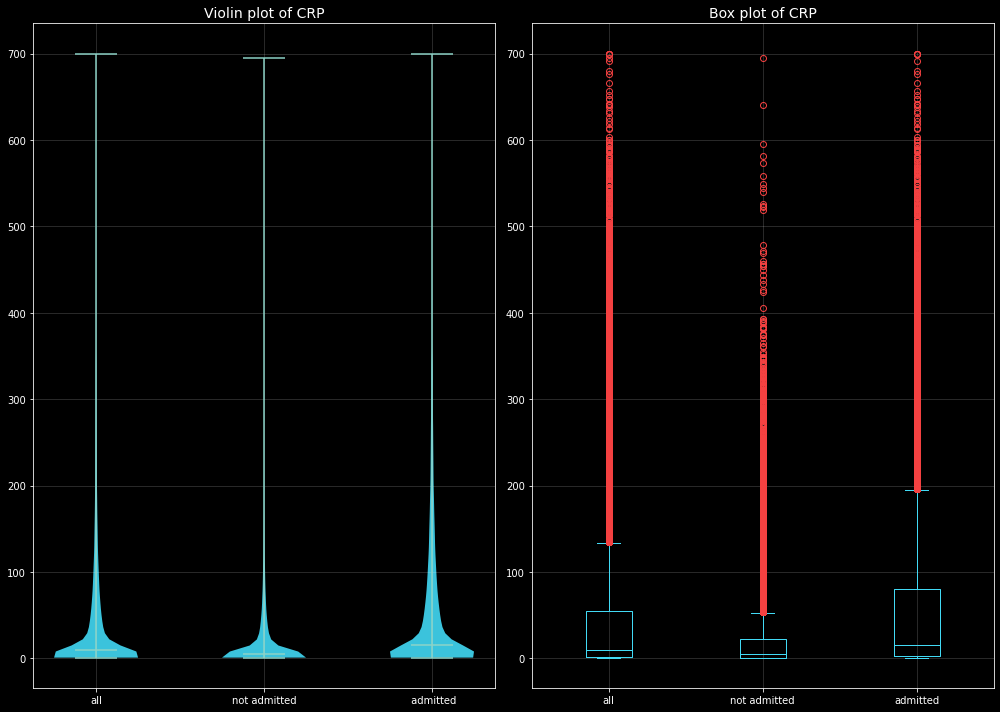

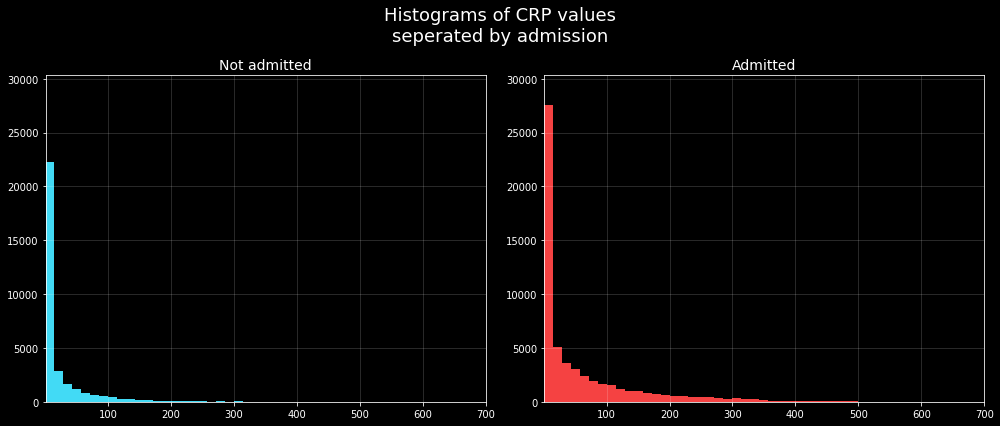

In [907]:
create_distribution_plots(df_crp, 'CRP')
create_histograms(df_crp, 'CRP')

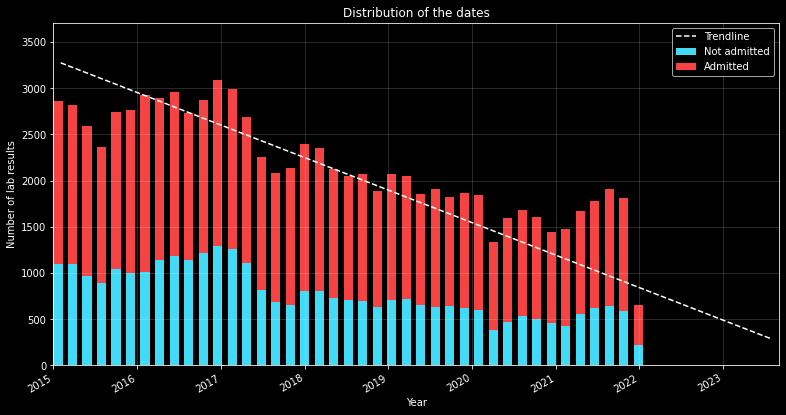

In [908]:
create_date_histogram(df_crp)

In [909]:
df_all = pd.concat([df_all, df_crp])

In [910]:
df_crp[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.222192
OPNAME   0.222192  1.000000

##### CRP POC (CS002702)

In [911]:
df_crp_poc = df[df['BEPCODE'] == 'CS002702']
# df_crp_poc.head()

In [912]:
df_crp_poc['UITSLAG'].isna().sum()

0

In [913]:
show_non_numeric_counts(df_crp_poc)

<5                  218   
Vervallen monster   24    
? mg/l              4     
<1                  1     
total of 247 non numeric values (22.85 %)


In [914]:
df_crp_poc = handle_numeric_category_column(df_crp_poc, 'UITSLAG')
show_non_numeric_counts(df_crp_poc)

to clean_numeric
total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


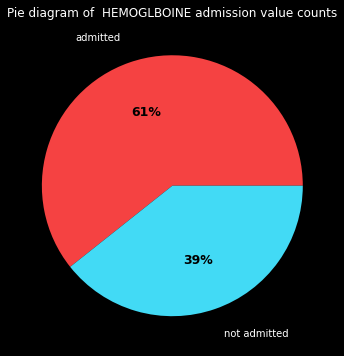

In [915]:
create_pie_diagram(df_crp_poc, 'HEMOGLBOINE')

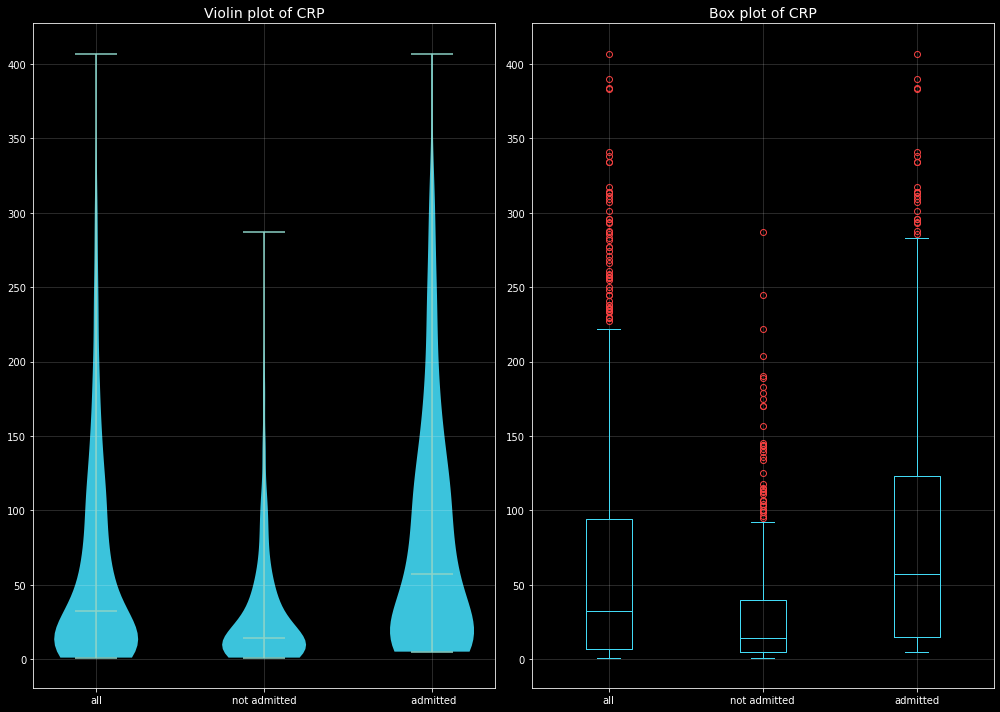

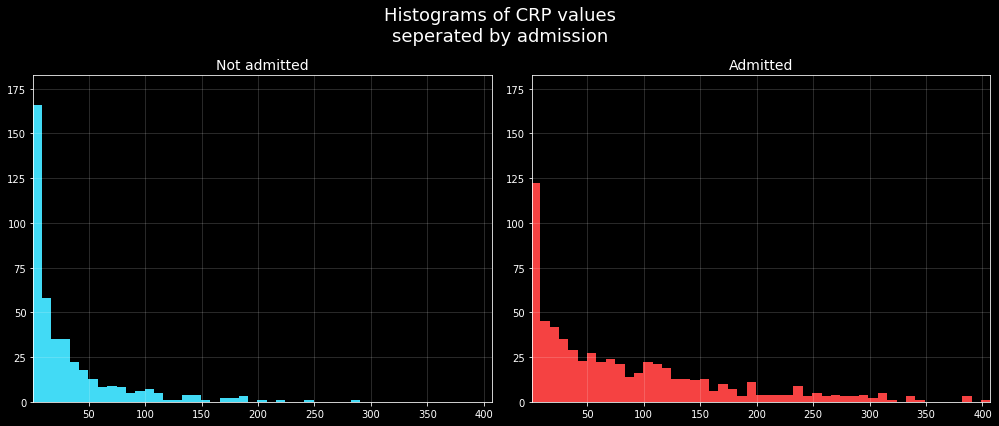

In [916]:
create_distribution_plots(df_crp_poc, 'CRP')
create_histograms(df_crp_poc, 'CRP')

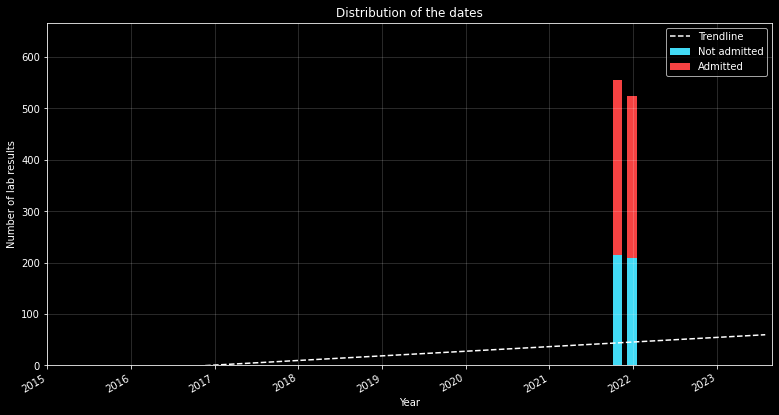

In [917]:
create_date_histogram(df_crp_poc)

In [918]:
df_crp_poc[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.332613
OPNAME   0.332613  1.000000

In [919]:
# df_all = pd.concat([df_all, df_crp])

#### BILIRUBINE

Bilirubin is a yellowish pigment produced during the breakdown of red blood cells and is processed by the liver. The normal range for total bilirubin levels in the blood is typically 0.3 to 1.9 milligrams per deciliter (mg/dL) or 5 to 32 micromoles per liter (μmol/L). Elevated bilirubin levels can indicate liver or bile duct issues, requiring further medical evaluation for diagnosis and appropriate management. Monitoring bilirubin levels is important for assessing liver function and overall metabolic health.

In [920]:
print_unique_values_overview('bilirubine')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Bilirubine Totaal                        CS000197   74844      100.00   Heparine plasma      µmol/L            
----------------------------------------------------------------------------------------------------


In [921]:
df_bili = df[df['DESC'] == 'Bilirubine Totaal']
# df_bili.head()

In [922]:
df_bili['UITSLAG'].isna().sum()

0

In [923]:
show_non_numeric_counts(df_bili)

<17                 64624 
rect                2     
-                   1     
???                 1     
Vervallen monster   1     
total of 64629 non numeric values (86.35 %)


In [924]:
df_bili = clean_numeric_column(df_bili, 'UITSLAG')
show_non_numeric_counts(df_bili)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


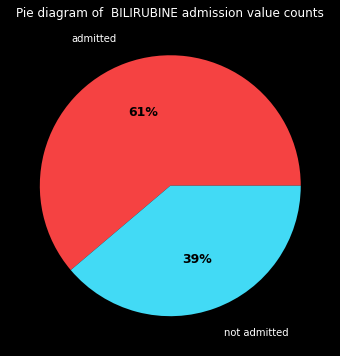

In [925]:
create_pie_diagram(df_bili, 'BILIRUBINE')

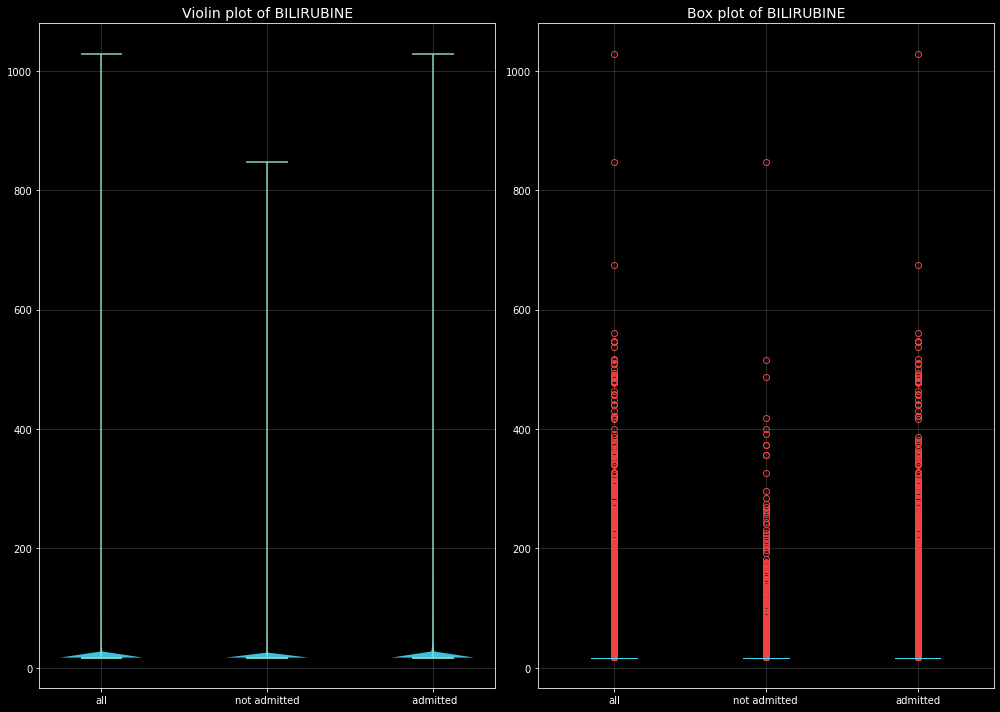

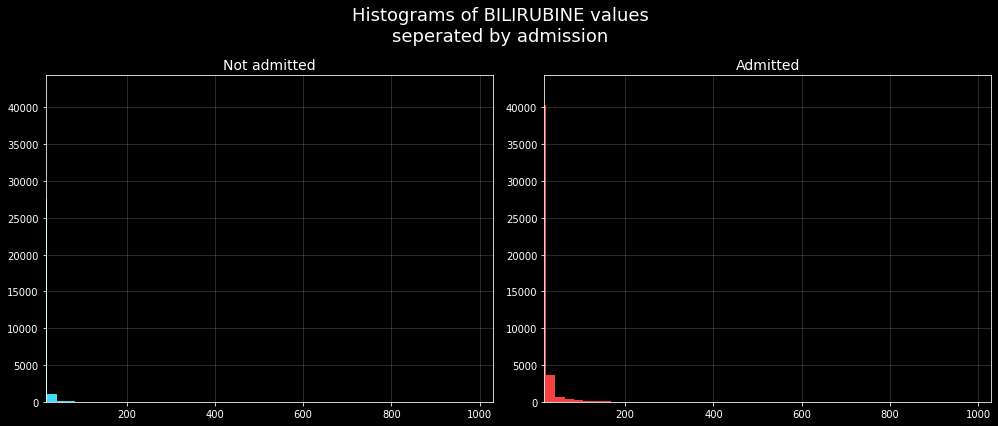

In [926]:
create_distribution_plots(df_bili, 'BILIRUBINE')
create_histograms(df_bili, 'BILIRUBINE')

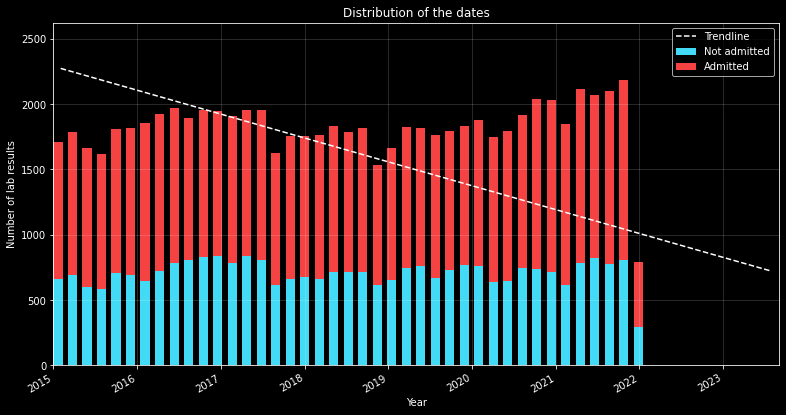

In [927]:
create_date_histogram(df_bili)

In [928]:
df_bili[['UITSLAG', 'OPNAME']].corr()

UITSLAG   OPNAME
UITSLAG  1.00000  0.06872
OPNAME   0.06872  1.00000

In [929]:
df_all = pd.concat([df_all, df_bili])

#### LACTAAT

Lactate is a byproduct of the body's energy metabolism, primarily produced during intense exercise or when the body doesn't get enough oxygen. The normal range for lactate levels in the blood typically falls between 0.5 to 2.2 millimoles per liter (mmol/L). Elevated lactate levels, known as lactic acidosis, may suggest tissue hypoxia or other medical conditions, necessitating further medical evaluation and appropriate treatment. Monitoring lactate levels helps assess tissue oxygenation and metabolic status.

In [930]:
print_unique_values_overview('lactaat')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
Lactaat                                  CS001401   10245      46.88    Heparine bloed       mmol/L            
Lactaat                                  @0002709   1          0.00     nan                  mmol/l            
----------------------------------------------------------------------------------------------------
Lactaat (POC)                            @0002710   7066       32.33    nan                  mmol/l            
Lactaat (POC)                            ZGT01324   4542       20.78    Volbloed             mmol/l            
Lactaat (POC)                            00003119   1          0.00     nan                  mmol/l            
----------------------------------------------------------------------------------------------------


##### Lactaat (CS001401)

In [931]:
df_lact = df[df['BEPCODE'] == 'CS001401']
# df_lact.head()

In [932]:
df_lact['UITSLAG'].isna().sum()

0

In [933]:
show_non_numeric_counts(df_lact)

Vervallen monster   8     
total of 8 non numeric values (0.08 %)


In [934]:
df_lact = clean_numeric_column(df_lact, 'UITSLAG')
show_non_numeric_counts(df_lact)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


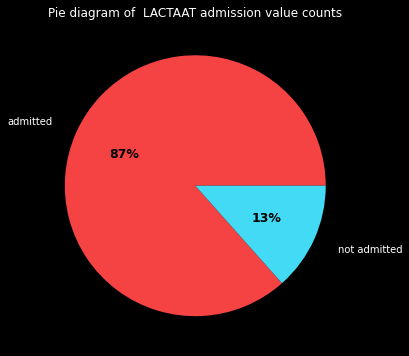

In [935]:
create_pie_diagram(df_lact, 'LACTAAT')

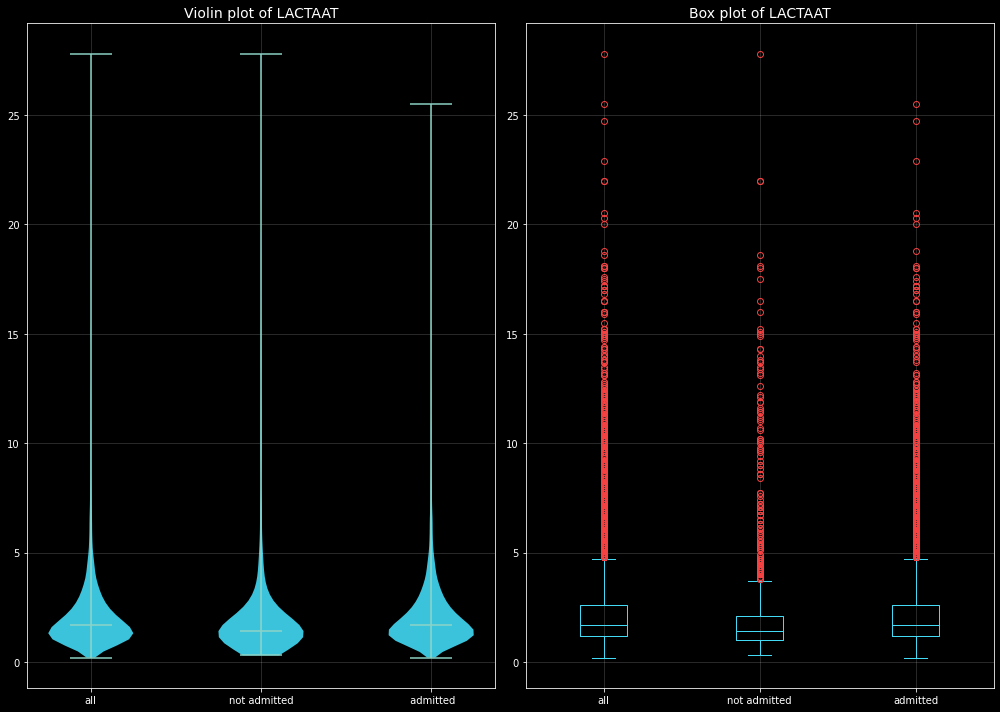

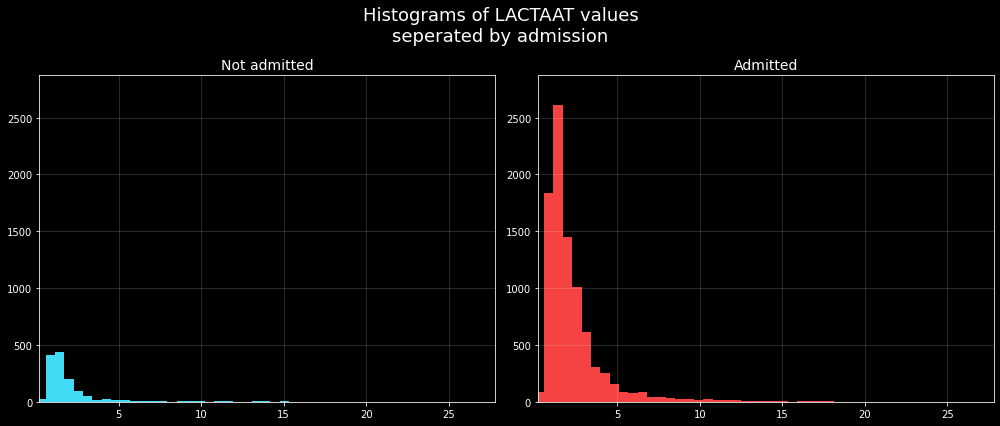

In [936]:
create_distribution_plots(df_lact, 'LACTAAT')
create_histograms(df_lact, 'LACTAAT')

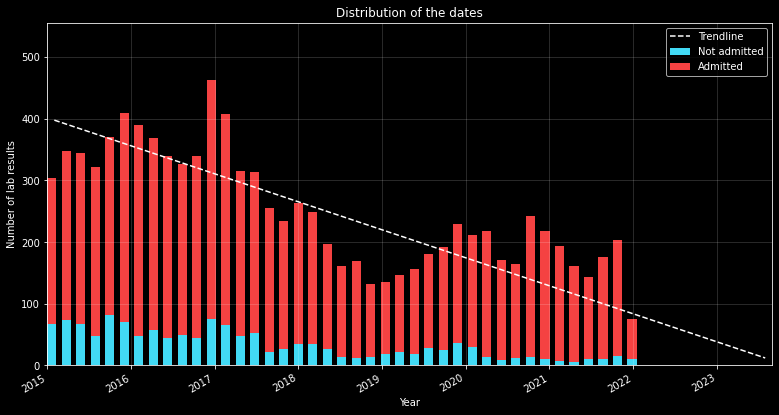

In [937]:
create_date_histogram(df_lact)

In [938]:
df_lact[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.019905
OPNAME   0.019905  1.000000

In [939]:
df_all = pd.concat([df_all, df_lact])

##### Lactaat POC (@0002710 & ZGT01324)

In [940]:
df_lact_poc = df[df['BEPCODE'].isin(['@0002710', 'ZGT01324'])]
# df_lact_poc.head()

In [941]:
df_lact_poc['UITSLAG'].isna().sum()

0

In [942]:
show_non_numeric_counts(df_lact_poc)

***                 31    
<0.3                26    
Vervallen monster   9     
>20.0               6     
total of 72 non numeric values (0.62 %)


In [943]:
df_lact_poc = clean_numeric_column(df_lact_poc, 'UITSLAG')
show_non_numeric_counts(df_lact_poc)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


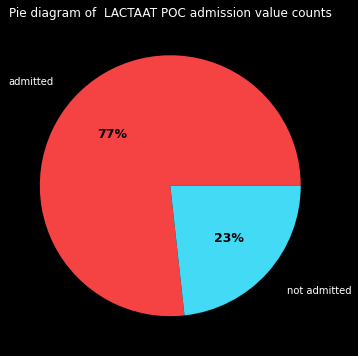

In [944]:
create_pie_diagram(df_lact_poc, 'LACTAAT POC')

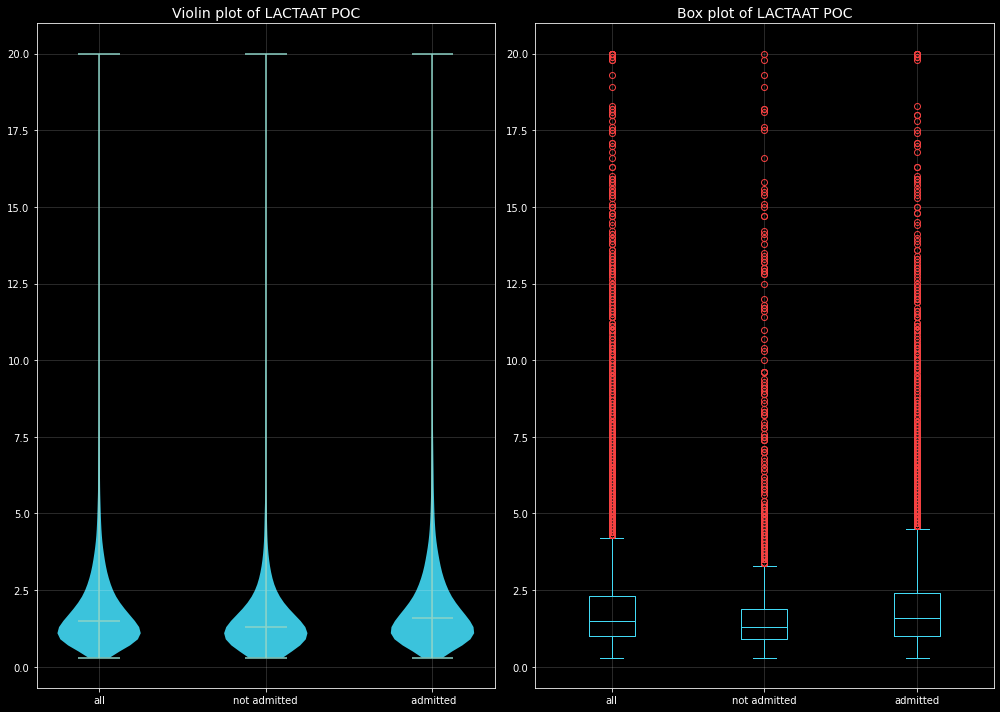

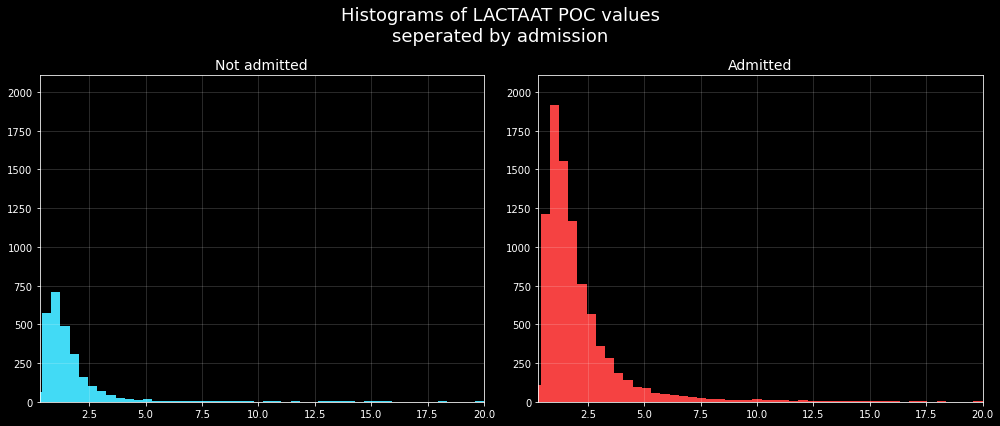

In [945]:
create_distribution_plots(df_lact_poc, 'LACTAAT POC')
create_histograms(df_lact_poc, 'LACTAAT POC')

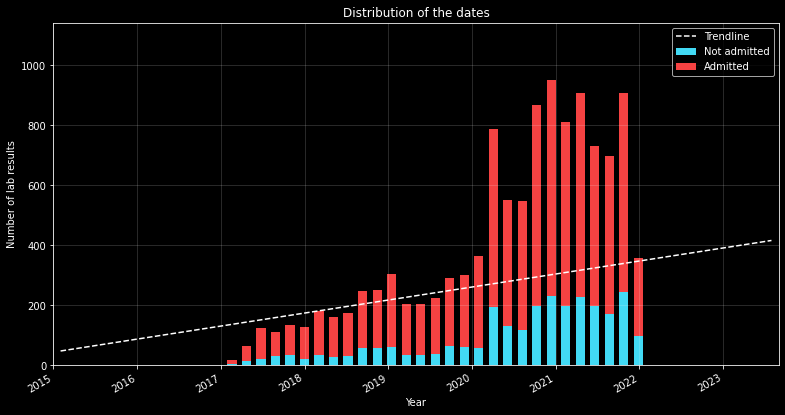

In [946]:
create_date_histogram(df_lact_poc)

In [947]:
df_lact[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.019905
OPNAME   0.019905  1.000000

In [948]:
df_lact_poc['DESC'] = 'Lactaat (POC)' 
df_all = pd.concat([df_all, df_lact_poc])

/pyenvs/admission-prediction/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### TROPONINE 

Troponin is a protein released into the bloodstream after heart muscle injury, often due to a heart attack. The normal range for troponin levels is typically less than 40 nanograms per liter (ng/L). Elevated troponin levels indicate heart muscle damage and are a critical marker for cardiac conditions, warranting immediate medical attention and further diagnostic evaluation. Monitoring troponin levels is crucial for diagnosing and managing heart-related issues.

In [949]:
print_unique_values_overview('trop')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
AQT-Troponine T                          ZGT00767   2          0.02     Volbloed             ng/l              
----------------------------------------------------------------------------------------------------
hsTroponine T                            ZGT00324   8448       99.95    Heparine plasma      ng/l              
hsTroponine T                            @0003639   2          0.02     nan                  ng/l              
----------------------------------------------------------------------------------------------------


In [950]:
df_trop = df[df['BEPCODE'] == 'ZGT00324']
# df_trop.head()

In [951]:
df_trop['UITSLAG'].isna().sum()

0

In [952]:
show_non_numeric_counts(df_trop)

<9                  2213  
<5                  263   
>10000              3     
*35 ng/l            1     
Vervallen monster   1     
total of 2481 non numeric values (29.37 %)


In [953]:
df_trop = clean_numeric_column(df_trop, 'UITSLAG')
show_non_numeric_counts(df_trop)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


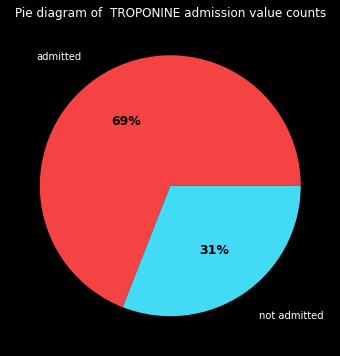

In [954]:
create_pie_diagram(df_trop, 'TROPONINE')

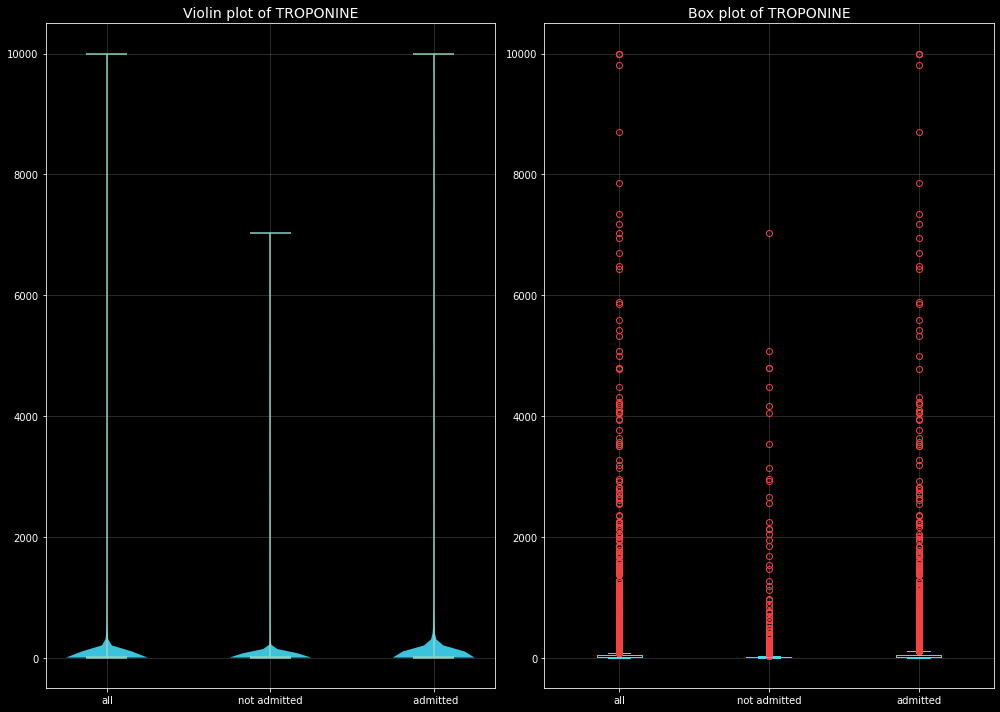

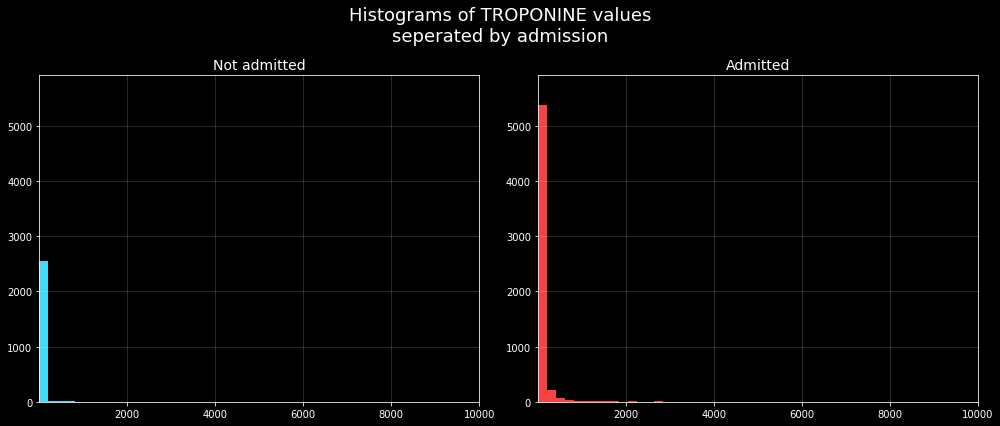

In [955]:
create_distribution_plots(df_trop, 'TROPONINE')
create_histograms(df_trop, 'TROPONINE')

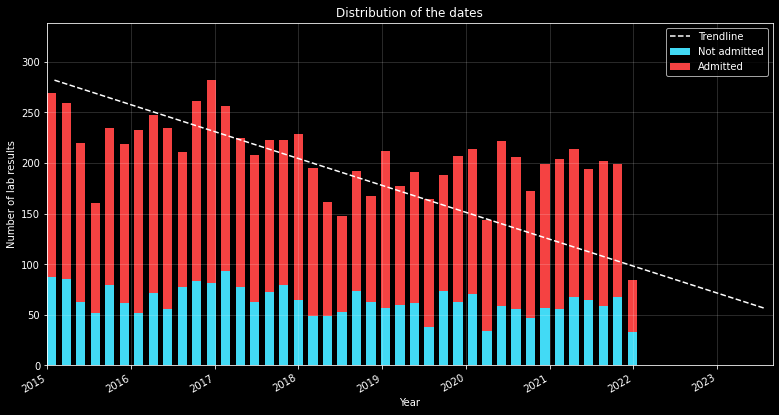

In [956]:
create_date_histogram(df_trop)

In [957]:
df_trop[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.060306
OPNAME   0.060306  1.000000

In [958]:
df_all = pd.concat([df_all, df_trop])

#### NT PRO-BNP

N-terminal pro-B-type natriuretic peptide (NT-proBNP) is a hormone released by the heart in response to stress and heart failure. The normal range for NT-proBNP levels is typically less than 125 picomoles per liter (pmol/L). Elevated NT-proBNP levels suggest heart stress or heart failure, prompting further medical evaluation for diagnosis and appropriate management. Monitoring NT-proBNP levels is essential for assessing cardiac health and identifying potential heart-related issues.

In [959]:
print_unique_values_overview('pro')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
NT-proBNP                                ZGT00473   6201       98.88    Heparine plasma      pmol/l            
NT-proBNP                                @0000603   1          0.02     nan                  pmol/l            
----------------------------------------------------------------------------------------------------
NT-proBNP POC                            @0003162   69         1.10     nan                  pmol/l            
----------------------------------------------------------------------------------------------------


In [960]:
df_probnp = df[df['BEPCODE'] == 'ZGT00473']
# df_probnp.head()

In [961]:
df_probnp['UITSLAG'].isna().sum()

0

In [962]:
show_non_numeric_counts(df_probnp)

<5.9                119   
>8200               36    
>8000               10    
<0.60               3     
Vervallen monster   1     
total of 169 non numeric values (2.73 %)


In [963]:
df_probnp = clean_numeric_column(df_probnp, 'UITSLAG')
show_non_numeric_counts(df_probnp)

total of 0 non numeric values (0.00 %)


/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


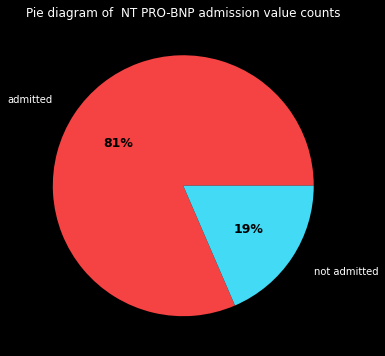

In [964]:
create_pie_diagram(df_probnp, 'NT PRO-BNP')

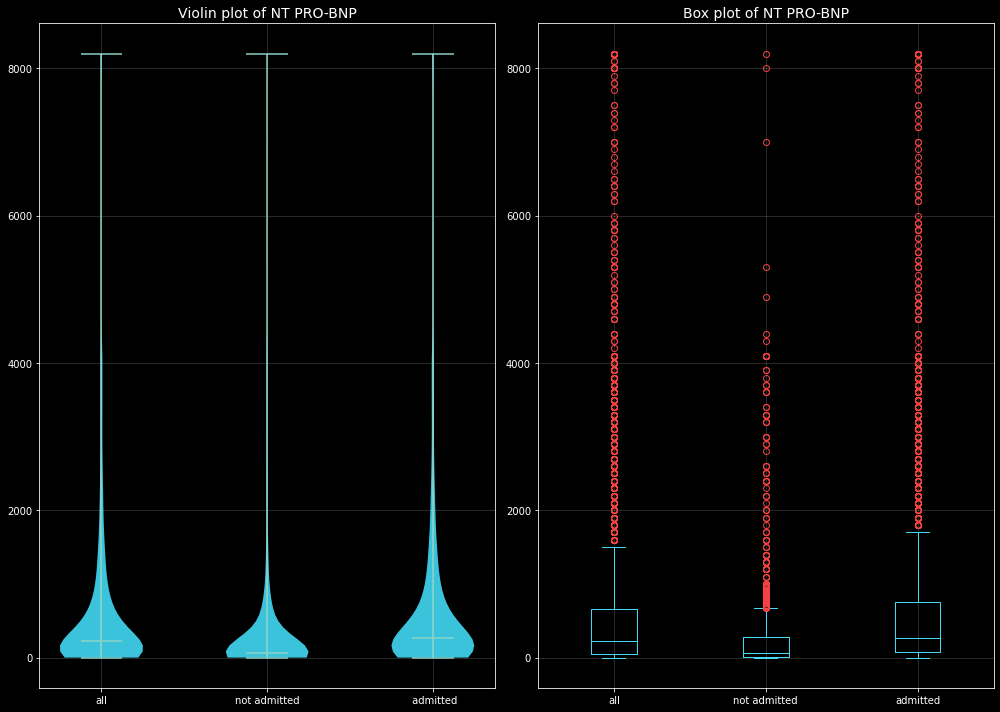

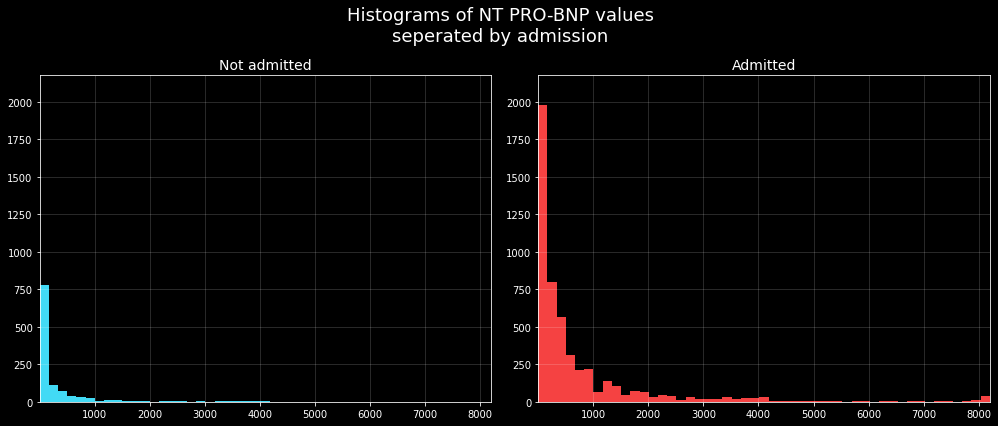

In [965]:
create_distribution_plots(df_probnp, 'NT PRO-BNP')
create_histograms(df_probnp, 'NT PRO-BNP')

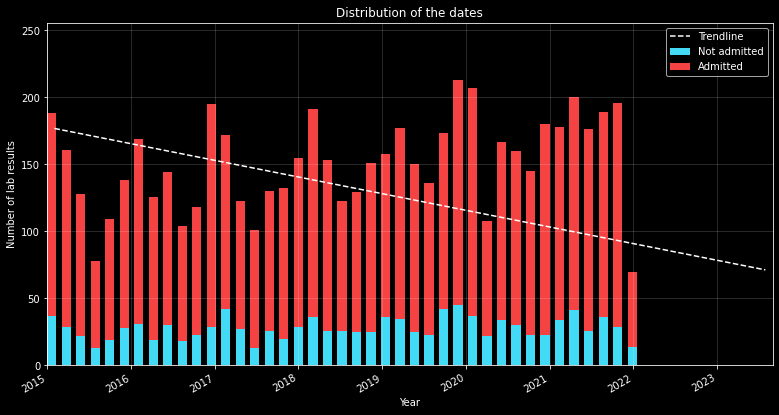

In [966]:
create_date_histogram(df_probnp)

In [967]:
df_probnp[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.124488
OPNAME   0.124488  1.000000

In [968]:
df_all = pd.concat([df_all, df_probnp])

#### Bloedgas Veneus

##### PO2 

In [969]:
print_unique_values_overview(' sat')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
O2 sat. mix veneus                       @0003167   12         0.05     nan                  mol/mol           
----------------------------------------------------------------------------------------------------
O2 sat.(POC)                             00003132   757        2.94     nan                  mol/mol           
----------------------------------------------------------------------------------------------------
O2 saturatie, arterieel                  ZGT00476   3670       14.25    Heparine bloed       mol/mol           
----------------------------------------------------------------------------------------------------
O2 saturatie, centraal veneus            ZGT00477   295        1.15     Heparine bloed       mmol/l            
------------------------------------------

##### pO2 veneus (ZGT00534)

In [970]:
df_po2_veneus = df[df['BEPCODE'] == 'ZGT00534']
# df_po2_veneus.head()

In [971]:
df_po2_veneus['UITSLAG'].isna().sum()

0

In [972]:
show_non_numeric_counts(df_po2_veneus)

-                   7     
rect                1     
total of 8 non numeric values (0.04 %)


In [973]:
df_po2_veneus = clean_numeric_column(df_po2_veneus, 'UITSLAG')
show_non_numeric_counts(df_po2_veneus)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


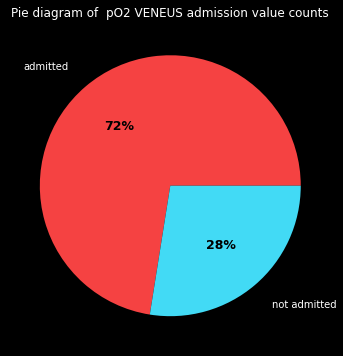

In [974]:
create_pie_diagram(df_po2_veneus, 'pO2 VENEUS')

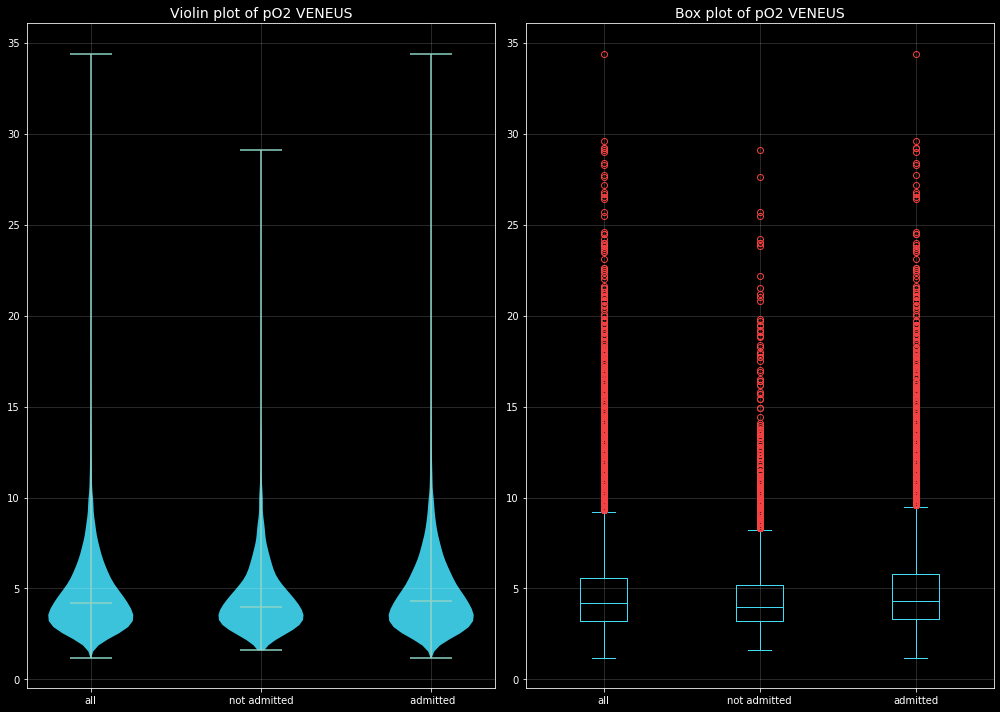

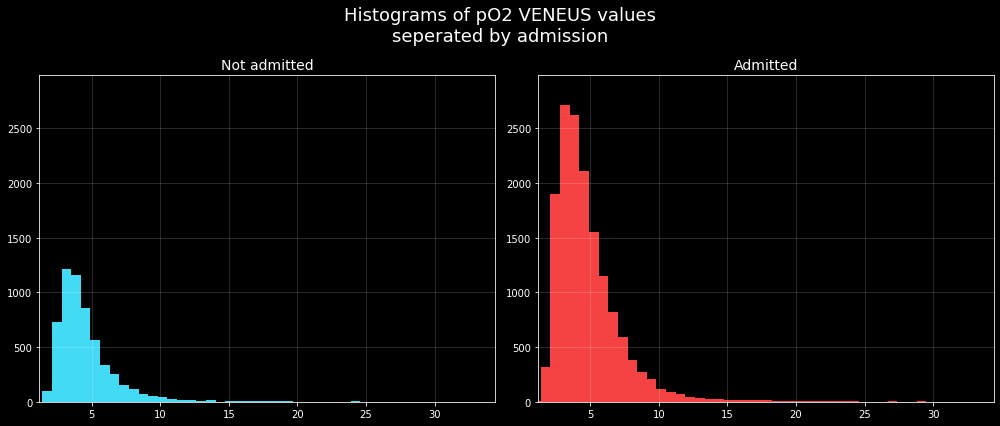

In [975]:
create_distribution_plots(df_po2_veneus, 'pO2 VENEUS')
create_histograms(df_po2_veneus, 'pO2 VENEUS')

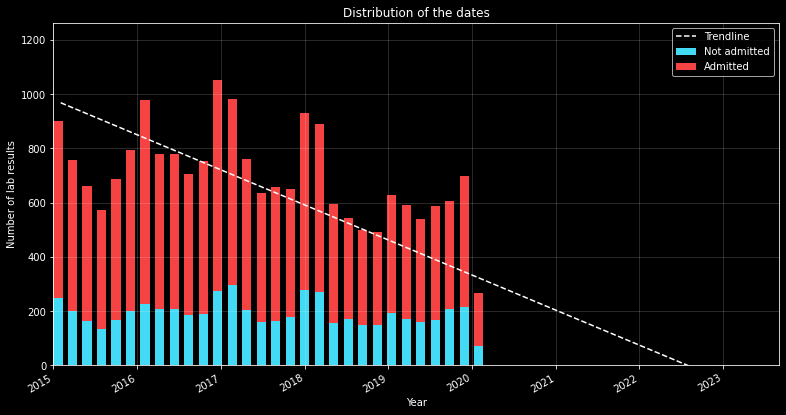

In [976]:
create_date_histogram(df_po2_veneus)

In [977]:
df_po2_veneus[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.051321
OPNAME   0.051321  1.000000

##### pCO2 Veneus (ZGT00517)

In [978]:
df_pco2_veneus = df[df['BEPCODE'] == 'ZGT00517']
# df_pco2_veneus.head()

In [979]:
df_pco2_veneus['UITSLAG'].isna().sum()

0

In [980]:
show_non_numeric_counts(df_pco2_veneus)

Vervallen monster   13    
<1.6                3     
-                   1     
rect                1     
total of 18 non numeric values (0.07 %)


In [981]:
df_pco2_veneus = clean_numeric_column(df_pco2_veneus, 'UITSLAG')
show_non_numeric_counts(df_pco2_veneus)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


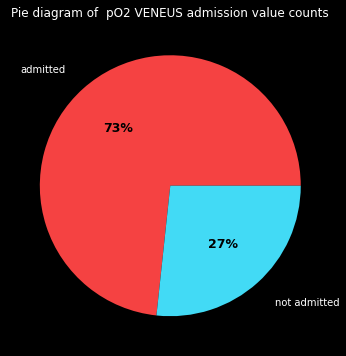

In [982]:
create_pie_diagram(df_pco2_veneus, 'pO2 VENEUS')

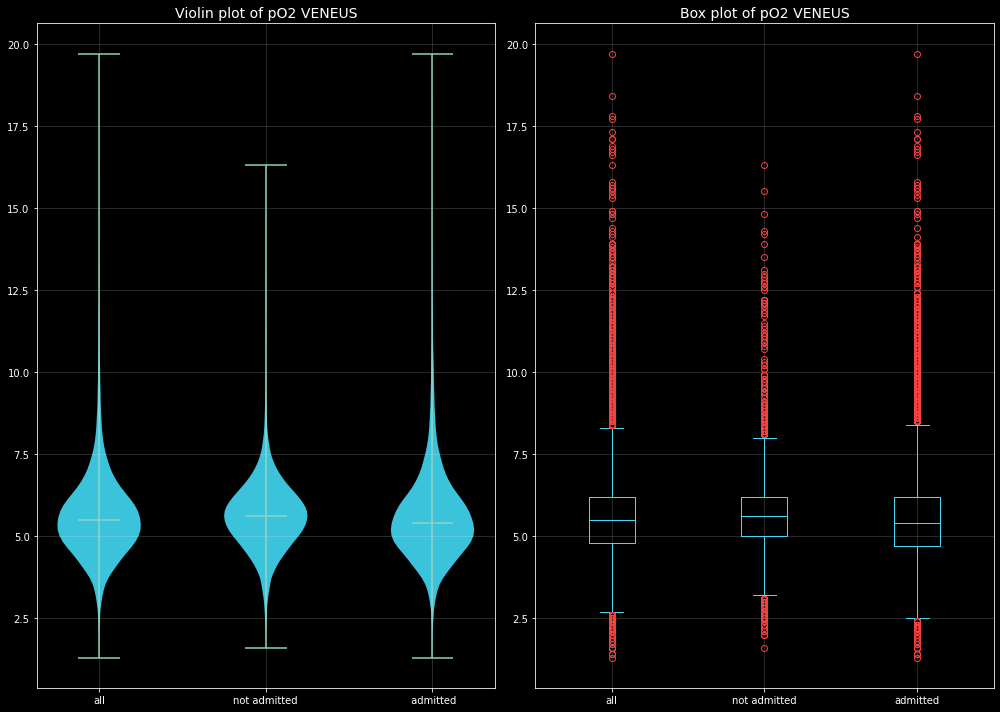

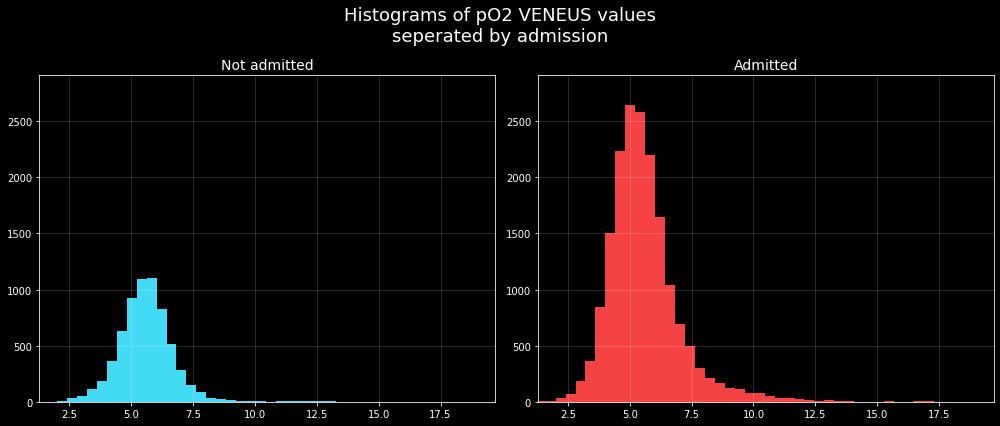

In [983]:
create_distribution_plots(df_pco2_veneus, 'pO2 VENEUS')
create_histograms(df_pco2_veneus, 'pO2 VENEUS')

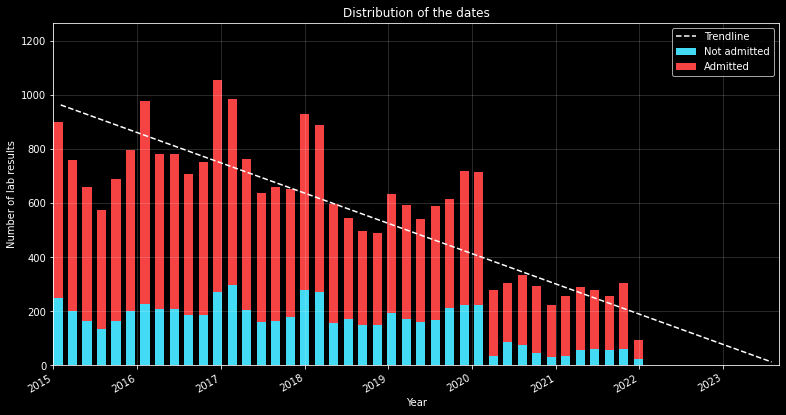

In [984]:
create_date_histogram(df_pco2_veneus)

In [985]:
df_pco2_veneus[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.007264
OPNAME  -0.007264  1.000000

##### pH Veneus (ZGT00525)

In [986]:
df_ph_veneus = df[df['BEPCODE'] == 'ZGT00525']
# df_ph_veneus.head()

In [987]:
df_ph_veneus['UITSLAG'].isna().sum()

0

In [988]:
show_non_numeric_counts(df_ph_veneus)

Vervallen monster   13    
<6.75               2     
rect                1     
<6.60               1     
total of 17 non numeric values (0.07 %)


In [989]:
df_ph_veneus = clean_numeric_column(df_ph_veneus, 'UITSLAG')
show_non_numeric_counts(df_ph_veneus)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


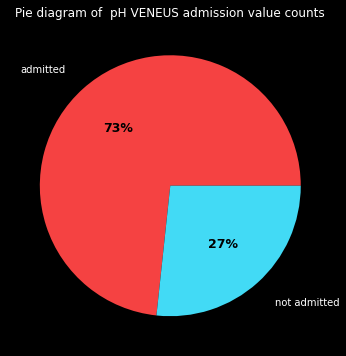

In [990]:
create_pie_diagram(df_ph_veneus, 'pH VENEUS')

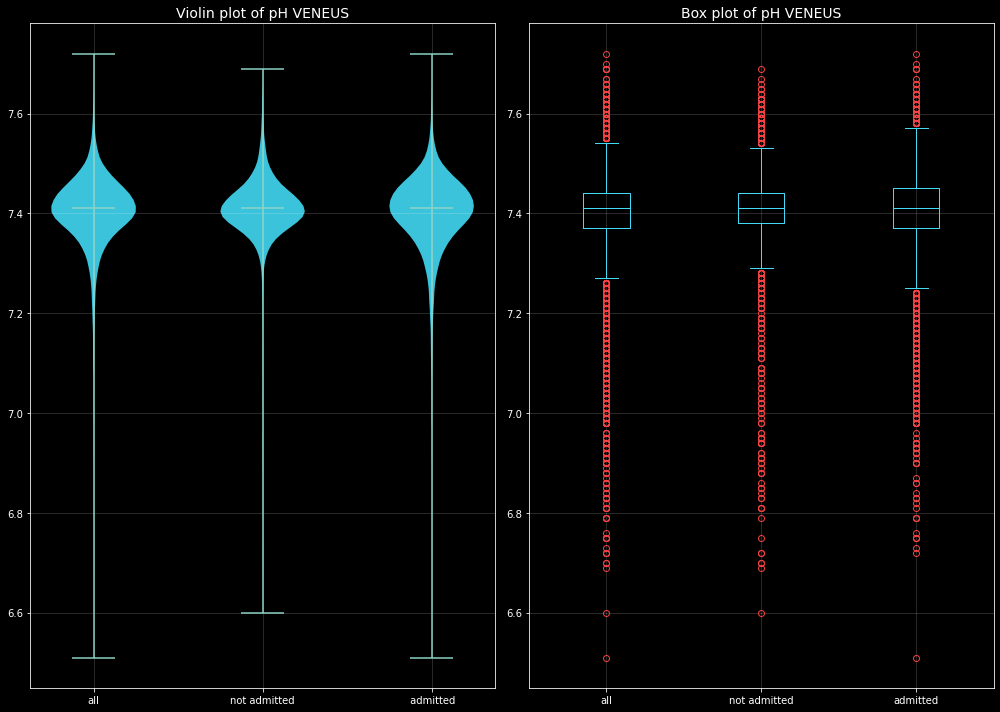

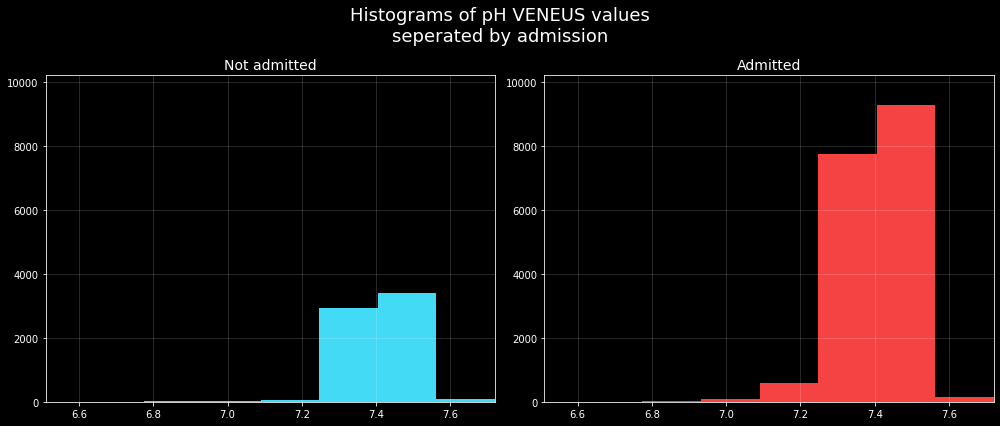

In [991]:
create_distribution_plots(df_ph_veneus, 'pH VENEUS')
create_histograms(df_ph_veneus, 'pH VENEUS')

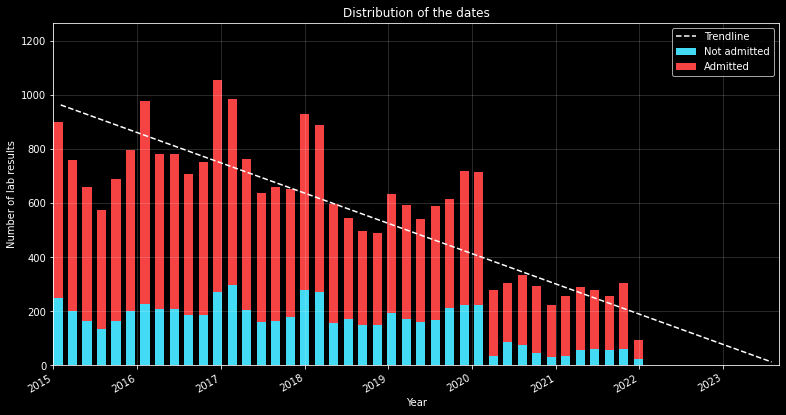

In [992]:
create_date_histogram(df_ph_veneus)

In [993]:
df_ph_veneus[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000 -0.042902
OPNAME  -0.042902  1.000000

##### O2 saturatie Veneus (ZGT00478)

In [994]:
print_unique_values_overview('sat')

SUBSTANCE                                BEPCODE    VAL_COUNT  %        FLUID                UNIT        
----------------------------------------------------------------------------------------------------
ASAT                                     CS000208   88821      77.52    Heparine plasma      U/L               
----------------------------------------------------------------------------------------------------
O2 sat. mix veneus                       @0003167   12         0.01     nan                  mol/mol           
----------------------------------------------------------------------------------------------------
O2 sat.(POC)                             00003132   757        0.66     nan                  mol/mol           
----------------------------------------------------------------------------------------------------
O2 saturatie, arterieel                  ZGT00476   3670       3.20     Heparine bloed       mol/mol           
------------------------------------------

In [995]:
df_o2_sat_veneus = df[df['BEPCODE'] == 'ZGT00478']
# df_o2_sat_veneus.head()

In [996]:
df_o2_sat_veneus['UITSLAG'].isna().sum()

0

In [997]:
show_non_numeric_counts(df_o2_sat_veneus)

>1.00               50    
?0.396              1     
rect                1     
-                   1     
?91.3               1     
total of 54 non numeric values (0.26 %)


In [998]:
df_o2_sat_veneus = clean_numeric_column(df_o2_sat_veneus, 'UITSLAG')
show_non_numeric_counts(df_o2_sat_veneus)

/pyenvs/admission-prediction/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


total of 0 non numeric values (0.00 %)


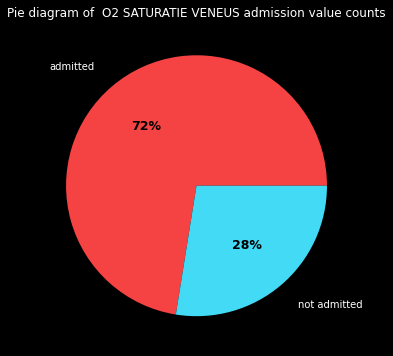

In [999]:
create_pie_diagram(df_o2_sat_veneus, 'O2 SATURATIE VENEUS')

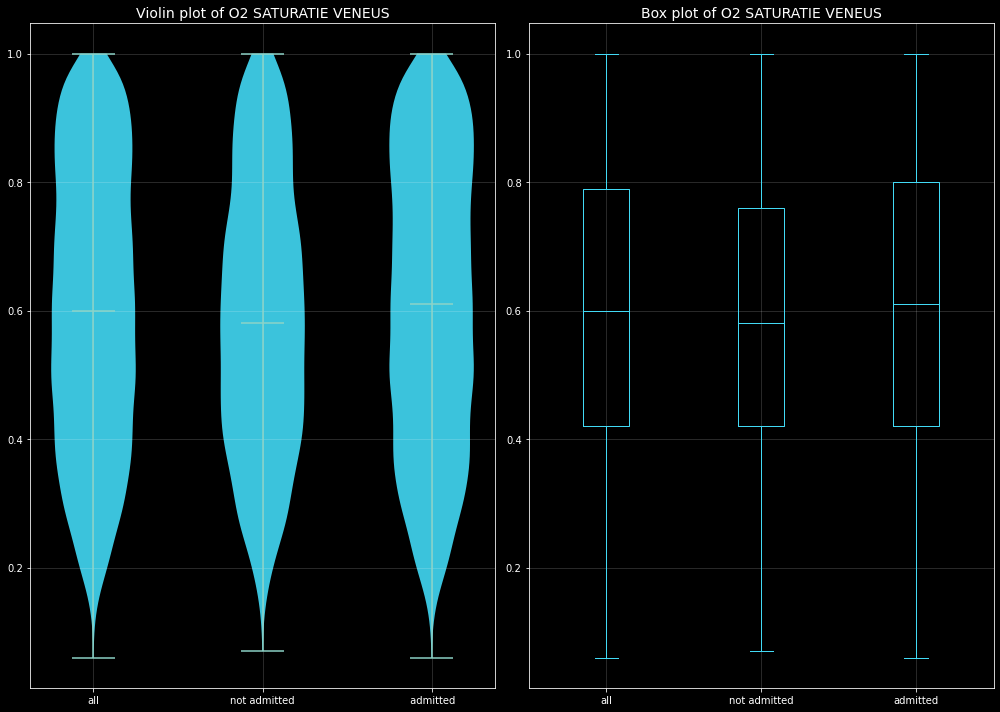

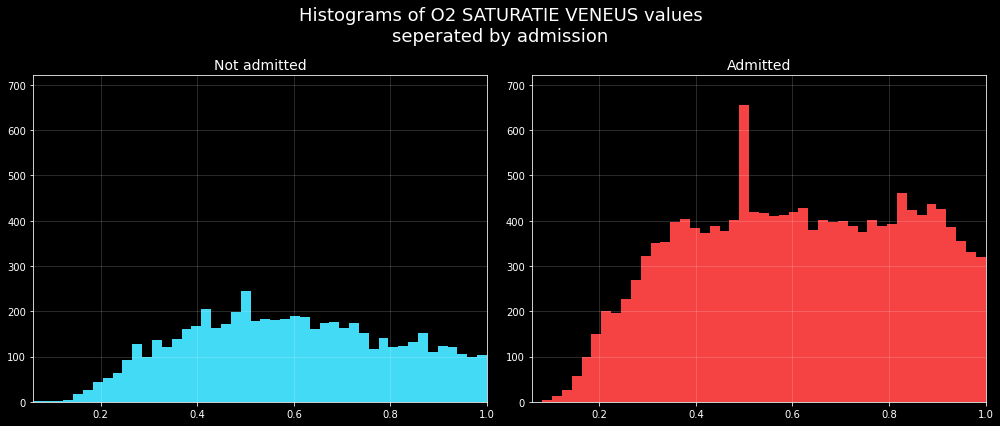

In [1000]:
create_distribution_plots(df_o2_sat_veneus, 'O2 SATURATIE VENEUS')
create_histograms(df_o2_sat_veneus, 'O2 SATURATIE VENEUS')

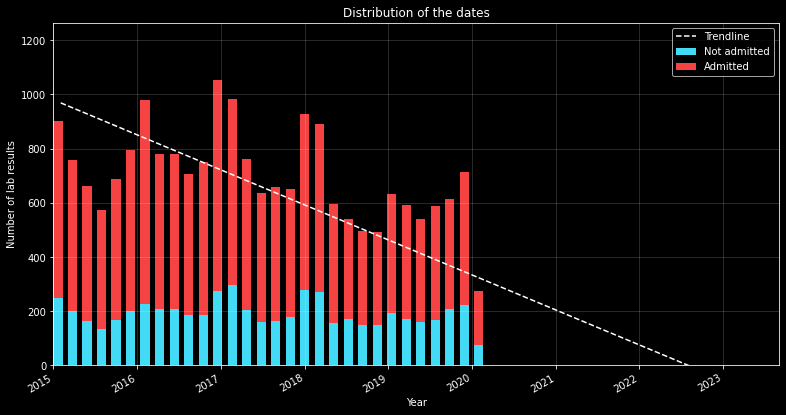

In [1001]:
create_date_histogram(df_o2_sat_veneus)

In [1002]:
df_o2_sat_veneus[['UITSLAG', 'OPNAME']].corr()

UITSLAG    OPNAME
UITSLAG  1.000000  0.030526
OPNAME   0.030526  1.000000

#### ALL

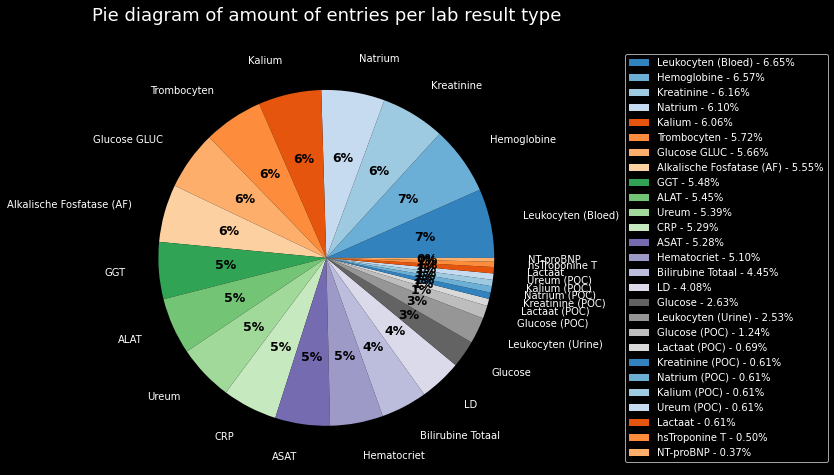

In [1003]:
val_counts = df_all['DESC'].value_counts()

color_palettes = plt.colormaps()

plt.figure(figsize=(11, 10))

wedges, text, autotexts = plt.pie(val_counts, labels=val_counts.keys(), 
                        autopct='%1.0f%%', labeldistance=1.2, 
                        colors=cycle(plt.get_cmap('tab20c').colors))

plt.setp(autotexts, **{'color':'black', 'weight':'bold', 'fontsize':12.5})
plt.title('Pie diagram of amount of entries per lab result type\n', fontsize='18')

legend_labels = [f'{label} - {percentage:.2f}%' for label, percentage in zip(val_counts.keys(), val_counts / sum(val_counts) * 100)]
plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))

plt.tight_layout()
plt.show()

In [1004]:
df_all = df_all[~df_all['PATIENTNR'].isna()]

df_subset = df_all[['SEHID', 'DESC', 'UITSLAG']]

patient_dict = {patient: {} for patient in df_subset['SEHID'].unique()}


for _, row in df_subset.iterrows():
    patient, substance, value = row
    patient_dict[patient][substance] = value

df_result = pd.DataFrame.from_dict(patient_dict, orient='index')

df_result.reset_index(inplace=True)
df_result.rename(columns={'index': 'SEHID'}, inplace=True)
df_result = df_result.set_index('SEHID')

# df_result.head()

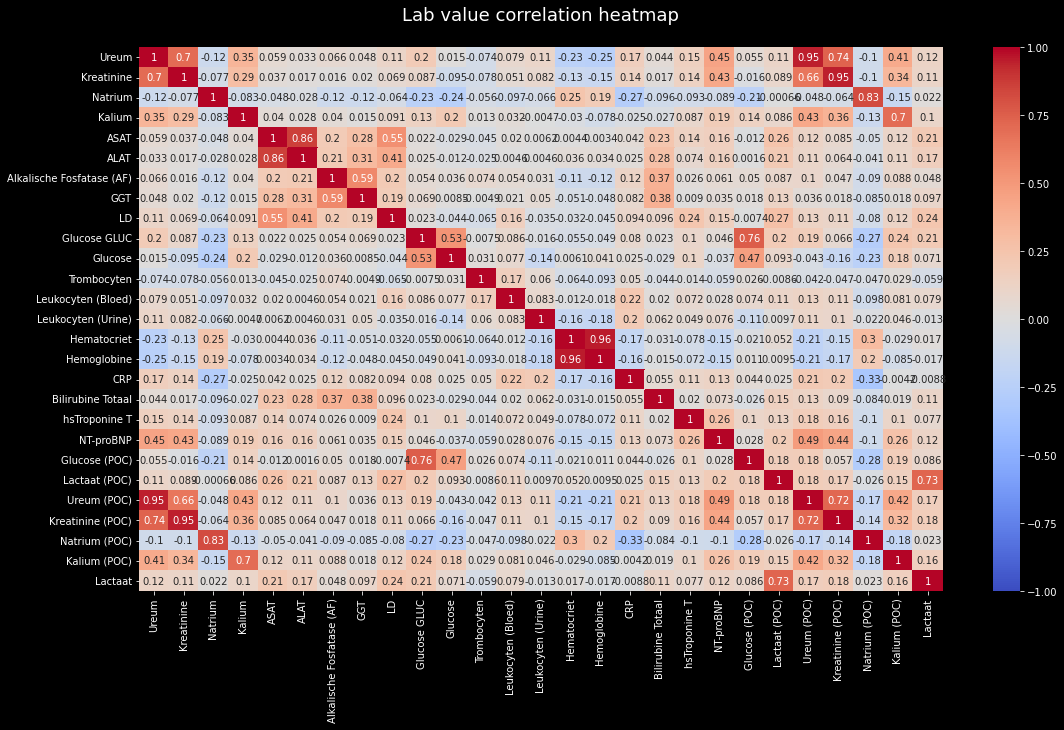

In [1005]:
plt.figure(figsize=(18, 10))
plt.title('Lab value correlation heatmap\n', fontsize=18)
sns.heatmap(df_result.corr(), annot=True, cmap='coolwarm', vmax=1, vmin=-1)
plt.show()

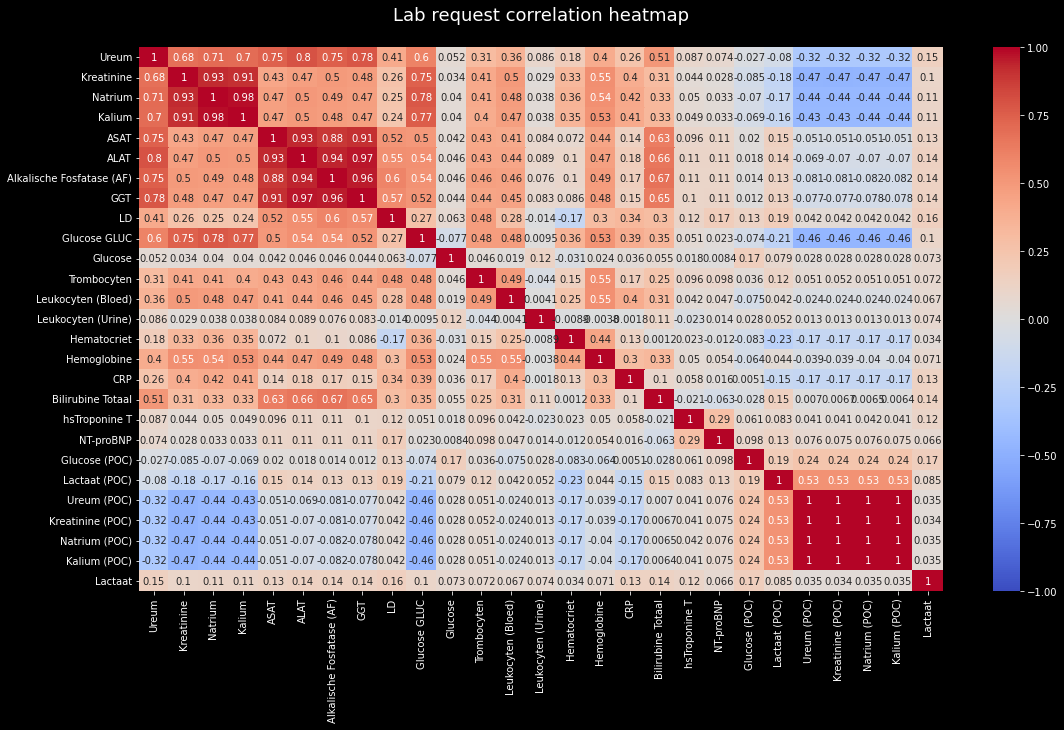

In [1006]:
df_requests = df_result.copy()
df_requests = (df_requests.notnull()).astype('int')

plt.figure(figsize=(18, 10))
plt.title('Lab request correlation heatmap\n', fontsize=18)
sns.heatmap(df_requests.corr(), annot=True, cmap='coolwarm', vmax=1, vmin=-1)
plt.show()